# Module Imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import nibabel as nb
import numpy as np
import pandas as pd
import pickle
import statsmodels.api as sm

from cca_zoo.models import MCCA
from matplotlib import cm, gridspec, colors
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D
from patsy import dmatrix
from pygam import LogisticGAM, te, s
from utils.glm_utils import linear_regression, get_hrf, convolve_hrf, onsets_to_block
from utils.signal.butterworth_filters import butterworth_filter
from utils.stationary_block_bootstrap import resample as ts_resample
from utils.load_write import load_nki_event_file
from run_taskbh_nki_analysis import construct_task_blocks
from pygam import LinearGAM, LogisticGAM, te, s, f
from scipy.signal import hilbert
from scipy.interpolate import interp1d
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import TimeSeriesSplit



Bad key text.latex.preview in file /Users/taylorbolt/opt/miniconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /Users/taylorbolt/opt/miniconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /Users/taylorbolt/opt/miniconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpe

# 1. Global Variables and Functions

## 1.1 Global Functions

In [2]:
def commonality_analysis(pc_norm, full_pred, pred_label, pred_label_col_indx):
    sm_fit = sm.OLS(pc_norm, full_pred, hasconst=False).fit()
    full_r2 = sm_fit.rsquared
    common_r2 = full_r2.copy()
    unique_r2 = {}
    for i, label in enumerate(pred_label):
        partial_pred_i = [col_n for col_n, label_i in enumerate(pred_label_col_indx) if label_i != i]
        partial_pred = full_pred[:, partial_pred_i]
        sm_fit_partial = sm.OLS(pc_norm, partial_pred).fit()
        unique_r2[label] = full_r2 - sm_fit_partial.rsquared
        common_r2 -= unique_r2[label]
    return full_r2, common_r2, unique_r2


def evaluate_model(lag_vec, model, spline_basis, var_eval):
    # Create basis from model evaluation using previously defined design matrix (for model fit)
    basis_lag_pred = dmatrix(spline_basis.design_info, {'x': lag_vec}, return_type='dataframe')
     # Intialize basis matrix
    pred_list = [var_eval * basis_lag_pred.iloc[:, l].values for l in range(basis_lag_pred.shape[1])]
    pred_mat = np.vstack(pred_list).T
    # Get predictions from model
    pred_lags = model.predict(pred_mat)
    return pred_lags


def lag_basis(var, lag_vec, lag_nknots, q1=0.1, q2=0.9):
    # Create Cubic B-spline basis for predictor and lag
    lag_splines = dmatrix("cr(x, df=lag_nknots) - 1", 
                          {"x": lag_vec}, return_type='dataframe')
    # Intialize basis matrix
    basis_lag = np.zeros((len(var), lag_splines.shape[1]))
    # Loop through lag bases and multiply column pairs
    lag_mat = pd.concat([var.shift(l) for l in lag_vec], axis=1)
    for l in np.arange(lag_splines.shape[1]):
        basis_lag[:, l] = np.dot(lag_mat.values, lag_splines.iloc[:,l].values)
    return basis_lag, lag_splines


def timeseries_cv(model, X, y, n_splits, gap, max_train_size, test_size):
    ts_cv = TimeSeriesSplit(
        n_splits=n_splits,
        gap=gap,
        max_train_size=max_train_size,
        test_size=test_size,
    )

    all_splits = list(ts_cv.split(X, y))
    corr_split = []
    for i in range(len(all_splits)):
        train = all_splits[i][0]
        test = all_splits[i][1]
        X_train = X[train, :]
        y_train = y[train]
        X_test = X[test, :]
        y_test = y[test]
        model_fit = model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        corr_split.append(np.corrcoef(y_test, y_pred)[0,1])
    return corr_split


def load_subj_chang(subj, scan, pc_ts, pc_ts_v, pc_ts_p, clus_precuneus, clus_superior_parietal, 
              fs, norm=True, bp_filter=True):
    if scan < 10:
        scan_str = f'000{scan}'
    else:
        scan_str = f'00{scan}'
        
    p_str = f'data/dataset_chang/physio/proc1_physio/sub_00{subj}_mr_{scan_str}_physio.csv'
    physio_df = pd.read_csv(p_str)
    e_str = f'data/dataset_chang/eeg/proc1_fbands/sub_00{subj}_mr_{scan_str}_fbands.csv'
    eeg_bands = pd.read_csv(e_str)
    csf = np.loadtxt(f'data/dataset_chang/physio/proc1_physio/sub_00{subj}_mr_{scan_str}_csf.txt')
    gs = np.loadtxt((f'data/dataset_chang/physio/proc1_physio/sub_00{subj}_mr_{scan_str}_global_sig.txt'))
    precuneus_seed = np.loadtxt(
        f'data/dataset_chang/physio/proc1_physio/sub_00{subj}_mr_{scan_str}_precuneus.txt'
    )
    superior_parietal_seed = np.loadtxt(
        f'data/dataset_chang/physio/proc1_physio/sub_00{subj}_mr_{scan_str}_superior_parietal.txt'
    )
    df = pd.concat([physio_df, eeg_bands], axis=1)
    df['csf'] = csf
    df['gs'] = gs
    infraslow = df.pop('Infraslow')
    vigilance_ad = df.pop('vigilance_ad')
    vigilance_at = df.pop('vigilance_at')
    if bp_filter:
        df = df.apply(lambda x: butterworth_filter(x, 0.01, 0.1, fs=fs, filter_type='bandpass'), axis=0)
    df['Infraslow'] = infraslow
    df['pc1'] = pc_ts[:,0]
    df['pc2'] = pc_ts[:,1]
    df['pc3'] = pc_ts[:,2]
    df['pc1_v'] = pc_ts_v[:,0]
    df['pc2_v'] = pc_ts_v[:,1]
    df['pc1_p'] = pc_ts_p[:,0]
    df['pc2_p'] = pc_ts_p[:,1]
    df['pc3_p'] = pc_ts_p[:,2]
    df['vigilance_ad'] = vigilance_ad
    df['vigilance_at'] = vigilance_at
    df['vigilance_ad_low'] =  butterworth_filter(vigilance_ad, None, 0.01, fs=fs, filter_type='lowpass')
    df['vigilance_at_low'] = butterworth_filter(vigilance_at, None, 0.01, fs=fs, filter_type='lowpass')
    if norm:
        df = df.apply(zscore, axis=0)
    df['cap_precuneus'] = clus_precuneus
    df['cap_superior_parietal'] = clus_superior_parietal
    df['precuneus_seed_ts'] = precuneus_seed
    df['superior_parietal_seed_ts'] = superior_parietal_seed
    df.reset_index(inplace=True)
    df = df.rename(columns = {'index':'time'})
    return df


def load_subj_hcp(subj, pc_ts, pc_ts_v, pc_ts_p, clus_precuneus, clus_superior_parietal, 
                  fs, norm=True):
    p_str = f'data/dataset_hcp/physio/proc1_physio/{subj}_physio.csv'
    csf_str = f'data/dataset_hcp/physio/proc1_physio/{subj}_csf.txt'
    df = pd.read_csv(p_str)
    csf = np.loadtxt(csf_str)
    df['csf'] = csf
    ## IMPORTANT! CSF signal has large amplitude spikes at start of scan - set first 10 time points to median
    breakpoint()
    df['csf'].iloc[:10] = df['csf'].median()
    df = df.apply(lambda x: butterworth_filter(x, 0.01, 0.1, fs=fs, filter_type='bandpass'), axis=0)
    df['pc1'] = pc_ts[:,0]*-1 # sign flip to keep consistent with Chang PCA
    df['pc2'] = pc_ts[:,1]
    df['pc3'] = pc_ts[:,2]
    df['pc1_v'] = pc_ts_v[:,0]
    df['pc2_v'] = pc_ts_v[:,1]
    df['pc1_p'] = pc_ts_p[:,0]*-1 # sign flip to keep consistent with Chang PCA
    df['pc2_p'] = pc_ts_p[:,1]
    df['pc3_p'] = pc_ts_p[:,2]*-1 # sign flip to keep consistent with Chang PCA
    if norm:
        df = df.apply(zscore, axis=0)
    df['cap_precuneus'] = clus_precuneus
    df['cap_superior_parietal'] = clus_superior_parietal
    df.reset_index(inplace=True)
    df = df.rename(columns = {'index':'time'})
    return df


def load_subj_nki(subj, pc_ts, pc_ts_v, pc_ts_p, fs, norm=True):
    p_str = f'data/dataset_nki/physio/proc1_physio/{subj}_task_breathhold_physio.csv'
    csf_str = f'data/dataset_nki/physio/proc1_physio/{subj}_task_breathhold_physio_csf.txt'
    df = pd.read_csv(p_str)
    csf = np.loadtxt(csf_str)
    df['csf'] = csf
    df = df.apply(lambda x: butterworth_filter(x, 0.01, 0.1, fs=fs, filter_type='bandpass'), axis=0)
    df['pc1'] = pc_ts[:,0]
    df['pc2'] = pc_ts[:,1]
    df['pc1_v'] = pc_ts_v[:,0]
    df['pc2_v'] = pc_ts_v[:,1]
    df['pc1_p'] = pc_ts_p[:,0]
    df['pc2_p'] = pc_ts_p[:,1]
    df['pc6_p'] = pc_ts_p[:,6]
    df['pc9_p'] = pc_ts_p[:,8]
    if norm:
        df = df.apply(zscore, axis=0)
    df.reset_index(inplace=True)
    df = df.rename(columns = {'index':'time'})
    event_df = pd.read_csv(f'data/dataset_nki/events/{subj}_task_breathhold_events.tsv', sep='\t')
    event_df.loc[event_df.trial_type.str.startswith('H'), 'trial_type'] = 'H'
    event_df.loc[event_df.trial_type.isin(['G', 'Deep','In','Out']), 'trial_type'] = 'B'
    for event in event_df.trial_type.unique():
        trial_df = event_df.loc[event_df.trial_type == event]
        trial_ind = onsets_to_block(trial_df, 186, 1.4)
        df[f'trial_{event}'] = trial_ind
    return df
   

def time_varying_splines(basis, time_vec, time_nknots, offset=10):
    # Get array of equally-spaced time values
    time_knots = np.linspace(0+offset,len(time_vec) - offset,time_nknots)
    # Create Cubic B-spline basis for predictor and lag
    time_splines = dmatrix("cr(x, knots=time_knots) - 1", 
                          {"x": time_vec}, return_type='dataframe')
    # Initialize time-varying design matrix
    tv_basis = np.zeros((basis.shape[0], time_splines.shape[1]*basis.shape[1]))
    indx = 0
    for t in np.arange(time_splines.shape[1]):
        for b in np.arange(basis.shape[1]):
            tv_basis[:,indx]= time_splines.iloc[:,t] * basis[:,b]
            indx += 1
    return tv_basis, time_splines


def xcorr(x, y, maxlags=30, constrain='abs'):
    Nx = len(x)
    if Nx != len(y):
        raise ValueError('x and y must be equal length')
    c = np.correlate(x, y, mode=2)
    c /= np.sqrt(np.dot(x, x) * np.dot(y, y))
    if maxlags is None:
        maxlags = Nx - 1
    if maxlags >= Nx or maxlags < 1:
        raise ValueError('maglags must be None or strictly '
                         'positive < %d' % Nx)
    lags = np.arange(-maxlags, maxlags + 1)
    c = c[Nx - 1 - maxlags:Nx + maxlags]
    if constrain == 'abs':
        max_r = c[np.argsort(np.abs(c))[-1]]
        max_lag = lags[np.argsort(np.abs(c))[-1]]
    elif constrain == 'pos':
        max_r = c[np.argsort(c)[-1]]
        max_lag = lags[np.argsort(c)[-1]]
    elif constrain == 'neg':
        max_r = c[np.argsort(-c)[-1]]
        max_lag = lags[np.argsort(-c)[-1]]
    
    return max_r, max_lag

## 1.2 Global Variables

In [10]:
fs_chang = 1/2.1
fs_hcp = 1/0.72
fs_nki = 1/1.4

subject_list_hcp = pd.read_csv('data/dataset_hcp_nofix/subject_list_hcp_subset_subset.csv')
subject_list_chang = pd.read_csv('data/dataset_chang/subject_list_chang.csv')
subject_list_nki = pd.read_csv('data/dataset_nki/subject_list_nki.csv')

# 2. Load PCA Time Courses and CAP Time Points

## 2.1 Chang Dataset

In [11]:
pca_output = pickle.load(open(f'results/pca/chang_pca_group_results.pkl', 'rb'))
pca_output_v = pickle.load(open(f'results/pca/chang_pca_group_varimax_results.pkl', 'rb'))
pca_output_p = pickle.load(open(f'results/pca/chang_pca_group_promax_results.pkl', 'rb'))

caps_precuneus = pickle.load(open(f'results/caps/chang_cap_group_precuneus_n2_results.pkl', 'rb'))
caps_superior_parietal = pickle.load(open(f'results/caps/chang_cap_group_superior_parietal_n2_results.pkl', 'rb'))

precuneus_caps = caps_precuneus[1]
precuneus_clus = caps_precuneus[0] + 1
superior_parietal_caps = caps_superior_parietal[1]
superior_parietal_clus = caps_superior_parietal[0] + 1

pc_ts = pca_output['pc_scores']
pc_ts_v = pca_output_v['pc_scores']
pc_ts_p = pca_output_p['pc_scores']

n_t = 0
clus_precuneus_indx = 0
clus_superior_parietal_indx = 0
pc_subj_chang = {}
pc_v_subj_chang = {}
pc_p_subj_chang = {}
clus_subj_precuneus_chang = {}
clus_subj_superior_parietal_chang = {}
for i, (subj, scan) in enumerate(zip(subject_list_chang.subject, subject_list_chang.scan)):
    # Extract subject PC time series
    pc_subj_chang[f'{subj}_{scan}'] = pc_ts[n_t:(n_t+693),:]
    # Extract subject PC-Varimax time series
    pc_v_subj_chang[f'{subj}_{scan}'] = pc_ts_v[n_t:(n_t+693),:]
    # Extract subject PC-Promax time series
    pc_p_subj_chang[f'{subj}_{scan}'] = pc_ts_p[n_t:(n_t+693),:]
    n_t += 693
    # Extract Precuneus CAP time points
    subj_precuneus_ts_indx = precuneus_caps[i]
    clus_indx = precuneus_clus[clus_precuneus_indx:(clus_precuneus_indx + len(subj_precuneus_ts_indx))]
    subj_precuneus_caps = np.zeros((693, 1))
    subj_precuneus_caps[subj_precuneus_ts_indx] = clus_indx[:,np.newaxis]
    clus_subj_precuneus_chang[f'{subj}_{scan}'] = subj_precuneus_caps
    clus_precuneus_indx += len(subj_precuneus_ts_indx)
    # Extract Superior Parietal CAP time points
    subj_superior_parietal_ts_indx = superior_parietal_caps[i]
    clus_indx = superior_parietal_clus[
        clus_superior_parietal_indx:(clus_superior_parietal_indx + len(subj_superior_parietal_ts_indx))
    ]
    subj_superior_parietal_caps = np.zeros((693, 1))
    subj_superior_parietal_caps[subj_superior_parietal_ts_indx] = clus_indx[:,np.newaxis]
    clus_subj_superior_parietal_chang[f'{subj}_{scan}'] = subj_superior_parietal_caps
    clus_superior_parietal_indx += len(subj_superior_parietal_ts_indx)
    

## 2.2 HCP Dataset

In [12]:
pca_output = pickle.load(open(f'results/pca/hcp_pca_group_results.pkl', 'rb'))
pca_output_v = pickle.load(open(f'results/pca/hcp_pca_group_varimax_results.pkl', 'rb'))
pca_output_p = pickle.load(open(f'results/pca/hcp_pca_group_promax_results.pkl', 'rb'))
pc_ts = pca_output['pc_scores']
pc_ts_v = pca_output_v['pc_scores']
pc_ts_p = pca_output_p['pc_scores']

caps_precuneus = pickle.load(open(f'results/caps/hcp_cap_group_precuneus_n2_results.pkl', 'rb'))
caps_superior_parietal = pickle.load(open(f'results/caps/hcp_cap_group_superior_parietal_n2_results.pkl', 'rb'))

precuneus_caps = caps_precuneus[1]
precuneus_clus = caps_precuneus[0] + 1
superior_parietal_caps = caps_superior_parietal[1]
superior_parietal_clus = caps_superior_parietal[0] + 1

n_t = 0
pc_subj_hcp = {}
pc_v_subj_hcp = {}
pc_p_subj_hcp = {}
clus_precuneus_indx = 0
clus_superior_parietal_indx = 0
clus_subj_precuneus_hcp = {}
clus_subj_superior_parietal_hcp = {}
for i, subj in enumerate(subject_list_hcp.subject):
    # Extract subject PC time series
    pc_subj_hcp[f'{subj}'] = pc_ts[n_t:(n_t+1200),:]
    # Extract subject PC-Varimax time series
    pc_v_subj_hcp[f'{subj}'] = pc_ts_v[n_t:(n_t+1200),:]
    # Extract subject PC-Promax time series
    pc_p_subj_hcp[f'{subj}'] = pc_ts_p[n_t:(n_t+1200),:]
    n_t += 1200
    # Extract Precuneus CAP time points
    subj_precuneus_ts_indx = precuneus_caps[i]
    clus_indx = precuneus_clus[clus_precuneus_indx:(clus_precuneus_indx + len(subj_precuneus_ts_indx))]
    subj_precuneus_caps = np.zeros((1200, 1))
    subj_precuneus_caps[subj_precuneus_ts_indx] = clus_indx[:,np.newaxis]
    clus_subj_precuneus_hcp[f'{subj}'] = subj_precuneus_caps
    clus_precuneus_indx += len(subj_precuneus_ts_indx)
    # Extract Superior Parietal CAP time points
    subj_superior_parietal_ts_indx = superior_parietal_caps[i]
    clus_indx = superior_parietal_clus[
        clus_superior_parietal_indx:(clus_superior_parietal_indx + len(subj_superior_parietal_ts_indx))
    ]
    subj_superior_parietal_caps = np.zeros((1200, 1))
    subj_superior_parietal_caps[subj_superior_parietal_ts_indx] = clus_indx[:,np.newaxis]
    clus_subj_superior_parietal_hcp[f'{subj}'] = subj_superior_parietal_caps
    clus_superior_parietal_indx += len(subj_superior_parietal_ts_indx)
    

## 2.3 NKI Dataset

In [13]:
pca_output = pickle.load(open(f'results/pca/nki_pca_group_results.pkl', 'rb'))
pca_output_v = pickle.load(open(f'results/pca/nki_pca_group_varimax_results.pkl', 'rb'))
pca_output_p = pickle.load(open(f'results/pca/nki_pca_group_promax_n10_results.pkl', 'rb'))
pc_ts = pca_output['pc_scores']
pc_ts_v = pca_output_v['pc_scores']
pc_ts_p = pca_output_p['pc_scores']


n_t = 0
pc_subj_nki = {}
pc_v_subj_nki = {}
pc_p_subj_nki = {}
for i, subj in enumerate(subject_list_nki.subject):
    # Extract subject PC time series
    pc_subj_nki[f'{subj}'] = pc_ts[n_t:(n_t+186),:]
    # Extract subject PC-Varimax time series
    pc_v_subj_nki[f'{subj}'] = pc_ts_v[n_t:(n_t+186),:]
    # Extract subject PC-Promax time series
    pc_p_subj_nki[f'{subj}'] = pc_ts_p[n_t:(n_t+186),:]
    n_t += 186

# 3. Subject-Level Analysis

## 3.1 Subject Highlights

### 3.1.1 Pattern One and CSF Inflow

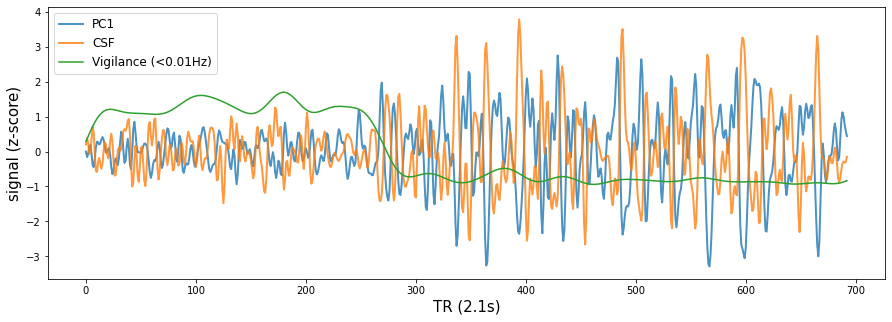

In [309]:
# Chang Dataset: Subject 10 - Scan 9
subj=10; scan=9
df = load_subj_chang(subj, scan, pc_subj_chang[f'{subj}_{scan}'], 
                     pc_v_subj_chang[f'{subj}_{scan}'], pc_p_subj_chang[f'{subj}_{scan}'],
                     clus_subj_precuneus_chang[f'{subj}_{scan}'], clus_subj_superior_parietal_chang[f'{subj}_{scan}'], 
                     fs_chang)
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df['pc1'], label='PC1', linewidth=2, alpha=0.8)
ax.plot(df['csf'] ,label='CSF', linewidth=2, alpha=0.8)
ax.plot(df['vigilance_at_low'], label='Vigilance (<0.01Hz)')
ax.set_xlabel('TR (2.1s)', fontsize=15)
ax.set_ylabel('signal (z-score)', fontsize=15)
ax.legend(fontsize=12)

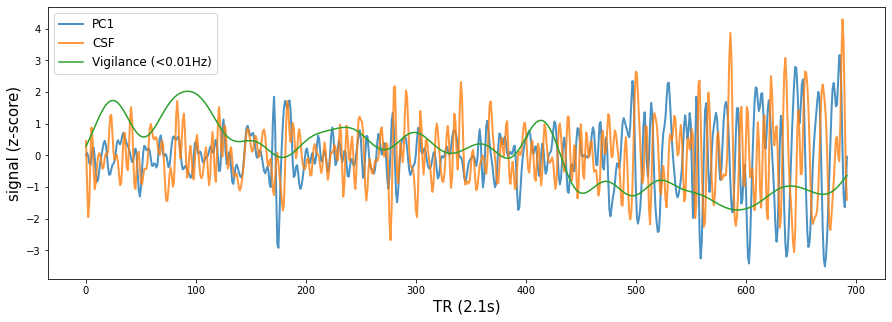

In [314]:
# Chang Dataset: Subject 14 - Scan 12
subj=14; scan=12
df = load_subj_chang(subj, scan, pc_subj_chang[f'{subj}_{scan}'], 
                     pc_v_subj_chang[f'{subj}_{scan}'], pc_p_subj_chang[f'{subj}_{scan}'],
                     clus_subj_precuneus_chang[f'{subj}_{scan}'], clus_subj_superior_parietal_chang[f'{subj}_{scan}'], 
                     fs_chang)
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df['pc1'], label='PC1', linewidth=2, alpha=0.8)
ax.plot(df['csf'] ,label='CSF', linewidth=2, alpha=0.8)
ax.plot(df['vigilance_at_low'], label='Vigilance (<0.01Hz)')
ax.set_xlabel('TR (2.1s)', fontsize=15)
ax.set_ylabel('signal (z-score)', fontsize=15)
ax.legend(fontsize=12)

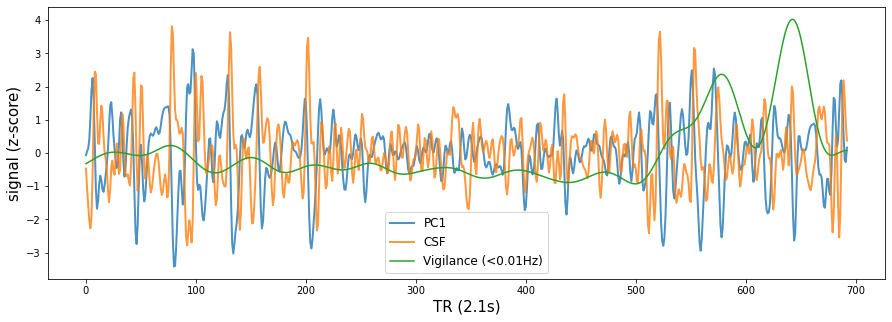

In [321]:
# Chang Dataset: Subject 12 - Scan 12
subj=12; scan=12
df = load_subj_chang(subj, scan, pc_subj_chang[f'{subj}_{scan}'], 
                     pc_v_subj_chang[f'{subj}_{scan}'], pc_p_subj_chang[f'{subj}_{scan}'],
                     clus_subj_precuneus_chang[f'{subj}_{scan}'], clus_subj_superior_parietal_chang[f'{subj}_{scan}'], 
                     fs_chang)
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df['pc1'], label='PC1', linewidth=2, alpha=0.8)
ax.plot(df['csf'] ,label='CSF', linewidth=2, alpha=0.8)
ax.plot(df['vigilance_at_low'], label='Vigilance (<0.01Hz)')
ax.set_xlabel('TR (2.1s)', fontsize=15)
ax.set_ylabel('signal (z-score)', fontsize=15)
ax.legend(fontsize=12)

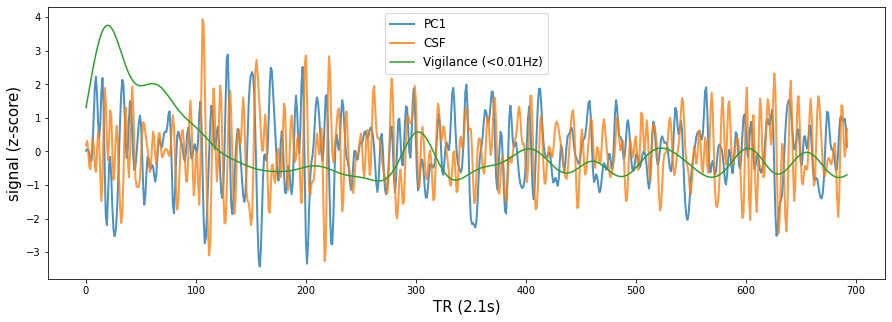

In [326]:
# Chang Dataset: Subject 27 - Scan 9
subj=27; scan=9
df = load_subj_chang(subj, scan, pc_subj_chang[f'{subj}_{scan}'], 
                     pc_v_subj_chang[f'{subj}_{scan}'], pc_p_subj_chang[f'{subj}_{scan}'],
                     clus_subj_precuneus_chang[f'{subj}_{scan}'], clus_subj_superior_parietal_chang[f'{subj}_{scan}'], 
                     fs_chang)
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df['pc1'], label='PC1', linewidth=2, alpha=0.8)
ax.plot(df['csf'] ,label='CSF', linewidth=2, alpha=0.8)
ax.plot(df['vigilance_at_low'], label='Vigilance (<0.01Hz)')
ax.set_xlabel('TR (2.1s)', fontsize=15)
ax.set_ylabel('signal (z-score)', fontsize=15)
ax.legend(fontsize=12)

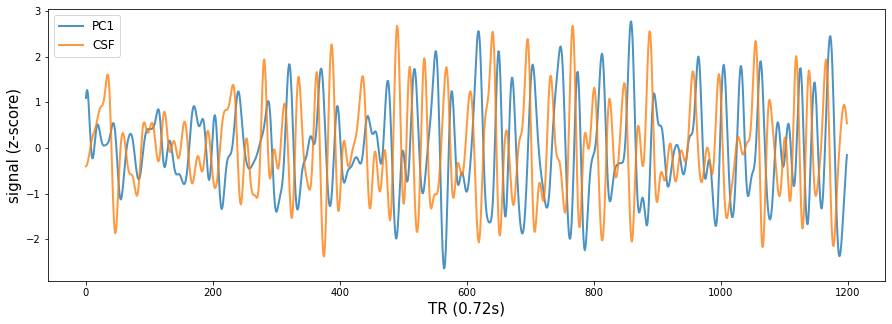

In [330]:
# HCP Dataset: Subject 103818
subj=103818
df = load_subj_hcp(subj, pc_subj_hcp[f'{subj}'], pc_v_subj_hcp[f'{subj}'], pc_p_subj_hcp[f'{subj}'],
               clus_subj_precuneus_hcp[f'{subj}'], clus_subj_superior_parietal_hcp[f'{subj}'], 
               fs_hcp, norm=True)
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df['pc1'], label='PC1', linewidth=2, alpha=0.8)
ax.plot(df['PPG_PEAK_AMP'],label='CSF', linewidth=2, alpha=0.8)
ax.set_xlabel('TR (0.72s)', fontsize=15)
ax.set_ylabel('signal (z-score)', fontsize=15)
ax.legend(fontsize=12)

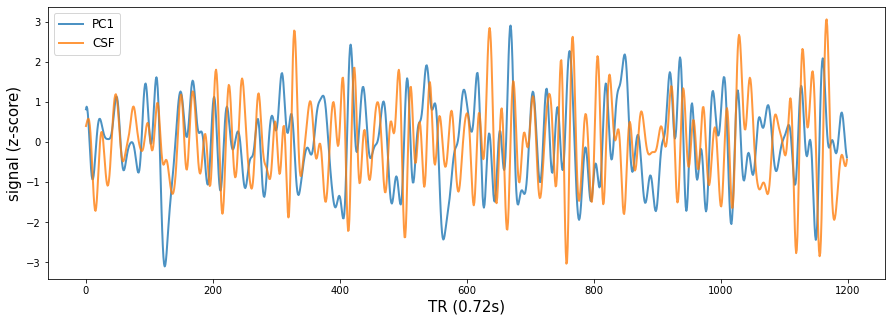

In [332]:
# HCP Dataset: Subject 103818
subj=158035
df = load_subj_hcp(subj, pc_subj_hcp[f'{subj}'], pc_v_subj_hcp[f'{subj}'], pc_p_subj_hcp[f'{subj}'],
               clus_subj_precuneus_hcp[f'{subj}'], clus_subj_superior_parietal_hcp[f'{subj}'], 
               fs_hcp, norm=True)
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df['pc1'], label='PC1', linewidth=2, alpha=0.8)
ax.plot(df['csf'],label='CSF', linewidth=2, alpha=0.8)
ax.set_xlabel('TR (0.72s)', fontsize=15)
ax.set_ylabel('signal (z-score)', fontsize=15)
ax.legend(fontsize=12)

## 3.2 Summary of Subject-Level CSF and PC1 Cross-Correlation

### 3.2.1 Chang Dataset

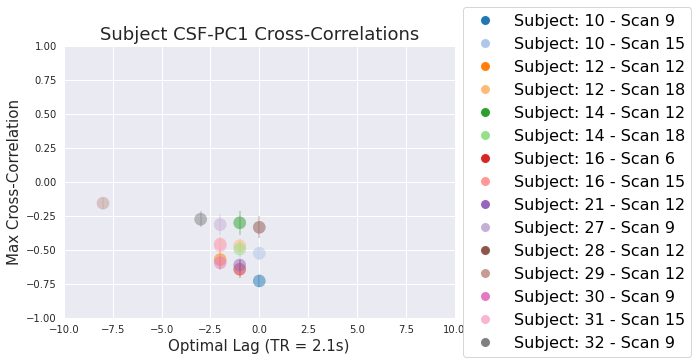

In [110]:
n_bootstraps=100
bootstrap_r = []
max_r_all = []
max_lag_all = []
# Loop through subjects and run regression
for i in range(subject_list_chang.shape[0]):
    # Load Subject
    subj, scan = subject_list_chang.iloc[i, 0], subject_list_chang.iloc[i, 1]
    sleep = subject_list_chang.iloc[i, 2]
    df = load_subj_chang(subj, scan, pc_subj_chang[f'{subj}_{scan}'], 
                     pc_v_subj_chang[f'{subj}_{scan}'], pc_p_subj_chang[f'{subj}_{scan}'],
                     clus_subj_precuneus_chang[f'{subj}_{scan}'], clus_subj_superior_parietal_chang[f'{subj}_{scan}'], 
                     fs_chang)
    max_r, max_lag = xcorr(df['csf'], df['pc2_p'], maxlags=10, constrain='neg')
    max_r_all.append(max_r)
    max_lag_all.append(max_lag)
    X = np.vstack([df['csf'].values, df['pc2_p'].values]).T
    subj_r = []
    for n in range(n_bootstraps):
        # sampling from geometric distribution - 
        # p parameter determines block length (expected len = 1/p)
        X_b, _, _ = ts_resample(X, 0.05)
        max_r_b, _ = xcorr(X_b[:,0], X_b[:,1], maxlags=10, constrain='neg')
        subj_r.append(max_r_b)
    bootstrap_r.append(np.std(subj_r))

cmap = cm.get_cmap('tab20')
subj_labels = [f'Subject: {subj} - Scan {scan}' 
               for subj, scan in zip(subject_list_chang.iloc[:, 0], subject_list_chang.iloc[:, 1])]
c_subj = [cmap(i) for i in range(len(subj_labels))]

with plt.style.context('seaborn'):
    fig, ax = plt.subplots(figsize=(7,5), constrained_layout=False)
    ax.scatter(max_lag_all, max_r_all, s=150, alpha=0.5, 
               c=c_subj, label=subj_labels)
    ax.errorbar(max_lag_all, max_r_all, 
                yerr=bootstrap_r, fmt='|', alpha=0.3, ecolor=c_subj)
    ax.set_ylim([-1,1])
    ax.set_xlim([-10,10])
    ax.set_xlabel('Optimal Lag (TR = 2.1s)', fontsize=15)
    ax.grid(True)
    ax.set_title('Subject CSF-PC1 Cross-Correlations', fontweight='bold', fontsize=18)
    ax.set_ylabel('Max Cross-Correlation', fontsize=15)

recs = []
for i in range(0,len(c_subj)):
    recs.append(Line2D(range(1), range(1), color="white", marker='o', markersize=10, markerfacecolor=c_subj[i]))
plt.legend(recs,subj_labels,loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16)

### 3.2.2 HCP Dataset

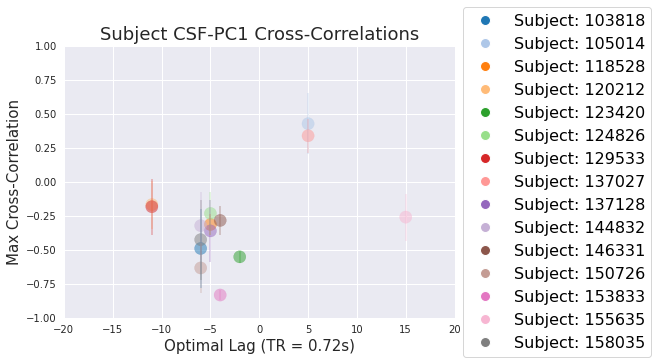

In [17]:
n_bootstraps=100
bootstrap_r = []
max_r_all = []
max_lag_all = []
# Loop through subjects and run regression
for i in range(subject_list_hcp.shape[0]):
    # Load Subject
    subj = subject_list_hcp.iloc[i, 0]
    df = load_subj_hcp(subj, pc_subj_hcp[f'{subj}'], pc_v_subj_hcp[f'{subj}'], pc_p_subj_hcp[f'{subj}'],
               clus_subj_precuneus_hcp[f'{subj}'], clus_subj_superior_parietal_hcp[f'{subj}'], 
               fs_hcp, norm=True)
    max_r, max_lag = xcorr(df['csf'], df['pc1'], maxlags=20)
    max_r_all.append(max_r)
    max_lag_all.append(max_lag)
    X = np.vstack([df['csf'].values, df['pc1'].values]).T
    subj_r = []
    for n in range(n_bootstraps):
        # sampling from geometric distribution - 
        # p parameter determines block length (expected len = 1/p)
        X_b, _, _ = ts_resample(X, 0.05)
        max_r_b, _ = xcorr(X_b[:,0], X_b[:,1])
        subj_r.append(max_r_b)
    bootstrap_r.append(np.std(subj_r))

cmap = cm.get_cmap('tab20')
subj_labels = [f'Subject: {subj}' for subj in subject_list_hcp.iloc[:, 0]]
c_subj = [cmap(i) for i in range(len(subj_labels))]

with plt.style.context('seaborn'):
    fig, ax = plt.subplots(figsize=(7,5), constrained_layout=False)
    ax.scatter(max_lag_all, max_r_all, s=150, alpha=0.5, 
               c=c_subj, label=subj_labels)
    ax.errorbar(max_lag_all, max_r_all, 
                yerr=bootstrap_r, fmt='|', alpha=0.3, ecolor=c_subj)
    ax.set_ylim([-1,1])
    ax.set_xlim([-20,20])
    ax.set_xlabel('Optimal Lag (TR = 0.72s)', fontsize=15)
    ax.grid(True)
    ax.set_title('Subject CSF-PC1 Cross-Correlations', fontweight='bold', fontsize=18)
    ax.set_ylabel('Max Cross-Correlation', fontsize=15)

recs = []
for i in range(0,len(c_subj)):
    recs.append(Line2D(range(1), range(1), color="white", marker='o', markersize=10, markerfacecolor=c_subj[i]))
plt.legend(recs,subj_labels,loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16)

## 3.4 Summary of Subject Level PPG-LOW and PC1 Cross-Correlation

### 3.4.1 Chang Dataset

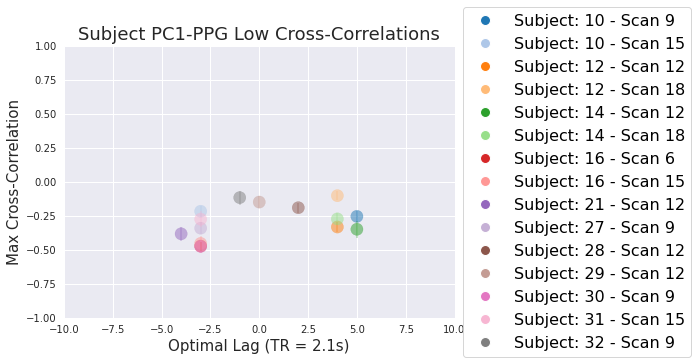

In [113]:
n_bootstraps=100
bootstrap_r = []
max_r_all = []
max_lag_all = []
# Loop through subjects and run regression
for i in range(subject_list_chang.shape[0]):
    # Load Subject
    subj, scan = subject_list_chang.iloc[i, 0], subject_list_chang.iloc[i, 1]
    sleep = subject_list_chang.iloc[i, 2]
    df = load_subj_chang(subj, scan, pc_subj_chang[f'{subj}_{scan}'], 
                     pc_v_subj_chang[f'{subj}_{scan}'], pc_p_subj_chang[f'{subj}_{scan}'],
                     clus_subj_precuneus_chang[f'{subj}_{scan}'], clus_subj_superior_parietal_chang[f'{subj}_{scan}'], 
                     fs_chang)
    max_r, max_lag = xcorr(df['PPG_LOW_NK'], df['pc3_p'], maxlags=10, constrain='neg')
    max_r_all.append(max_r)
    max_lag_all.append(max_lag)
    X = np.vstack([df['PPG_LOW_NK'].values, df['pc3_p'].values]).T
    subj_r = []
    for n in range(n_bootstraps):
        # sampling from geometric distribution - 
        # p parameter determines block length (expected len = 1/p)
        X_b, _, _ = ts_resample(X, 0.05)
        max_r_b, _ = xcorr(X_b[:,0], X_b[:,1], constrain='neg')
        subj_r.append(max_r_b)
    bootstrap_r.append(np.std(subj_r))

cmap = cm.get_cmap('tab20')
subj_labels = [f'Subject: {subj} - Scan {scan}' 
               for subj, scan in zip(subject_list_chang.iloc[:, 0], subject_list_chang.iloc[:, 1])]
c_subj = [cmap(i) for i in range(len(subj_labels))]

with plt.style.context('seaborn'):
    fig, ax = plt.subplots(figsize=(7,5), constrained_layout=False)
    ax.scatter(max_lag_all, max_r_all, s=150, alpha=0.5, 
               c=c_subj, label=subj_labels)
    ax.errorbar(max_lag_all, max_r_all, 
                yerr=bootstrap_r, fmt='|', alpha=0.3, ecolor=c_subj)
    ax.set_ylim([-1,1])
    ax.set_xlim([-10,10])
    ax.set_xlabel('Optimal Lag (TR = 2.1s)', fontsize=15)
    ax.grid(True)
    ax.set_title('Subject PC1-PPG Low Cross-Correlations', fontweight='bold', fontsize=18)
    ax.set_ylabel('Max Cross-Correlation', fontsize=15)

recs = []
for i in range(0,len(c_subj)):
    recs.append(Line2D(range(1), range(1), color="white", marker='o', markersize=10, markerfacecolor=c_subj[i]))
plt.legend(recs,subj_labels,loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16)

### 3.4.2 HCP Dataset

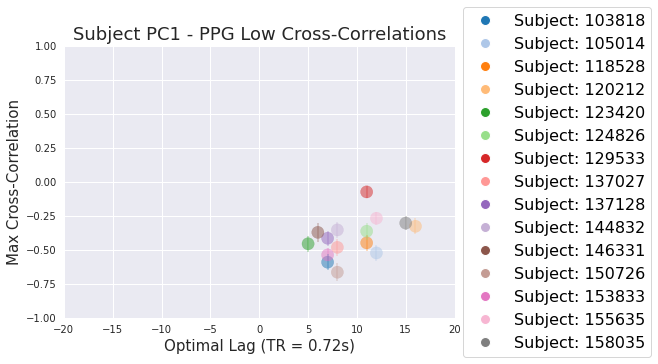

In [116]:
n_bootstraps=100
bootstrap_r = []
max_r_all = []
max_lag_all = []
# Loop through subjects and run regression
for i in range(subject_list_hcp.shape[0]):
    # Load Subject
    subj = subject_list_hcp.iloc[i, 0]
    df = load_subj_hcp(subj, pc_subj_hcp[f'{subj}'], pc_v_subj_hcp[f'{subj}'], pc_p_subj_hcp[f'{subj}'],
               clus_subj_precuneus_hcp[f'{subj}'], clus_subj_superior_parietal_hcp[f'{subj}'], 
               fs_hcp, norm=True)
    max_r, max_lag = xcorr(df['PPG_LOW_NK'], df['pc3_p'], maxlags=20, constrain='neg')
    max_r_all.append(max_r)
    max_lag_all.append(max_lag)
    X = np.vstack([df['PPG_LOW_NK'].values, df['pc3_p'].values]).T
    subj_r = []
    for n in range(n_bootstraps):
        # sampling from geometric distribution - 
        # p parameter determines block length (expected len = 1/p)
        X_b, _, _ = ts_resample(X, 0.05)
        max_r_b, _ = xcorr(X_b[:,0], X_b[:,1], constrain='neg')
        subj_r.append(max_r_b)
    bootstrap_r.append(np.std(subj_r))

cmap = cm.get_cmap('tab20')
subj_labels = [f'Subject: {subj}' for subj in subject_list_hcp.iloc[:, 0]]
c_subj = [cmap(i) for i in range(len(subj_labels))]

with plt.style.context('seaborn'):
    fig, ax = plt.subplots(figsize=(7,5), constrained_layout=False)
    ax.scatter(max_lag_all, max_r_all, s=150, alpha=0.5, 
               c=c_subj, label=subj_labels)
    ax.errorbar(max_lag_all, max_r_all, 
                yerr=bootstrap_r, fmt='|', alpha=0.3, ecolor=c_subj)
    ax.set_ylim([-1,1])
    ax.set_xlim([-20,20])
    ax.set_xlabel('Optimal Lag (TR = 0.72s)', fontsize=15)
    ax.grid(True)
    ax.set_title('Subject PC1 - PPG Low Cross-Correlations', fontweight='bold', fontsize=18)
    ax.set_ylabel('Max Cross-Correlation', fontsize=15)

recs = []
for i in range(0,len(c_subj)):
    recs.append(Line2D(range(1), range(1), color="white", marker='o', markersize=10, markerfacecolor=c_subj[i]))
plt.legend(recs,subj_labels,loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16)

## 3.3 Subject-Level Commonality Analysis

### 3.3.1 Chang Dataset

#### 3.3.1.1 Run Commonality Analysis

In [47]:
# Regression (Spline) Parameters
lag_vec = np.arange(11)
nknots=3
n_bootstraps=100

# Initilialize results objects
cv_corr_r = []
full_r2_g = []
full_r2_g_e = []
common_r2_g = []
common_r2_g_e = []
unique_r2_g = {
    'RV': [],
    'PPG': [],
    'Infraslow': [],
    'Alpha': []
}
unique_r2_g_e = {
    'RV': [],
    'PPG': [],
    'Infraslow': [],
    'Alpha': []
}

lag_var_g = {
    'RV': [],
    'PPG': [],
    'Infraslow': [],
    'Alpha': []
}

# Loop through subjects and run regression
for i in range(subject_list_chang.shape[0]):
    # Load Subject
    subj, scan = subject_list_chang.iloc[i, 0], subject_list_chang.iloc[i, 1]
    sleep = subject_list_chang.iloc[i, 2]
    df = load_subj_chang(subj, scan, pc_subj_chang[f'{subj}_{scan}'], 
                     pc_v_subj_chang[f'{subj}_{scan}'], pc_p_subj_chang[f'{subj}_{scan}'],
                     clus_subj_precuneus_chang[f'{subj}_{scan}'], clus_subj_superior_parietal_chang[f'{subj}_{scan}'], 
                     fs_chang)
    
    # Create lag spline bases for physio time series
    rv_basis, lag_spline = lag_basis(df['RESP_AMP_HILBERT'], lag_vec, nknots)
    ppg_basis, _ = lag_basis(df['PPG_RATE_NK'], lag_vec, nknots)
    infraslow_basis, _ = lag_basis(df['Infraslow'], lag_vec, nknots)
    alpha_basis, _ = lag_basis(df['Alpha'], lag_vec, nknots)
    # Drop NaNs at beginning of time series introduced by lag, and then normalize
    na_indx = ~(np.isnan(rv_basis).any(axis=1))
    rv_basis_norm = zscore(rv_basis[na_indx, :], axis=0)
    infraslow_basis_norm = zscore(infraslow_basis[na_indx,:], axis=0)
    alpha_basis_norm = zscore(alpha_basis[na_indx,:], axis=0)
    ppg_basis_norm = zscore(ppg_basis[na_indx,:], axis=0)
    pred_list = [rv_basis_norm, ppg_basis_norm, infraslow_basis_norm, alpha_basis_norm]
    # Create full design matrix
    full_basis_norm = np.hstack(pred_list)
    
    # Get PC time course
    pc_norm = zscore(df['pc3_p'].loc[na_indx].values)

    # Run commonality analysis
    pred_label = ['RV', 'PPG', 'Infraslow', 'Alpha']
    pred_label_col_indx = np.repeat(np.arange(len(pred_label)), nknots)
    full_r2, common_r2, unique_r2 = commonality_analysis(pc_norm, full_basis_norm, pred_label, pred_label_col_indx)
    ## get bootstrapped confidence intervals
    full_r2_bootstrap = []
    common_r2_bootstrap = []
    unique_r2_bootstrap = []
    X = np.hstack([pc_norm[:,np.newaxis], full_basis_norm])
    for n in range(n_bootstraps):
        # sampling from geometric distribution - 
        # p parameter determines block length (expected len = 1/p)
        X_b, _, _ = ts_resample(X, 0.05)
        full_r2_b, common_r2_b, unique_r2_b = commonality_analysis(
            X_b[:,0], X_b[:,1:], pred_label, pred_label_col_indx)
        full_r2_bootstrap.append(full_r2_b)
        common_r2_bootstrap.append(common_r2_b)
        unique_r2_bootstrap.append(unique_r2_b)
    
    
    # Run cross-validation
    lin_reg = LinearRegression(fit_intercept=False)
    cv_corr = timeseries_cv(lin_reg, full_basis_norm, pc_norm, 
                            n_splits=5, gap=10, max_train_size=200, test_size=50)
    cv_corr_r.append(cv_corr)
    
    lag_dict = {}
    for label, pred in zip(pred_label, pred_list):
        lin_reg = LinearRegression(fit_intercept=False)
        lin_reg.fit(pred, pc_norm)
        pred_ts_lin = lin_reg.predict(pred)
        pred_lag_vec = np.linspace(0, 11, 40)
        lag_pred = evaluate_model(pred_lag_vec, lin_reg, lag_spline, 1)
        lag_dict[label] = [pred_lag_vec, lag_pred]
        
    # Append results
    full_r2_g.append(full_r2)
    full_r2_g_e.append(np.std(full_r2_bootstrap))
    common_r2_g.append(common_r2)
    common_r2_g_e.append(np.std(common_r2_bootstrap))
    subj_unique_r2 = pd.DataFrame(unique_r2_bootstrap).std(axis=0).to_dict()
    for label in pred_label:
        unique_r2_g[label].append(unique_r2[label])
        unique_r2_g_e[label].append(subj_unique_r2[label])
        lag_indx = np.argmax(np.abs(lag_dict[label][1]))
        var_lag = lag_dict[label][0][lag_indx]
        lag_var_g[label].append(var_lag)


#### 3.3.1.2 Plot Results

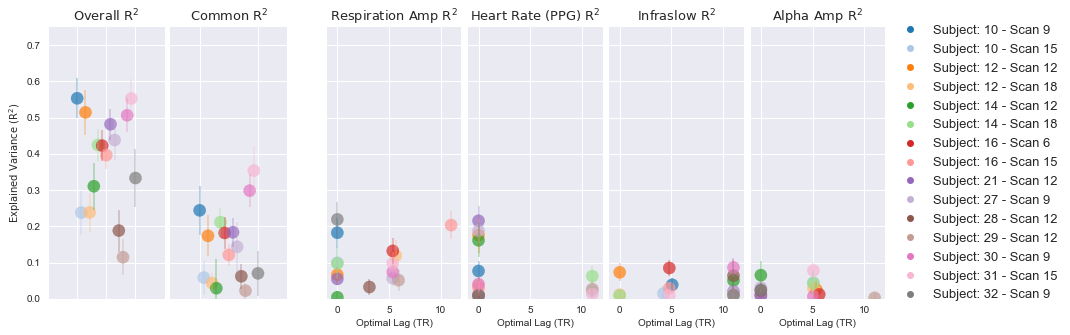

In [48]:
cmap = cm.get_cmap('tab20')
x_lag_vec = pred_lag_vec.copy()
subj_labels = [f'Subject: {subj} - Scan {scan}' for subj, scan in 
               zip(subject_list_chang.iloc[:, 0], subject_list_chang.iloc[:, 1])]
c_subj = [cmap(i) for i in range(len(subj_labels))]


with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(15,5), constrained_layout=False)
    gspec = fig.add_gridspec(1,2, wspace=0.1, width_ratios=[0.3, 0.7])
    g_sub1 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gspec[0], wspace=0.05)
    g_sub2 = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gspec[1], wspace=0.05)

    ax = fig.add_subplot(g_sub1[0])
    ax.scatter(np.linspace(0,2,len(full_r2_g)), full_r2_g, s=150, alpha=0.7, 
               c=c_subj, label=subj_labels)
    ax.errorbar(np.linspace(0,2,len(full_r2_g)), full_r2_g, 
                yerr=full_r2_g_e, fmt='|', alpha=0.3, ecolor=c_subj)
    ax.set_ylim([0,0.75])
    ax.set_xlim([-1,3])
    ax.grid(True)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=4, prune='upper'))
    ax.xaxis.set_ticklabels([])
    ax.set_title('Overall $R^2$', fontweight='bold', fontsize=13)
    ax.set_ylabel('Explained Variance ($R^2$)', fontsize=10)

    ax = fig.add_subplot(g_sub1[1])
    ax.scatter(np.linspace(0,2,len(common_r2_g)), common_r2_g, s=150, alpha=0.7, 
               c=c_subj, label=subj_labels)
    ax.errorbar(np.linspace(0,2,len(common_r2_g)), common_r2_g, 
                yerr=common_r2_g_e, fmt='|', alpha=0.3, ecolor=c_subj)
    ax.set_ylim([0,0.75])
    ax.set_xlim([-1,3])
    ax.grid(True)
    ax.yaxis.set_ticklabels([])
    ax.xaxis.set_ticklabels([])
    ax.set_title('Common $R^2$', fontweight='bold', fontsize=13)

    ax = fig.add_subplot(g_sub2[0])
    ax.scatter(lag_var_g['RV'], unique_r2_g['RV'], s=150, alpha=0.7,
               c=c_subj, label=subj_labels)
    ax.errorbar(lag_var_g['RV'], unique_r2_g['RV'], 
                yerr=unique_r2_g_e['RV'], fmt='|', alpha=0.3, ecolor=c_subj)
    ax.set_ylim([0,0.75])
    ax.set_xlim([-1,12])
    ax.grid(True)
    ax.yaxis.set_ticklabels([])
    ax.set_title('Respiration Amp $R^2$', fontweight='bold', fontsize=13)
    ax.set_xlabel('Optimal Lag (TR)', fontsize=10)

    ax = fig.add_subplot(g_sub2[1])
    ax.scatter(lag_var_g['PPG'], unique_r2_g['PPG'], s=150, alpha=0.7, 
               c=c_subj, label=subj_labels)
    ax.errorbar(lag_var_g['PPG'], unique_r2_g['PPG'], 
                yerr=unique_r2_g_e['PPG'], fmt='|', alpha=0.3, ecolor=c_subj)
    ax.set_ylim([0,0.75])
    ax.set_xlim([-1,12])
    ax.grid(True)
    ax.yaxis.set_ticklabels([])
    ax.set_title('Heart Rate (PPG) $R^2$', fontweight='bold', fontsize=13)
    ax.set_xlabel('Optimal Lag (TR)', fontsize=10)

    ax = fig.add_subplot(g_sub2[2])
    ax.scatter(lag_var_g['Infraslow'], unique_r2_g['Infraslow'], s=150, alpha=0.7, 
               c=c_subj, label=subj_labels)
    ax.errorbar(lag_var_g['Infraslow'], unique_r2_g['Infraslow'], 
                yerr=unique_r2_g_e['Infraslow'], fmt='|', alpha=0.3, ecolor=c_subj)
    ax.set_ylim([0,0.75])
    ax.set_xlim([-1,12])
    ax.grid(True)
    ax.yaxis.set_ticklabels([])
    ax.set_title('Infraslow $R^2$', fontweight='bold', fontsize=13)
    ax.set_xlabel('Optimal Lag (TR)', fontsize=10)

    ax = fig.add_subplot(g_sub2[3])
    scatter = ax.scatter(lag_var_g['Alpha'], unique_r2_g['Alpha'], s=150, alpha=0.7, 
                         c=c_subj, label=subj_labels)
    ax.errorbar(lag_var_g['Alpha'], unique_r2_g['Alpha'], 
                yerr=unique_r2_g_e['Alpha'], fmt='|', alpha=0.3, ecolor=c_subj)
    ax.set_ylim([0,0.75])
    ax.set_xlim([-1,12])
    ax.grid(True)
    ax.yaxis.set_ticklabels([])
    ax.set_title('Alpha Amp $R^2$', fontweight='bold', fontsize=13)
    ax.set_xlabel('Optimal Lag (TR)', fontsize=10)

    recs = []
    for i in range(0,len(c_subj)):
        recs.append(Line2D(range(1), range(1), color="white", marker='o', markerfacecolor=c_subj[i]))
    plt.legend(recs,subj_labels,loc='center left', bbox_to_anchor=(1, 0.5), fontsize=13)

    plt.show()

### 3.3.2 HCP Dataset

#### 3.3.2.1 Run Commonality Analysis

In [168]:
# Regression (Spline) Parameters
lag_vec = np.arange(31)
nknots=3
n_bootstraps=100

# Initilialize results objects
cv_corr_r = []
full_r2_g = []
full_r2_g_e = []
common_r2_g = []
common_r2_g_e = []
unique_r2_g = {
    'RV': [],
    'PPG': []
}
unique_r2_g_e = {
    'RV': [],
    'PPG': []
}

lag_var_g = {
    'RV': [],
    'PPG': []
}

# Loop through subjects and run regression
for i in range(subject_list_hcp.shape[0]):
    # Load Subject
    subj = subject_list_hcp.iloc[i, 0]
    df = load_subj_hcp(subj, pc_subj_hcp[f'{subj}'], pc_v_subj_hcp[f'{subj}'], pc_p_subj_hcp[f'{subj}'],
               clus_subj_precuneus_hcp[f'{subj}'], clus_subj_superior_parietal_hcp[f'{subj}'], 
               fs_hcp, norm=True)
    
    # Create lag spline bases for physio time series
    rv_basis, lag_spline = lag_basis(df['RESP_AMP_HILBERT'], lag_vec, nknots)
    ppg_basis, _ = lag_basis(df['PPG_HR_NK'], lag_vec, nknots)
    # Drop NaNs at beginning of time series introduced by lag, and then normalize
    na_indx = ~(np.isnan(rv_basis).any(axis=1))
    rv_basis_norm = zscore(rv_basis[na_indx, :], axis=0)
    ppg_basis_norm = zscore(ppg_basis[na_indx,:], axis=0)
    pred_list = [rv_basis_norm, ppg_basis_norm]
    # Create full design matrix
    full_basis_norm = np.hstack(pred_list)
    
    # Get PC time course
    pc_norm = zscore(df['pc3_p'].loc[na_indx].values)

    # Run commonality analysis
    pred_label = ['RV', 'PPG']
    pred_label_col_indx = np.repeat(np.arange(len(pred_label)), nknots)
    full_r2, common_r2, unique_r2 = commonality_analysis(pc_norm, full_basis_norm, pred_label, pred_label_col_indx)
    ## get bootstrapped confidence intervals
    full_r2_bootstrap = []
    common_r2_bootstrap = []
    unique_r2_bootstrap = []
    X = np.hstack([pc_norm[:,np.newaxis], full_basis_norm])
    for n in range(n_bootstraps):
        # sampling from geometric distribution - 
        # p parameter determines block length (expected len = 1/p)
        X_b, _, _ = ts_resample(X, 0.05)
        full_r2_b, common_r2_b, unique_r2_b = commonality_analysis(
            X_b[:,0], X_b[:,1:], pred_label, pred_label_col_indx)
        full_r2_bootstrap.append(full_r2_b)
        common_r2_bootstrap.append(common_r2_b)
        unique_r2_bootstrap.append(unique_r2_b)
    
    # Run cross-validation
    lin_reg = LinearRegression(fit_intercept=False)
    cv_corr = timeseries_cv(lin_reg, full_basis_norm, pc_norm, 
                            n_splits=5, gap=20, max_train_size=400, test_size=100)
    cv_corr_r.append(cv_corr)
    
    lag_dict = {}
    for label, pred in zip(pred_label, pred_list):
        lin_reg = LinearRegression(fit_intercept=False)
        lin_reg.fit(pred, pc_norm)
        pred_ts_lin = lin_reg.predict(pred)
        pred_lag_vec = np.linspace(0, 31, 60)
        lag_pred = evaluate_model(pred_lag_vec, lin_reg, lag_spline, 1)
        lag_dict[label] = [pred_lag_vec, lag_pred]
        
    # Append results
    full_r2_g.append(full_r2)
    full_r2_g_e.append(np.std(full_r2_bootstrap))
    common_r2_g.append(common_r2)
    common_r2_g_e.append(np.std(common_r2_bootstrap))
    subj_unique_r2 = pd.DataFrame(unique_r2_bootstrap).std(axis=0).to_dict()
    for label in pred_label:
        unique_r2_g[label].append(unique_r2[label])
        unique_r2_g_e[label].append(subj_unique_r2[label])
        lag_indx = np.argmax(np.abs(lag_dict[label][1]))
        var_lag = lag_dict[label][0][lag_indx]
        lag_var_g[label].append(var_lag)


#### 3.3.2.2 Plot Results

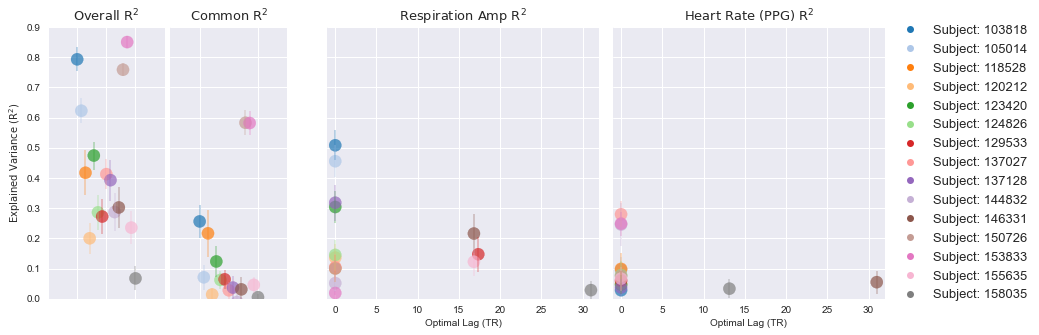

In [169]:
cmap = cm.get_cmap('tab20')
x_lag_vec = pred_lag_vec.copy()
subj_labels = [f'Subject: {subj}' for subj in subject_list_hcp.iloc[:, 0]]
c_subj = [cmap(i) for i in range(len(subj_labels))]


with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(15,5), constrained_layout=False)
    gspec = fig.add_gridspec(1,2, wspace=0.1, width_ratios=[0.3, 0.7])
    g_sub1 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gspec[0], wspace=0.05)
    g_sub2 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gspec[1], wspace=0.05)


    ax = fig.add_subplot(g_sub1[0])
    ax.scatter(np.linspace(0,2,len(full_r2_g)), full_r2_g, s=150, alpha=0.7, 
               c=c_subj, label=subj_labels)
    ax.errorbar(np.linspace(0,2,len(full_r2_g)), full_r2_g, 
                yerr=full_r2_g_e, fmt='|', alpha=0.3, ecolor=c_subj)
    ax.set_ylim([0,0.9])
    ax.set_xlim([-1,3])
    ax.grid(True)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=4, prune='upper'))
    ax.xaxis.set_ticklabels([])
    ax.set_title('Overall $R^2$', fontweight='bold', fontsize=13)
    ax.set_ylabel('Explained Variance ($R^2$)', fontsize=10)

    ax = fig.add_subplot(g_sub1[1])
    ax.scatter(np.linspace(0,2,len(common_r2_g)), common_r2_g, s=150, alpha=0.7, 
               c=c_subj, label=subj_labels)
    ax.errorbar(np.linspace(0,2,len(common_r2_g)), common_r2_g, 
                yerr=common_r2_g_e, fmt='|', alpha=0.3, ecolor=c_subj)
    ax.set_ylim([0,0.9])
    ax.set_xlim([-1,3])
    ax.grid(True)
    ax.yaxis.set_ticklabels([])
    ax.xaxis.set_ticklabels([])
    ax.set_title('Common $R^2$', fontweight='bold', fontsize=13)

    ax = fig.add_subplot(g_sub2[0])
    ax.scatter(lag_var_g['RV'], unique_r2_g['RV'], s=150, alpha=0.7,
               c=c_subj, label=subj_labels)
    ax.errorbar(lag_var_g['RV'], unique_r2_g['RV'], 
                yerr=unique_r2_g_e['RV'], fmt='|', alpha=0.3, ecolor=c_subj)
    ax.set_ylim([0,0.9])
    ax.set_xlim([-1,32])
    ax.grid(True)
    ax.yaxis.set_ticklabels([])
    ax.set_title('Respiration Amp $R^2$', fontweight='bold', fontsize=13)
    ax.set_xlabel('Optimal Lag (TR)', fontsize=10)

    ax = fig.add_subplot(g_sub2[1])
    ax.scatter(lag_var_g['PPG'], unique_r2_g['PPG'], s=150, alpha=0.7, 
               c=c_subj, label=subj_labels)
    ax.errorbar(lag_var_g['PPG'], unique_r2_g['PPG'], 
                yerr=unique_r2_g_e['PPG'], fmt='|', alpha=0.3, ecolor=c_subj)
    ax.set_ylim([0,0.9])
    ax.set_xlim([-1,32])
    ax.grid(True)
    ax.yaxis.set_ticklabels([])
    ax.set_title('Heart Rate (PPG) $R^2$', fontweight='bold', fontsize=13)
    ax.set_xlabel('Optimal Lag (TR)', fontsize=10)

    recs = []
    for i in range(0,len(c_subj)):
        recs.append(Line2D(range(1), range(1), color="white", marker='o', markerfacecolor=c_subj[i]))
    plt.legend(recs,subj_labels,loc='center left', bbox_to_anchor=(1, 0.5), fontsize=13)

    plt.show()

# 4. Signal Amplitude Analysis

## 4.1 Chang Dataset

### 4.1.1 Load Group Data

In [49]:
df_group = []
df_model_group = []
for i in range(subject_list_chang.shape[0]):
    # Load Subject
    subj, scan = subject_list_chang.iloc[i, 0], subject_list_chang.iloc[i, 1]
    sleep = subject_list_chang.iloc[i, 2]
    df = load_subj_chang(subj, scan, pc_subj_chang[f'{subj}_{scan}'], 
                     pc_v_subj_chang[f'{subj}_{scan}'], pc_p_subj_chang[f'{subj}_{scan}'],
                     clus_subj_precuneus_chang[f'{subj}_{scan}'], clus_subj_superior_parietal_chang[f'{subj}_{scan}'], 
                     fs_chang)
    # Create amplitude time series
    df['RESP_AMP_HILBERT_AMP'] = butterworth_filter(
        np.abs(hilbert(df['RESP_AMP_HILBERT'])), None, 0.01, fs=fs_chang, filter_type='lowpass'
    )
    df['PC1_AMP'] = butterworth_filter(
        np.abs(hilbert(df['pc1'])), None, 0.01, fs=fs_chang, filter_type='lowpass'
    )
    df['PC2_AMP'] = butterworth_filter(
        np.abs(hilbert(df['pc2'])), None, 0.01, fs=fs_chang, filter_type='lowpass'
    )
    df['Infraslow_AMP'] = butterworth_filter(
        np.abs(hilbert(df['Infraslow'])), None, 0.01, fs=fs_chang, filter_type='lowpass'
    )
    df['Alpha_AMP'] = butterworth_filter(
        np.abs(hilbert(df['Alpha'])), None, 0.01, fs=fs_chang, filter_type='lowpass'
    )
    df['PPG_AMP'] = butterworth_filter(
        np.abs(hilbert(df['PPG_RATE_NK'])), None, 0.01, fs=fs_chang, filter_type='lowpass'
    )
    df['CSF_AMP'] = butterworth_filter(
        np.abs(hilbert(df['csf'])), None, 0.01, fs=fs_chang, filter_type='lowpass'
    )
    # correlate vigilance and CSF AMP and PC AMP for viz
    df['corr_vigilance_CSF'] = df[['CSF_AMP', 'vigilance_at_low']].corr().iloc[0,1]
    df['corr_vigilance_PC1'] = df[['PC1_AMP', 'vigilance_at_low']].corr().iloc[0,1]
    # supply meta information
    df['subj'] = subj
    df['sleep_flag'] = sleep
    df['scan'] = scan
    df['subj_scan'] = df['subj'].astype(str) + '-' + df['scan'].astype(str)
    df_group.append(df)

df_group = pd.concat(df_group, axis=0, ignore_index=True)

### 4.1.2 Plot Amplitude Time Courses

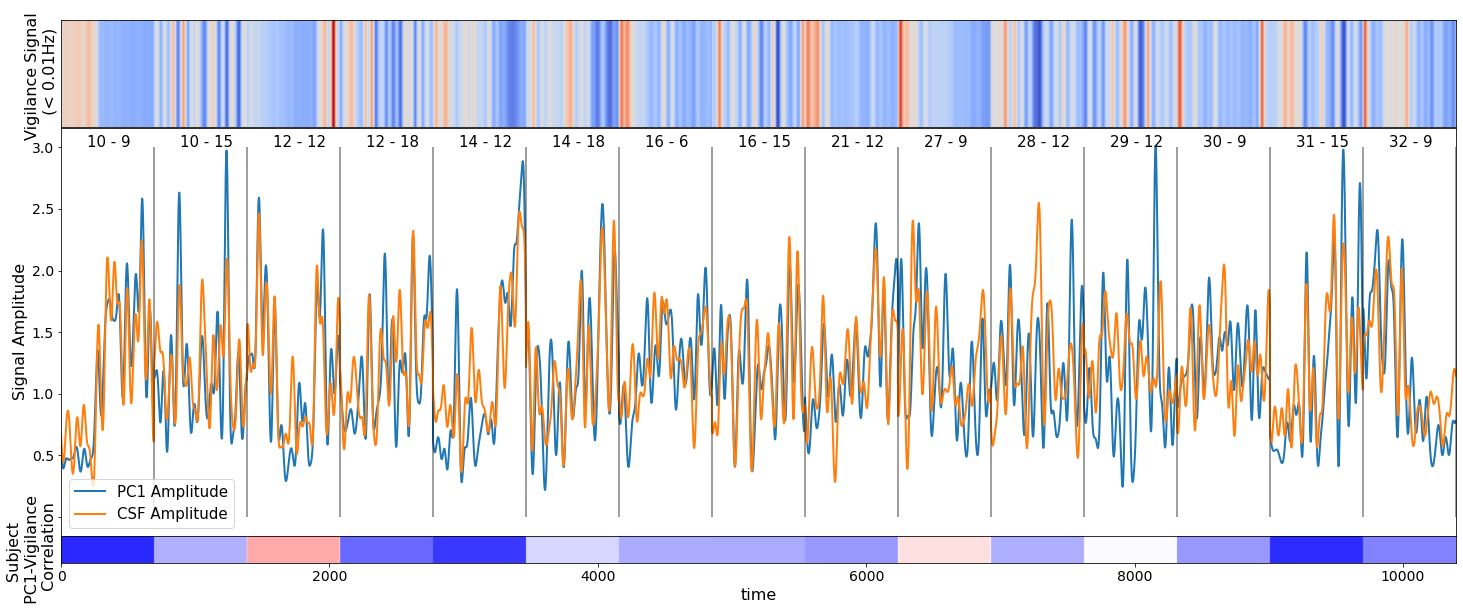

In [50]:
fig = plt.figure(figsize=(25,10), constrained_layout=False)
gspec = fig.add_gridspec(3,1, hspace=0, height_ratios=[0.2, 0.75, 0.05])
ax = fig.add_subplot(gspec[0])
im1 = ax.imshow(df_group['vigilance_ad_low'].values[np.newaxis,:], label='Vigilance', cmap='coolwarm', aspect=800)
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylabel('Vigilance Signal \n (< 0.01Hz)', fontsize=16)

ax = fig.add_subplot(gspec[1])
df_group['PC1_AMP'].plot(ax=ax, linewidth=2, label='PC1 Amplitude')
df_group['CSF_AMP'].plot(ax=ax, linewidth=2, label='CSF Amplitude')
ax.set_xlim([0, df_group.shape[0]])
ax.set_xticks([])
ax.set_ylabel('Signal Amplitude', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.setp(ax.get_yticklabels()[1], visible=False)

n = 0
for i, (subj, scan) in enumerate((zip(subject_list_chang.subject, subject_list_chang.scan))):
    n += 693
    ax.vlines(n, 0, 3, color='black', alpha=0.5)
    ax.text(n-500, 3, f'{subj} - {scan}', fontsize=15)
    
ax.legend(fontsize=15, loc='lower left')

ax = fig.add_subplot(gspec[2])
im2 = ax.imshow(df_group['corr_vigilance_PC1'].values[np.newaxis,:], label='Subject PC1-Vigilance Correlation', 
          cmap='bwr', aspect=200, vmin=-1, vmax=1)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xlabel('time', fontsize=16)
ax.set_ylabel('Subject \n PC1-Vigilance \n Correlation', fontsize=16)
ax.set_yticks([])
plt.show()

### 4.1.3 Amplitude Correlations

In [51]:
df_group[['RESP_AMP_HILBERT_AMP', 'PC1_AMP', 'PPG_AMP', 'CSF_AMP', 
          'Alpha_AMP', 'Infraslow_AMP', 'vigilance_ad_low', 'vigilance_at_low']].corr()

RESP_AMP_HILBERT_AMP   PC1_AMP   PPG_AMP   CSF_AMP  \
RESP_AMP_HILBERT_AMP              1.000000  0.513948  0.260114  0.390829   
PC1_AMP                           0.513948  1.000000  0.373660  0.722955   
PPG_AMP                           0.260114  0.373660  1.000000  0.349883   
CSF_AMP                           0.390829  0.722955  0.349883  1.000000   
Alpha_AMP                         0.303530  0.197267  0.203675  0.108107   
Infraslow_AMP                     0.246426  0.274519  0.079218  0.243462   
vigilance_ad_low                 -0.004841 -0.272539 -0.105620 -0.297737   
vigilance_at_low                 -0.121574 -0.362993 -0.136946 -0.380065   

                      Alpha_AMP  Infraslow_AMP  vigilance_ad_low  \
RESP_AMP_HILBERT_AMP   0.303530       0.246426         -0.004841   
PC1_AMP                0.197267       0.274519         -0.272539   
PPG_AMP                0.203675       0.079218         -0.105620   
CSF_AMP                0.108107       0.243462         -0.297737   
Alpha_AMP              1.000000       0.322886          0.242871   
Infraslow_AMP          0.322886       1.000000         -0.128898   
vigilance_ad_low       0.242871      -0.128898          1.000000   
vigilance_at_low       0.203662      -0.204082          0.779487   

                      vigilance_at_low  
RESP_AMP_HILBERT_AMP         -0.121574  
PC1_AMP                      -0.362993  
PPG_AMP                      -0.136946  
CSF_AMP                      -0.380065  
Alpha_AMP                     0.203662  
Infraslow_AMP                -0.204082  
vigilance_ad_low              0.779487  
vigilance_at_low              1.000000

### 4.1.4 Fit PC Amplitude-Vigilance Regression Model

In [736]:
va = sm.cov_struct.Autoregressive
sm_fit = sm.GEE(df_group['PC1_AMP'], df_group['vigilance_at_low'], 
                groups=df_group['subj']).fit()
sm_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                     PC1_AMP   No. Observations:                10395
Model:                                 GEE   No. clusters:                       11
Method:                        Generalized   Min. cluster size:                 693
                      Estimating Equations   Max. cluster size:                1386
Family:                           Gaussian   Mean cluster size:               945.0
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Tue, 19 Apr 2022   Scale:                           1.618
Covariance type:                    robust   Time:                         10:20:34
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
vigilance_at_low    -0.1850      0.047     -3.977      0.000      -0.276      -0.094
==============================================================================
Skew:                          0.6183   Kurtosis:                       0.3880
Centered skew:                 0.7243   Centered kurtosis:              0.5753
==============================================================================
"""

## 4.2 HCP Dataset

### 4.2.1 Load Group Data

In [36]:
df_group = []
for i in range(subject_list_hcp.shape[0]):
    # Load Subject
    subj = subject_list_hcp.iloc[i, 0]
    df = load_subj_hcp(subj, pc_subj_hcp[f'{subj}'], pc_v_subj_hcp[f'{subj}'], pc_p_subj_hcp[f'{subj}'],
               clus_subj_precuneus_hcp[f'{subj}'], clus_subj_superior_parietal_hcp[f'{subj}'], 
               fs_hcp, norm=True)
    # Create amplitude time series
    df['RESP_AMP_HILBERT_AMP'] = butterworth_filter(
        np.abs(hilbert(df['RESP_AMP_HILBERT'])), None, 0.01, fs=fs_hcp, filter_type='lowpass'
    )
    df['PC1_AMP'] = butterworth_filter(
        np.abs(hilbert(df['pc2_p'])), None, 0.01, fs=fs_hcp, filter_type='lowpass'
    )
    df['PPG_AMP'] = butterworth_filter(
        np.abs(hilbert(df['PPG_HR_NK'])), None, 0.01, fs=fs_hcp, filter_type='lowpass'
    )
    df['subj'] = subj
    df_group.append(df)
    
df_group = pd.concat(df_group, axis=0, ignore_index=True)

### 4.2.2 Amplitude Correlations

In [37]:
df_group[['RESP_AMP_HILBERT_AMP', 'PPG_AMP', 'PC1_AMP']].corr()

RESP_AMP_HILBERT_AMP   PPG_AMP   PC1_AMP
RESP_AMP_HILBERT_AMP              1.000000  0.407874  0.270463
PPG_AMP                           0.407874  1.000000  0.208236
PC1_AMP                           0.270463  0.208236  1.000000

# 5. Cross-Correlation Plots

## 5.1 Chang Dataset

### 5.1.1 Load Data

In [15]:
df_group = []
for i in range(subject_list_chang.shape[0]):
    # Load Subject
    subj, scan = subject_list_chang.iloc[i, 0], subject_list_chang.iloc[i, 1]
    sleep = subject_list_chang.iloc[i, 2]
    df = load_subj_chang(subj, scan, pc_subj_chang[f'{subj}_{scan}'], 
                     pc_v_subj_chang[f'{subj}_{scan}'], pc_p_subj_chang[f'{subj}_{scan}'],
                     clus_subj_precuneus_chang[f'{subj}_{scan}'], clus_subj_superior_parietal_chang[f'{subj}_{scan}'], 
                     fs_chang)
    # supply meta information
    df['subj'] = subj
    df['sleep_flag'] = sleep
    df['scan'] = scan
    df['subj_scan'] = df['subj'].astype(str) + '-' + df['scan'].astype(str)
    df_group.append(df)

df_group = pd.concat(df_group, axis=0, ignore_index=True)

### 5.1.2 Plot PC1 Cross-Correlations

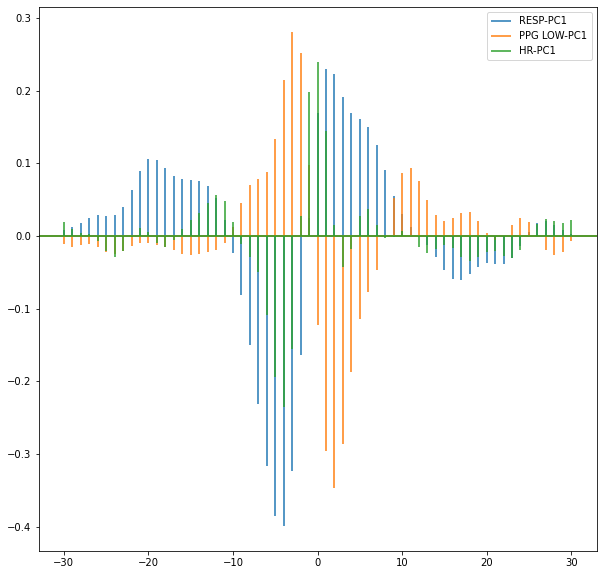

In [47]:
# PPG LOW, Heart Rate and RV
fig, ax = plt.subplots(figsize=(10,10))
cmap = cm.get_cmap('tab10')
ax.xcorr(df_group['RESP_AMP_HILBERT'], df_group['pc1'], maxlags=30, label='RESP-PC1', color=cmap(0))
ax.xcorr(df_group['PPG_LOW_NK'], df_group['pc1'], maxlags=30, label='PPG LOW-PC1', color=cmap(1))
ax.xcorr(df_group['PPG_RATE_NK'], df_group['pc1'], maxlags=30, label='HR-PC1', color=cmap(2))

ax.legend()
plt.show()

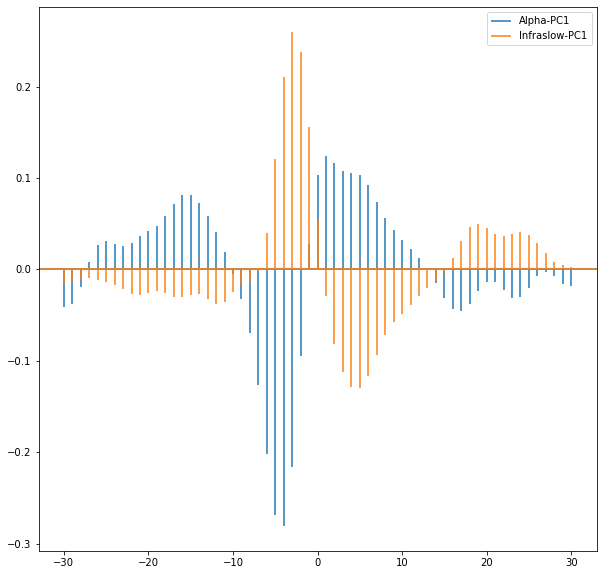

In [16]:
# Alpha and Infraslow
fig, ax = plt.subplots(figsize=(10,10))
cmap = cm.get_cmap('tab10')
ax.xcorr(df_group['Alpha'], df_group['pc1'], maxlags=30, label='Alpha-PC1', color=cmap(0))
ax.xcorr(df_group['Infraslow'], df_group['pc1'], maxlags=30, label='Infraslow-PC1', color=cmap(1))
ax.legend()
plt.show()

## 5.2 HCP Dataset

### 5.2.1 Load Data

In [120]:
df_group = []
for i in range(subject_list_hcp.shape[0]):
    # Load Subject
    subj = subject_list_hcp.iloc[i, 0]
    df = load_subj_hcp(subj, pc_subj_hcp[f'{subj}'], pc_v_subj_hcp[f'{subj}'], pc_p_subj_hcp[f'{subj}'],
               clus_subj_precuneus_hcp[f'{subj}'], clus_subj_superior_parietal_hcp[f'{subj}'], 
               fs_hcp, norm=True)
    df['subj'] = subj
    df_group.append(df)
    
df_group = pd.concat(df_group, axis=0, ignore_index=True)

### 5.2.2. Plot PC1 Cross-Correlations

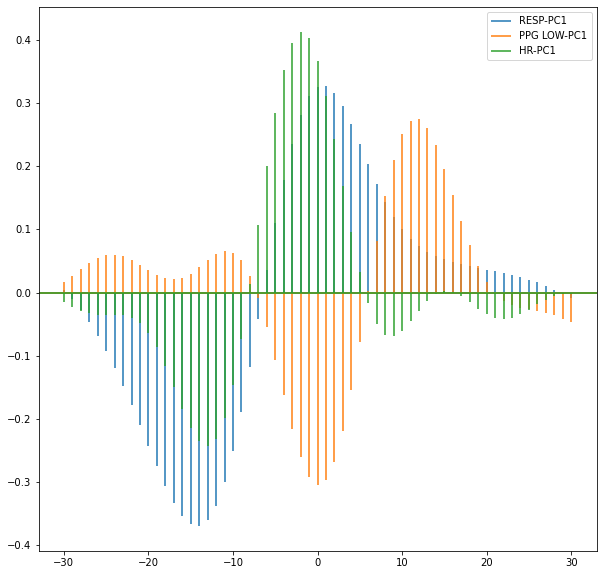

In [121]:
# PPG LOW, Heart Rate and RV
fig, ax = plt.subplots(figsize=(10,10))
cmap = cm.get_cmap('tab10')
ax.xcorr(df_group['RESP_AMP_HILBERT'], df_group['pc1'], maxlags=30, label='RESP-PC1', color=cmap(0))
ax.xcorr(df_group['PPG_LOW_NK'], df_group['pc1'], maxlags=30, label='PPG LOW-PC1', color=cmap(1))
ax.xcorr(df_group['PPG_HR_NK'], df_group['pc1'], maxlags=30, label='HR-PC1', color=cmap(2))

ax.legend()
plt.show()

# 6. Multiset CCA 

## 6.1 Chang Dataset

### 6.1.1 Load Group Data for CCA

In [28]:
df_model_group = []
for i in range(subject_list_chang.shape[0]):
    # Load Subject
    subj, scan = subject_list_chang.iloc[i, 0], subject_list_chang.iloc[i, 1]
    sleep = subject_list_chang.iloc[i, 2]
    df = load_subj_chang(subj, scan, pc_subj_chang[f'{subj}_{scan}'], 
                     pc_v_subj_chang[f'{subj}_{scan}'], pc_p_subj_chang[f'{subj}_{scan}'],
                     clus_subj_precuneus_chang[f'{subj}_{scan}'], clus_subj_superior_parietal_chang[f'{subj}_{scan}'], 
                     fs_chang)
    
    # Create a separate dataframe for modeling w/ lag splines
    lag_vec = np.arange(11)
    nknots=3
    rv_basis, lag_spline = lag_basis(df['RESP_AMP_HILBERT'], lag_vec, nknots)
    alpha_basis, lag_spline = lag_basis(df['Alpha'], lag_vec, nknots)
    infraslow_basis, lag_spline = lag_basis(df['Infraslow'], lag_vec, nknots)
    ppg_basis, lag_spline = lag_basis(df['PPG_RATE_NK'], lag_vec, nknots)
    pc_basis, lag_spline = lag_basis(df['pc1'], lag_vec, nknots)
    # pc1_basis, lag_spline = lag_basis(df['pc1_p'], lag_vec, nknots)
    # pc2_basis, lag_spline = lag_basis(df['pc2_p'], lag_vec, nknots)
    csf_basis, lag_spline = lag_basis(df['csf'], lag_vec, nknots)

    # Trim NaNs introduced from lag splines and label columns
    na_indx = ~(np.isnan(rv_basis).any(axis=1))
    df_model_rv = pd.DataFrame(zscore(rv_basis[na_indx, :]), 
                               columns = [f'RV_Knot_{i}' for i in range(nknots)])
    df_model_rv['RV'] = df['RESP_AMP_HILBERT'].loc[na_indx].values
    df_model_ppg = pd.DataFrame(zscore(ppg_basis[na_indx, :]), 
                               columns = [f'PPG_Knot_{i}' for i in range(nknots)])
    df_model_ppg['PPG'] = df['PPG_RATE_NK'].loc[na_indx].values
    df_model_pc = pd.DataFrame(zscore(pc_basis[na_indx, :]), 
                               columns = [f'PC_Knot_{i}' for i in range(nknots)])
    df_model_pc['PC1'] = df['pc1'].loc[na_indx].values
    # df_model_pc1 = pd.DataFrame(zscore(pc1_basis[na_indx, :]), 
    #                            columns = [f'PC1_Knot_{i}' for i in range(nknots)])
    # df_model_pc1['PC1_P'] = df['pc1_p'].loc[na_indx].values
    # df_model_pc2 = pd.DataFrame(zscore(pc2_basis[na_indx, :]), 
    #                            columns = [f'PC2_Knot_{i}' for i in range(nknots)])
    # df_model_pc2['PC2_P'] = df['pc2_p'].loc[na_indx].values
    df_model_inf = pd.DataFrame(zscore(infraslow_basis[na_indx, :]), 
                               columns = [f'INF_Knot_{i}' for i in range(nknots)])
    df_model_inf['INFRASLOW'] = df['Infraslow'].loc[na_indx].values
    df_model_alp = pd.DataFrame(zscore(alpha_basis[na_indx, :]), 
                               columns = [f'ALPHA_Knot_{i}' for i in range(nknots)])
    df_model_alp['ALPHA'] = df['Alpha'].loc[na_indx].values
    df_model_csf = pd.DataFrame(zscore(csf_basis[na_indx, :]), 
                               columns = [f'CSF_Knot_{i}' for i in range(nknots)])
    df_model_csf['CSF'] = df['csf'].loc[na_indx].values
    
    # Concatenate into one dataframe
    df_model = pd.concat([df_model_rv, df_model_ppg, df_model_pc, 
                          df_model_inf, df_model_alp, df_model_csf], axis=1)
    # df_model = pd.concat([df_model_rv, df_model_ppg, df_model_pc1, df_model_pc2,
    #                       df_model_inf, df_model_alp, df_model_csf], axis=1)
    # supply meta-information
    df_model['subj'] = subj
    df_model['sleep_flag'] = sleep
    df_model['scan'] = scan
    df_model_group.append(df_model)

df_model_group = pd.concat(df_model_group, axis=0, ignore_index=True)


### 6.1.2 Fit Model

In [29]:
# mcca = MCCA(latent_dims=3)
# mcca.fit([
#     df_model_group[['RV_Knot_0', 'RV_Knot_1', 'RV_Knot_2', 'RV_Knot_3']],
#     df_model_group[['PC_Knot_0', 'PC_Knot_1', 'PC_Knot_2', 'PC_Knot_3']],
#     # df_model_group[['PC1_Knot_0', 'PC1_Knot_1', 'PC1_Knot_2', 'PC1_Knot_3']],
#     # df_model_group[['PC2_Knot_0', 'PC2_Knot_1', 'PC2_Knot_2', 'PC2_Knot_3']],
#     df_model_group[['ALPHA_Knot_0', 'ALPHA_Knot_1', 'ALPHA_Knot_2', 'ALPHA_Knot_3']],
#     df_model_group[['INF_Knot_0', 'INF_Knot_1', 'INF_Knot_2', 'INF_Knot_3']],
#     df_model_group[['PPG_Knot_0', 'PPG_Knot_1', 'PPG_Knot_2', 'PPG_Knot_3']],
#     df_model_group[['CSF_Knot_0', 'CSF_Knot_1', 'CSF_Knot_2', 'CSF_Knot_3']]
# ])

mcca = MCCA(latent_dims=3)
mcca.fit([
    df_model_group[['RV_Knot_0', 'RV_Knot_1', 'RV_Knot_2']],
    df_model_group[['PC_Knot_0', 'PC_Knot_1', 'PC_Knot_2']],
    # df_model_group[['PC1_Knot_0', 'PC1_Knot_1', 'PC1_Knot_2', 'PC1_Knot_3']],
    # df_model_group[['PC2_Knot_0', 'PC2_Knot_1', 'PC2_Knot_2', 'PC2_Knot_3']],
    df_model_group[['ALPHA_Knot_0', 'ALPHA_Knot_1', 'ALPHA_Knot_2']],
    df_model_group[['INF_Knot_0', 'INF_Knot_1', 'INF_Knot_2']],
    df_model_group[['PPG_Knot_0', 'PPG_Knot_1', 'PPG_Knot_2']],
    df_model_group[['CSF_Knot_0', 'CSF_Knot_1', 'CSF_Knot_2']]
])

MCCA(c=[0, 0, 0, 0, 0, 0], latent_dims=3,
     random_state=RandomState(MT19937) at 0x7F8F3174B740)

### 6.1.3 Compute Average Correlation by Canonical Variate 

In [30]:
# mcca.score([
#     df_model_group[['RV_Knot_0', 'RV_Knot_1', 'RV_Knot_2', 'RV_Knot_3']],
#     df_model_group[['PC_Knot_0', 'PC_Knot_1', 'PC_Knot_2', 'PC_Knot_3']],
#     # df_model_group[['PC1_Knot_0', 'PC1_Knot_1', 'PC1_Knot_2', 'PC1_Knot_3']],
#     # df_model_group[['PC2_Knot_0', 'PC2_Knot_1', 'PC2_Knot_2', 'PC2_Knot_3']],
#     df_model_group[['ALPHA_Knot_0', 'ALPHA_Knot_1', 'ALPHA_Knot_2', 'ALPHA_Knot_3']],
#     df_model_group[['INF_Knot_0', 'INF_Knot_1', 'INF_Knot_2', 'INF_Knot_3']],
#     df_model_group[['PPG_Knot_0', 'PPG_Knot_1', 'PPG_Knot_2', 'PPG_Knot_3']],
#     df_model_group[['CSF_Knot_0', 'CSF_Knot_1', 'CSF_Knot_2', 'CSF_Knot_3']]
# ])

mcca.score([
    df_model_group[['RV_Knot_0', 'RV_Knot_1', 'RV_Knot_2']],
    df_model_group[['PC_Knot_0', 'PC_Knot_1', 'PC_Knot_2']],
    # df_model_group[['PC1_Knot_0', 'PC1_Knot_1', 'PC1_Knot_2', 'PC1_Knot_3']],
    # df_model_group[['PC2_Knot_0', 'PC2_Knot_1', 'PC2_Knot_2', 'PC2_Knot_3']],
    df_model_group[['ALPHA_Knot_0', 'ALPHA_Knot_1', 'ALPHA_Knot_2']],
    df_model_group[['INF_Knot_0', 'INF_Knot_1', 'INF_Knot_2']],
    df_model_group[['PPG_Knot_0', 'PPG_Knot_1', 'PPG_Knot_2']],
    df_model_group[['CSF_Knot_0', 'CSF_Knot_1', 'CSF_Knot_2']]
])

array([0.26538868, 0.26204601, 0.1230777 ])

### 6.1.4 Compute Pair-wise Correlation on First Canonical Variate

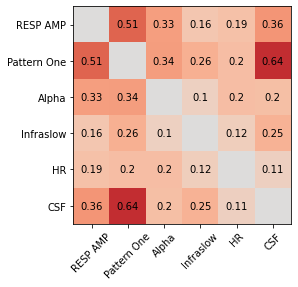

In [31]:
# corr_mat = mcca.correlations([
#     df_model_group[['RV_Knot_0', 'RV_Knot_1', 'RV_Knot_2', 'RV_Knot_3']],
#     df_model_group[['PC_Knot_0', 'PC_Knot_1', 'PC_Knot_2', 'PC_Knot_3']],
#     # df_model_group[['PC1_Knot_0', 'PC1_Knot_1', 'PC1_Knot_2', 'PC1_Knot_3']],
#     # df_model_group[['PC2_Knot_0', 'PC2_Knot_1', 'PC2_Knot_2', 'PC2_Knot_3']],
#     df_model_group[['ALPHA_Knot_0', 'ALPHA_Knot_1', 'ALPHA_Knot_2', 'ALPHA_Knot_3']],
#     df_model_group[['INF_Knot_0', 'INF_Knot_1', 'INF_Knot_2', 'INF_Knot_3']],
#     df_model_group[['PPG_Knot_0', 'PPG_Knot_1', 'PPG_Knot_2', 'PPG_Knot_3']],
#     df_model_group[['CSF_Knot_0', 'CSF_Knot_1', 'CSF_Knot_2', 'CSF_Knot_3']]
# ])

corr_mat = mcca.correlations([
    df_model_group[['RV_Knot_0', 'RV_Knot_1', 'RV_Knot_2']],
    df_model_group[['PC_Knot_0', 'PC_Knot_1', 'PC_Knot_2']],
    # df_model_group[['PC1_Knot_0', 'PC1_Knot_1', 'PC1_Knot_2', 'PC1_Knot_3']],
    # df_model_group[['PC2_Knot_0', 'PC2_Knot_1', 'PC2_Knot_2', 'PC2_Knot_3']],
    df_model_group[['ALPHA_Knot_0', 'ALPHA_Knot_1', 'ALPHA_Knot_2']],
    df_model_group[['INF_Knot_0', 'INF_Knot_1', 'INF_Knot_2']],
    df_model_group[['PPG_Knot_0', 'PPG_Knot_1', 'PPG_Knot_2']],
    df_model_group[['CSF_Knot_0', 'CSF_Knot_1', 'CSF_Knot_2']]
])

corr_mat = pd.DataFrame(corr_mat[:,:,0], columns=['RV', 'PC', 'ALPHA', 'INF', 'PPG', 'CSF'], 
                        index=[['RV', 'PC', 'ALPHA', 'INF', 'PPG', 'CSF']])
corr_mat_array = corr_mat.values
np.fill_diagonal(corr_mat_array, 0)

fig, ax = plt.subplots()
ax.imshow(corr_mat_array, vmin=-0.7, vmax=0.7, cmap='coolwarm')
ax.set_xticks(np.arange(6))
ax.set_yticks(np.arange(6))
ax.set_xticklabels(['RESP AMP', 'Pattern One', 'Alpha', 'Infraslow', 'HR', 'CSF'], rotation=45)
ax.set_yticklabels(['RESP AMP', 'Pattern One', 'Alpha', 'Infraslow', 'HR', 'CSF'])

for (j,i),label in np.ndenumerate(corr_mat):
    if i != j:
        ax.text(i,j,round(label,2),ha='center',va='center')
# pd.DataFrame(corr_mat[:,:,0], columns=['RV', 'PC1', 'PC2', 'ALPHA', 'INF', 'PPG', 'CSF'], 
             # index=[['RV', 'PC1', 'PC2', 'ALPHA', 'INF', 'PPG', 'CSF']])

### 6.1.5 Get Canonical Variate Scores and Calculate Lag

#### 6.1.5.1 Calculate Canonical Variate Scores

In [32]:
# cca_pred = mcca.transform([
#     df_model_group[['RV_Knot_0', 'RV_Knot_1', 'RV_Knot_2', 'RV_Knot_3']],
#     df_model_group[['PC_Knot_0', 'PC_Knot_1', 'PC_Knot_2', 'PC_Knot_3']],
#     # df_model_group[['PC1_Knot_0', 'PC1_Knot_1', 'PC1_Knot_2', 'PC1_Knot_3']],
#     # df_model_group[['PC2_Knot_0', 'PC2_Knot_1', 'PC2_Knot_2', 'PC2_Knot_3']],
#     df_model_group[['ALPHA_Knot_0', 'ALPHA_Knot_1', 'ALPHA_Knot_2', 'ALPHA_Knot_3']],
#     df_model_group[['INF_Knot_0', 'INF_Knot_1', 'INF_Knot_2', 'INF_Knot_3']],
#     df_model_group[['PPG_Knot_0', 'PPG_Knot_1', 'PPG_Knot_2', 'PPG_Knot_3']],
#     df_model_group[['CSF_Knot_0', 'CSF_Knot_1', 'CSF_Knot_2', 'CSF_Knot_3']]

# ])

cca_pred = mcca.transform([
    df_model_group[['RV_Knot_0', 'RV_Knot_1', 'RV_Knot_2']],
    df_model_group[['PC_Knot_0', 'PC_Knot_1', 'PC_Knot_2']],
    # df_model_group[['PC1_Knot_0', 'PC1_Knot_1', 'PC1_Knot_2', 'PC1_Knot_3']],
    # df_model_group[['PC2_Knot_0', 'PC2_Knot_1', 'PC2_Knot_2', 'PC2_Knot_3']],
    df_model_group[['ALPHA_Knot_0', 'ALPHA_Knot_1', 'ALPHA_Knot_2']],
    df_model_group[['INF_Knot_0', 'INF_Knot_1', 'INF_Knot_2']],
    df_model_group[['PPG_Knot_0', 'PPG_Knot_1', 'PPG_Knot_2']],
    df_model_group[['CSF_Knot_0', 'CSF_Knot_1', 'CSF_Knot_2']]
])

#### 6.1.5.2 Plot Canonical Variate Scores

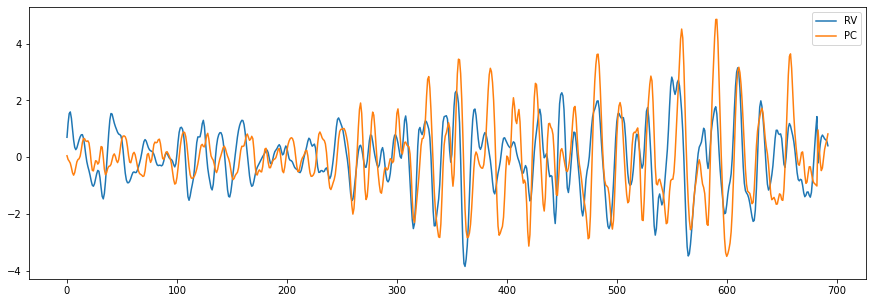

In [33]:
cmap = cm.get_cmap('tab10')
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(cca_pred[0][:693,0], label='RV', color=cmap(0))
ax.plot(cca_pred[1][:693,0], label='PC', color=cmap(1))
# ax.plot(cca_pred[2][:693,0], label='Alpha')
# ax.plot(cca_pred[2][:693,0], label='Infraslow')
# ax.plot(cca_pred[4][1500:3000,0], label='PPG')

ax.legend()

#### 6.1.5.3 Plot Lags on First Canonical Variate

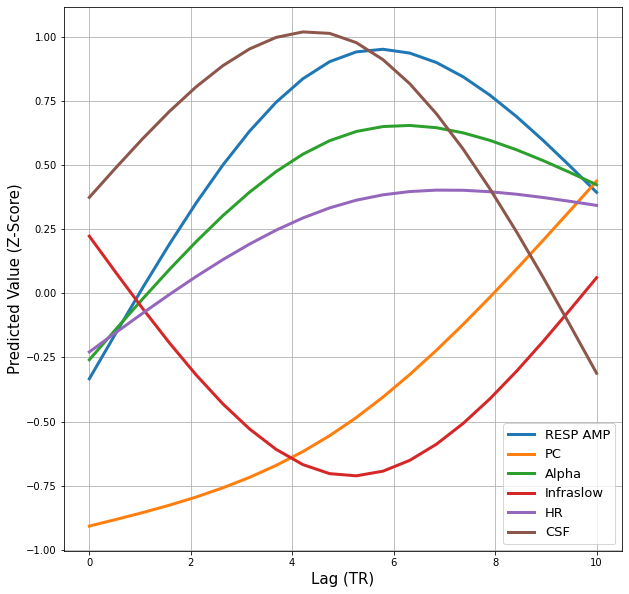

In [34]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
lag_vec = np.linspace(0, 10, 20)
var_eval = 1
# Create basis from model evaluation using previously defined design matrix (for model fit)
basis_lag_pred = dmatrix(lag_spline.design_info, {'x': lag_vec}, return_type='dataframe')
 # Intialize basis matrix
pred_list = [var_eval * basis_lag_pred.iloc[:, l].values for l in range(basis_lag_pred.shape[1])]
pred_mat = np.vstack(pred_list).T
# Get predictions from model
cmap = cm.get_cmap('tab10')
labels = ['RESP AMP', 'PC', 'Alpha', 'Infraslow', 'HR', 'CSF']
for i, l in enumerate(labels):
    pred_lag = np.dot(pred_mat, mcca.weights[i][:,0])
    ax.plot(lag_vec, pred_lag, label=l, color=cmap(i), linewidth=3)
    # if l in ['PC', 'Infraslow']:
    #     l_loc = np.argmax(-pred_lag)
    # else:
    #     l_loc = np.argmax(pred_lag)
    # ax.vlines(lag_vec[l_loc], -1, 0.75, color=cmap(i), linestyle='--', alpha=0.5)
        

ax.legend(fontsize=13)
ax.set_xlabel('Lag (TR)', fontsize=15)
ax.set_ylabel('Predicted Value (Z-Score)', fontsize=15)

ax.grid(True)


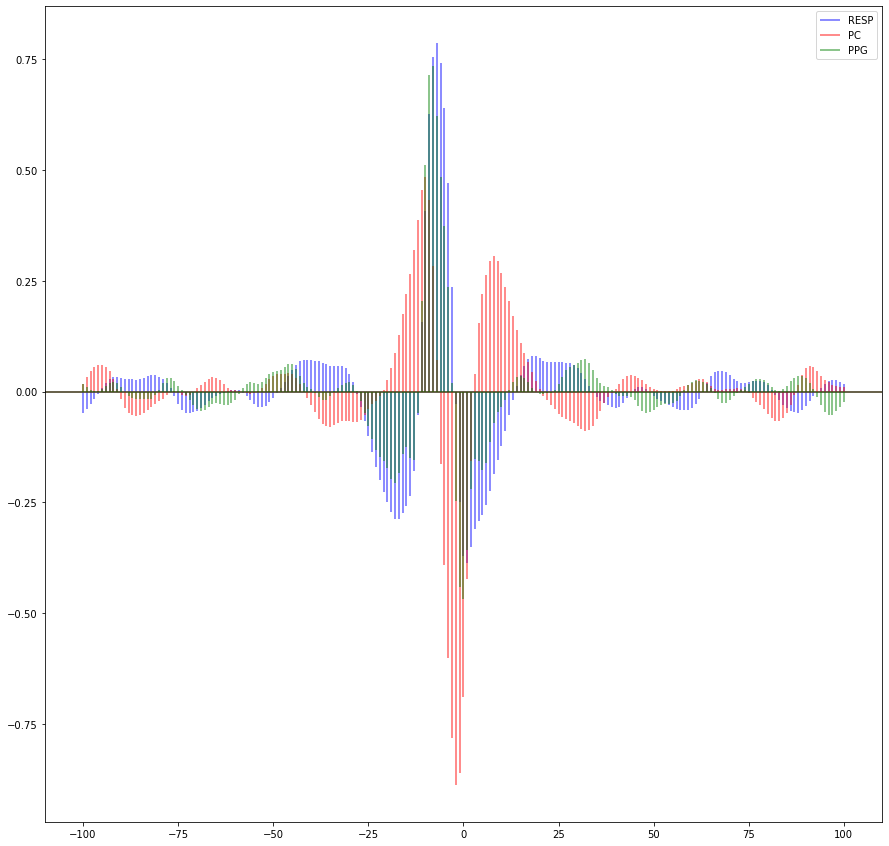

In [181]:
fig, ax = plt.subplots(1,1,figsize=(15,15))
ax.xcorr(df_model_group['RV'], cca_pred[0][:,0], color='b', alpha=0.6, maxlags=100, label='RESP')
ax.xcorr(df_model_group['PC1'], cca_pred[1][:,0], color='r', alpha=0.6, maxlags=100, label='PC')
# ax.xcorr(df_model_group['PC1_P'], cca_pred[1][:,0], color='r', alpha=0.6, maxlags=100, label='PC1')
# ax.xcorr(df_model_group['PC2_P'], cca_pred[2][:,0], color='c', alpha=0.6, maxlags=100, label='PC2')
ax.xcorr(df_model_group['PPG'], cca_pred[4][:,0], color='g', alpha=0.6, maxlags=100, label='PPG')
ax.legend()

## 6.2 HCP Dataset

### 6.2.1 Load Group Data for CCA

In [183]:
df_model_group = []
for i in range(subject_list_hcp.shape[0]):
    # Load Subject
    subj = subject_list_hcp.iloc[i, 0]
    df = load_subj_hcp(subj, pc_subj_hcp[f'{subj}'], pc_v_subj_hcp[f'{subj}'], pc_p_subj_hcp[f'{subj}'],
               clus_subj_precuneus_hcp[f'{subj}'], clus_subj_superior_parietal_hcp[f'{subj}'], 
               fs_hcp, norm=True)
    
    # Create a separate dataframe for modeling w/ lag splines
    lag_vec = np.arange(31)
    nknots=3
    rv_basis, lag_spline = lag_basis(df['RESP_AMP_HILBERT'], lag_vec, nknots)
    ppg_basis, lag_spline = lag_basis(df['PPG_HR_NK'], lag_vec, nknots)
    pc_basis, lag_spline = lag_basis(df['pc1'], lag_vec, nknots)
    csf_basis, lag_spline = lag_basis(df['csf'], lag_vec, nknots)
    # pc1_basis, lag_spline = lag_basis(df['pc1_p'], lag_vec, nknots)
    # pc2_basis, lag_spline = lag_basis(df['pc2_p'], lag_vec, nknots)



    # Trim NaNs introduced from lag splines and label columns
    na_indx = ~(np.isnan(rv_basis).any(axis=1))
    df_model_rv = pd.DataFrame(zscore(rv_basis[na_indx, :]), 
                               columns = [f'RV_Knot_{i}' for i in range(nknots)])
    df_model_rv['RV'] = df['RESP_AMP_HILBERT'].loc[na_indx].values
    df_model_ppg = pd.DataFrame(zscore(ppg_basis[na_indx, :]), 
                               columns = [f'PPG_Knot_{i}' for i in range(nknots)])
    df_model_ppg['PPG'] = df['PPG_HR_NK'].loc[na_indx].values
    df_model_pc1 = pd.DataFrame(zscore(pc_basis[na_indx, :]), 
                               columns = [f'PC_Knot_{i}' for i in range(nknots)])
    df_model_pc1['PC1'] = df['pc1'].loc[na_indx].values
    df_model_csf = pd.DataFrame(zscore(csf_basis[na_indx, :]), 
                               columns = [f'CSF_Knot_{i}' for i in range(nknots)])
    df_model_csf['CSF'] = df['csf'].loc[na_indx].values
    # df_model_pc1 = pd.DataFrame(zscore(pc1_basis[na_indx, :]), 
    #                            columns = [f'PC1_Knot_{i}' for i in range(nknots)])
    # df_model_pc1['PC1_P'] = df['pc1_p'].loc[na_indx].values
    # df_model_pc2 = pd.DataFrame(zscore(pc2_basis[na_indx, :]), 
    #                            columns = [f'PC2_Knot_{i}' for i in range(nknots)])
    # df_model_pc1['PC2_P'] = df['pc2_p'].loc[na_indx].values
    
    # Concatenate into one dataframe
    df_model = pd.concat([df_model_rv, df_model_ppg, df_model_pc1, df_model_csf], axis=1)
    # df_model = pd.concat([df_model_rv, df_model_ppg, df_model_pc1, df_model_pc2], axis=1)

    # supply meta-information
    df_model['subj'] = subj
    df_model_group.append(df_model)

df_model_group = pd.concat(df_model_group, axis=0, ignore_index=True)

### 6.2.2 Fit Model

In [184]:
mcca = MCCA(latent_dims=3)
# mcca.fit([
#     df_model_group[['RV_Knot_0', 'RV_Knot_1', 'RV_Knot_2', 'RV_Knot_3']],
#     df_model_group[['PC_Knot_0', 'PC_Knot_1', 'PC_Knot_2', 'PC_Knot_3']],
#     # df_model_group[['PC1_Knot_0', 'PC1_Knot_1', 'PC1_Knot_2', 'PC1_Knot_3']],
#     # df_model_group[['PC2_Knot_0', 'PC2_Knot_1', 'PC2_Knot_2', 'PC2_Knot_3']],
#     df_model_group[['PPG_Knot_0', 'PPG_Knot_1', 'PPG_Knot_2', 'PPG_Knot_3']],
#     df_model_group[['CSF_Knot_0', 'CSF_Knot_1', 'CSF_Knot_2', 'CSF_Knot_3']]
# ])

mcca.fit([
    df_model_group[['RV_Knot_0', 'RV_Knot_1', 'RV_Knot_2']],
    df_model_group[['PC_Knot_0', 'PC_Knot_1', 'PC_Knot_2']],
    # df_model_group[['PC1_Knot_0', 'PC1_Knot_1', 'PC1_Knot_2', 'PC1_Knot_3']],
    # df_model_group[['PC2_Knot_0', 'PC2_Knot_1', 'PC2_Knot_2', 'PC2_Knot_3']],
    df_model_group[['PPG_Knot_0', 'PPG_Knot_1', 'PPG_Knot_2']],
    df_model_group[['CSF_Knot_0', 'CSF_Knot_1', 'CSF_Knot_2']]
])

MCCA(c=[0, 0, 0, 0], latent_dims=3,
     random_state=RandomState(MT19937) at 0x7FE1184BB740)

### 6.2.3 Compute Average Correlation by Canonical Variate 

In [185]:
# mcca.score([
#     df_model_group[['RV_Knot_0', 'RV_Knot_1', 'RV_Knot_2', 'RV_Knot_3']],
#     df_model_group[['PC_Knot_0', 'PC_Knot_1', 'PC_Knot_2', 'PC_Knot_3']],
#     # df_model_group[['PC1_Knot_0', 'PC1_Knot_1', 'PC1_Knot_2', 'PC1_Knot_3']],
#     # df_model_group[['PC2_Knot_0', 'PC2_Knot_1', 'PC2_Knot_2', 'PC2_Knot_3']],
#     df_model_group[['PPG_Knot_0', 'PPG_Knot_1', 'PPG_Knot_2', 'PPG_Knot_3']],
#     df_model_group[['CSF_Knot_0', 'CSF_Knot_1', 'CSF_Knot_2', 'CSF_Knot_3']]
# ])

mcca.score([
    df_model_group[['RV_Knot_0', 'RV_Knot_1', 'RV_Knot_2']],
    df_model_group[['PC_Knot_0', 'PC_Knot_1', 'PC_Knot_2']],
    # df_model_group[['PC1_Knot_0', 'PC1_Knot_1', 'PC1_Knot_2', 'PC1_Knot_3']],
    # df_model_group[['PC2_Knot_0', 'PC2_Knot_1', 'PC2_Knot_2', 'PC2_Knot_3']],
    df_model_group[['PPG_Knot_0', 'PPG_Knot_1', 'PPG_Knot_2']],
    df_model_group[['CSF_Knot_0', 'CSF_Knot_1', 'CSF_Knot_2']]
])

array([0.32917241, 0.29539932, 0.17639639])

### 6.2.4 Compute Pair-wise Correlation on First Canonical Variate

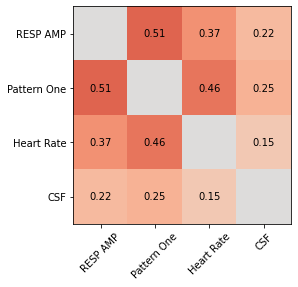

In [186]:
# corr_mat = mcca.correlations([
#     df_model_group[['RV_Knot_0', 'RV_Knot_1', 'RV_Knot_2', 'RV_Knot_3']],
#     df_model_group[['PC_Knot_0', 'PC_Knot_1', 'PC_Knot_2', 'PC_Knot_3']],
#     # df_model_group[['PC1_Knot_0', 'PC1_Knot_1', 'PC1_Knot_2', 'PC1_Knot_3']],
#     # df_model_group[['PC2_Knot_0', 'PC2_Knot_1', 'PC2_Knot_2', 'PC2_Knot_3']],
#     df_model_group[['PPG_Knot_0', 'PPG_Knot_1', 'PPG_Knot_2', 'PPG_Knot_3']],
#     df_model_group[['CSF_Knot_0', 'CSF_Knot_1', 'CSF_Knot_2', 'CSF_Knot_3']]
# ])

corr_mat = mcca.correlations([
    df_model_group[['RV_Knot_0', 'RV_Knot_1', 'RV_Knot_2']],
    df_model_group[['PC_Knot_0', 'PC_Knot_1', 'PC_Knot_2']],
    # df_model_group[['PC1_Knot_0', 'PC1_Knot_1', 'PC1_Knot_2', 'PC1_Knot_3']],
    # df_model_group[['PC2_Knot_0', 'PC2_Knot_1', 'PC2_Knot_2', 'PC2_Knot_3']],
    df_model_group[['PPG_Knot_0', 'PPG_Knot_1', 'PPG_Knot_2']],
    df_model_group[['CSF_Knot_0', 'CSF_Knot_1', 'CSF_Knot_2']]
])

corr_mat = pd.DataFrame(corr_mat[:,:,0], columns=['RV', 'PC', 'PPG', 'CSF'], index=['RV', 'PC', 'PPG', 'CSF'])
# pd.DataFrame(corr_mat[:,:,0], columns=['RV', 'PC1', 'PC2', 'PPG'], index=['RV', 'PC1', 'PC2', 'PPG'])

corr_mat_array = corr_mat.values
np.fill_diagonal(corr_mat_array, 0)

fig, ax = plt.subplots()
ax.imshow(corr_mat_array, vmin=-0.7, vmax=0.7, cmap='coolwarm')
ax.set_xticks(np.arange(4))
ax.set_yticks(np.arange(4))
ax.set_xticklabels(['RESP AMP', 'Pattern One', 'Heart Rate', 'CSF'], rotation=45)
ax.set_yticklabels(['RESP AMP', 'Pattern One', 'Heart Rate', 'CSF'])

for (j,i),label in np.ndenumerate(corr_mat):
    if i != j:
        ax.text(i,j,round(label,2),ha='center',va='center')

### 6.2.5 Get Canonical Variate Scores and Calculate Lag

#### 6.2.5.1 Calculate Canonical Variate Scores

In [187]:
# cca_pred = mcca.transform([
#     df_model_group[['RV_Knot_0', 'RV_Knot_1', 'RV_Knot_2', 'RV_Knot_3']],
#     df_model_group[['PC_Knot_0', 'PC_Knot_1', 'PC_Knot_2', 'PC_Knot_3']],
#     # df_model_group[['PC1_Knot_0', 'PC1_Knot_1', 'PC1_Knot_2', 'PC1_Knot_3']],
#     # df_model_group[['PC2_Knot_0', 'PC2_Knot_1', 'PC2_Knot_2', 'PC2_Knot_3']],
#     df_model_group[['PPG_Knot_0', 'PPG_Knot_1', 'PPG_Knot_2', 'PPG_Knot_3']],    
#     df_model_group[['CSF_Knot_0', 'CSF_Knot_1', 'CSF_Knot_2', 'CSF_Knot_3']]
# ])

cca_pred = mcca.transform([
    df_model_group[['RV_Knot_0', 'RV_Knot_1', 'RV_Knot_2']],
    df_model_group[['PC_Knot_0', 'PC_Knot_1', 'PC_Knot_2']],
    # df_model_group[['PC1_Knot_0', 'PC1_Knot_1', 'PC1_Knot_2', 'PC1_Knot_3']],
    # df_model_group[['PC2_Knot_0', 'PC2_Knot_1', 'PC2_Knot_2', 'PC2_Knot_3']],
    df_model_group[['PPG_Knot_0', 'PPG_Knot_1', 'PPG_Knot_2']],    
    df_model_group[['CSF_Knot_0', 'CSF_Knot_1', 'CSF_Knot_2']]
])

#### 6.2.5.2 Plot Canonical Variate Scores

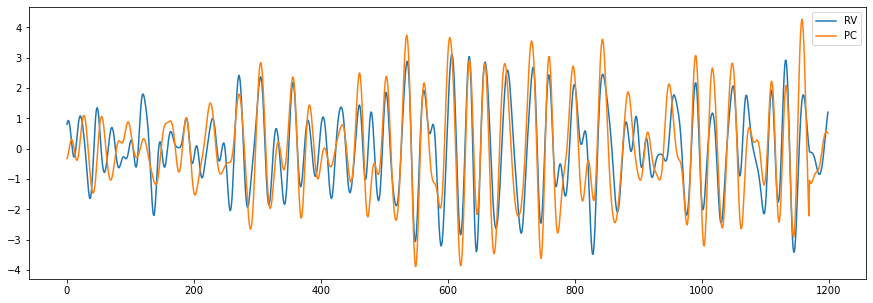

In [188]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(cca_pred[0][:1200,0], label='RV')
ax.plot(cca_pred[1][:1200,0], label='PC')
# ax.plot(cca_pred[1][3000:5000,0], label='PC1')
# ax.plot(cca_pred[2][3000:5000,0], label='PC2')
# ax.plot(cca_pred[2][:1200,0], label='PPG')
# ax.plot(cca_pred[3][:1200,0], label='CSF')

ax.legend()

#### 6.2.5.3 Plot Lags on First Canonical Variate

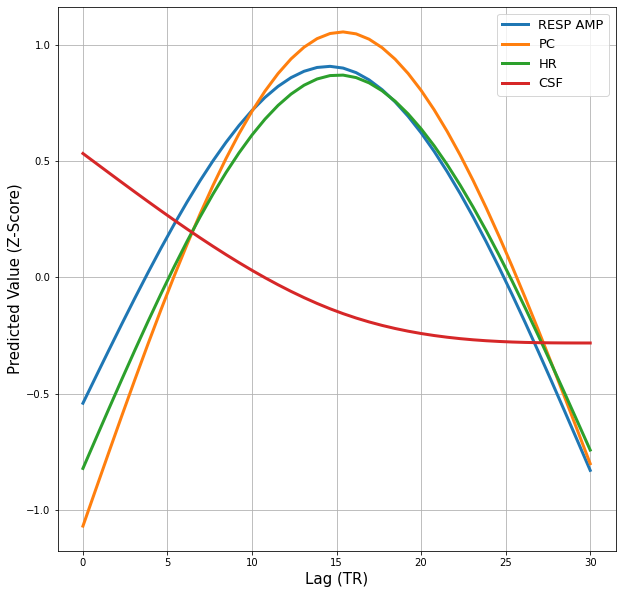

In [189]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
lag_vec = np.linspace(0, 30, 40)
var_eval = 1
# Create basis from model evaluation using previously defined design matrix (for model fit)
basis_lag_pred = dmatrix(lag_spline.design_info, {'x': lag_vec}, return_type='dataframe')
 # Intialize basis matrix
pred_list = [var_eval * basis_lag_pred.iloc[:, l].values for l in range(basis_lag_pred.shape[1])]
pred_mat = np.vstack(pred_list).T

# Get predictions from model
cmap = cm.get_cmap('tab10')
labels = ['RESP AMP', 'PC', 'HR', 'CSF']
for i, l in enumerate(labels):
    pred_lag = np.dot(pred_mat, mcca.weights[i][:,0])
    ax.plot(lag_vec, pred_lag, label=l, color=cmap(i), linewidth=3)
#     if l == 'CSF':
#         l_loc = np.argmax(-pred_lag)
#     else:
#         l_loc = np.argmax(pred_lag)
#     ax.vlines(lag_vec[l_loc], -1, 0.8, color=cmap(i), linestyle='--', alpha=0.5)
        

ax.legend(fontsize=13)
ax.set_xlabel('Lag (TR)', fontsize=15)
ax.set_ylabel('Predicted Value (Z-Score)', fontsize=15)

ax.grid(True)


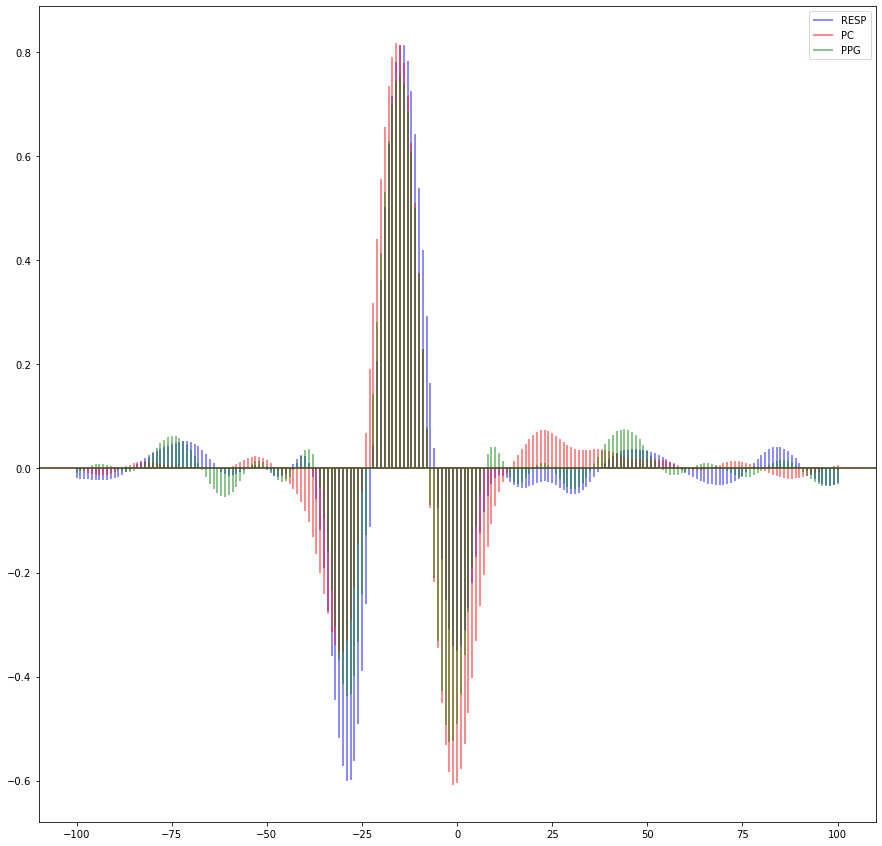

In [190]:
fig, ax = plt.subplots(1,1,figsize=(15,15))
ax.xcorr(df_model_group['RV'], cca_pred[0][:,0], color='b', alpha=0.6, maxlags=100, label='RESP')
ax.xcorr(df_model_group['PC1'], cca_pred[1][:,0], color='r', alpha=0.6, maxlags=100, label='PC')
# ax.xcorr(df_model_group['PC1_P'], cca_pred[1][:,0], color='r', alpha=0.6, maxlags=100, label='PC1')
# ax.xcorr(df_model_group['PC2_P'], cca_pred[2][:,0], color='c', alpha=0.6, maxlags=100, label='PC2')
ax.xcorr(df_model_group['PPG'], cca_pred[2][:,0], color='g', alpha=0.6, maxlags=100, label='PPG')
ax.legend()

# 7. Group Regression Analysis

## 7.1 Chang Dataset

### 7.1.1 Load Data for Regression Analysis

In [36]:
df_model_group = []
for i in range(subject_list_chang.shape[0]):
    # Load Subject
    subj, scan = subject_list_chang.iloc[i, 0], subject_list_chang.iloc[i, 1]
    sleep = subject_list_chang.iloc[i, 2]
    df = load_subj_chang(subj, scan, pc_subj_chang[f'{subj}_{scan}'], 
                     pc_v_subj_chang[f'{subj}_{scan}'], pc_p_subj_chang[f'{subj}_{scan}'],
                     clus_subj_precuneus_chang[f'{subj}_{scan}'], clus_subj_superior_parietal_chang[f'{subj}_{scan}'], 
                     fs_chang)
    # Create lag spline regressors
    lag_vec = np.arange(11)
    nknots=3
    rv_basis, lag_spline = lag_basis(df['RESP_AMP_HILBERT'], lag_vec, nknots)
    alpha_basis, lag_spline = lag_basis(df['Alpha'], lag_vec, nknots)
    delta_basis, lag_spline = lag_basis(df['Delta'], lag_vec, nknots)
    theta_basis, lag_spline = lag_basis(df['Theta'], lag_vec, nknots)
    infraslow_basis, lag_spline = lag_basis(df['Infraslow'], lag_vec, nknots)
    ppg_basis, lag_spline = lag_basis(df['PPG_RATE_NK'], lag_vec, nknots)
    pc_basis, lag_spline = lag_basis(df['pc1'], lag_vec, nknots)
    

    # Trim NaNs introduced by lag splines
    na_indx = ~(np.isnan(rv_basis).any(axis=1))
    df_model_rv = pd.DataFrame(zscore(rv_basis[na_indx, :]), 
                               columns = [f'RV_Knot_{i}' for i in range(nknots)])
    df_model_rv['RV'] = df['RESP_AMP_HILBERT'].loc[na_indx].values
    df_model_ppg = pd.DataFrame(zscore(ppg_basis[na_indx, :]), 
                               columns = [f'PPG_Knot_{i}' for i in range(nknots)])
    df_model_ppg['PPG'] = df['PPG_RATE_NK'].loc[na_indx].values
    df_model_inf = pd.DataFrame(zscore(infraslow_basis[na_indx, :]), 
                               columns = [f'INF_Knot_{i}' for i in range(nknots)])
    df_model_inf['INFRASLOW'] = df['Infraslow'].loc[na_indx].values
    df_model_alp = pd.DataFrame(zscore(alpha_basis[na_indx, :]), 
                               columns = [f'ALPHA_Knot_{i}' for i in range(nknots)])
    df_model_alp['ALPHA'] = df['Alpha'].loc[na_indx].values
    df_model_delta = pd.DataFrame(zscore(delta_basis[na_indx, :]), 
                               columns = [f'DELTA_Knot_{i}' for i in range(nknots)])
    df_model_delta['DELTA'] = df['Delta'].loc[na_indx].values
    df_model_theta = pd.DataFrame(zscore(theta_basis[na_indx, :]), 
                               columns = [f'THETA_Knot_{i}' for i in range(nknots)])
    df_model_delta['THETA'] = df['Theta'].loc[na_indx].values
    df_model_pc1 = pd.DataFrame(zscore(pc_basis[na_indx, :]), 
                               columns = [f'PC_Knot_{i}' for i in range(nknots)])
    df_model = pd.concat([df_model_rv, df_model_ppg, df_model_pc1, 
                          df_model_inf, df_model_alp, df_model_delta, 
                          df_model_theta], axis=1)
    # supply meta-information
    df_model['subj'] = subj
    df_model['sleep_flag'] = sleep
    df_model['scan'] = scan
    df_model['pc1'] = df['pc1'].loc[na_indx].values
    df_model['pc2'] = df['pc2'].loc[na_indx].values
    df_model['pc3'] = df['pc3'].loc[na_indx].values
    df_model['pc1_p'] = df['pc1_p'].loc[na_indx].values
    df_model['pc2_p'] = df['pc2_p'].loc[na_indx].values
    df_model['pc3_p'] = df['pc3_p'].loc[na_indx].values
    df_model['csf'] = df['csf'].loc[na_indx].values
    df_model['vigilance_at'] = df['vigilance_at_low'].loc[na_indx].values
    df_model_group.append(df_model)

df_model_group = pd.concat(df_model_group, axis=0, ignore_index=True)

### 7.1.2 Fit Full Group Regression Model

#### 7.1.2.1 Fit Model

In [25]:
pred_list = [
    df_model_group[['RV_Knot_0', 'RV_Knot_1', 'RV_Knot_2']],
    df_model_group[['PPG_Knot_0', 'PPG_Knot_1', 'PPG_Knot_2']],
    df_model_group[['INF_Knot_0', 'INF_Knot_1', 'INF_Knot_2']],
    df_model_group[['ALPHA_Knot_0', 'ALPHA_Knot_1', 'ALPHA_Knot_2']]
]
    
pred_label = ['RV', 'PPG', 'Infraslow', 'Alpha']
pc_norm = zscore(df_model_group['pc1'])

full_pred = pd.concat(pred_list, axis=1)

va = sm.cov_struct.Autoregressive()
sm_fit_full = sm.GEE(pc_norm, full_pred, groups=df_model_group.subj, cov_struct=va).fit()
sm_fit_full.summary()

/Users/taylorbolt/opt/miniconda3/lib/python3.8/site-packages/statsmodels/genmod/cov_struct.py:796: FutureWarning: grid=True will become default in a future version
  warnings.warn(
/Users/taylorbolt/opt/miniconda3/lib/python3.8/site-packages/statsmodels/genmod/generalized_estimating_equations.py:1293: IterationLimitWarning: Iteration limit reached prior to convergence
  warnings.warn("Iteration limit reached prior to convergence",


<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                         pc1   No. Observations:                10245
Model:                                 GEE   No. clusters:                       11
Method:                        Generalized   Min. cluster size:                 683
                      Estimating Equations   Max. cluster size:                1366
Family:                           Gaussian   Mean cluster size:               931.4
Dependence structure:       Autoregressive   Num. iterations:                    60
Date:                     Sun, 29 May 2022   Scale:                           0.695
Covariance type:                    robust   Time:                         11:24:01
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
RV_Knot_0        0.0667      0.038      1.769      0.077      -0.007       0.141
RV_Knot_1       -0.3687      0.029    -12.801      0.000      -0.425      -0.312
RV_Knot_2       -0.0165      0.032     -0.511      0.610      -0.080       0.047
PPG_Knot_0       0.2583      0.049      5.248      0.000       0.162       0.355
PPG_Knot_1      -0.1147      0.038     -2.980      0.003      -0.190      -0.039
PPG_Knot_2       0.0905      0.026      3.490      0.000       0.040       0.141
INF_Knot_0       0.1520      0.041      3.683      0.000       0.071       0.233
INF_Knot_1       0.0685      0.024      2.800      0.005       0.021       0.116
INF_Knot_2       0.0024      0.021      0.114      0.909      -0.039       0.044
ALPHA_Knot_0     0.0181      0.021      0.851      0.395      -0.024       0.060
ALPHA_Knot_1    -0.1675      0.034     -4.987      0.000      -0.233      -0.102
ALPHA_Knot_2     0.0382      0.023      1.671      0.095      -0.007       0.083
==============================================================================
Skew:                         -0.0485   Kurtosis:                       0.8144
Centered skew:                -0.0490   Centered kurtosis:              0.8141
==============================================================================
"""

#### 7.1.2.2 Plot Model Parameters

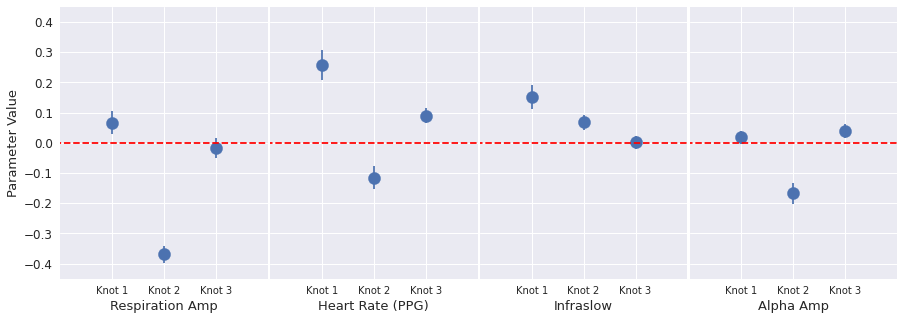

In [26]:
param_labels = [
    ['RV_Knot_0', 'RV_Knot_1', 'RV_Knot_2'],
    ['PPG_Knot_0', 'PPG_Knot_1', 'PPG_Knot_2'],
    ['INF_Knot_0', 'INF_Knot_1', 'INF_Knot_2'],
    ['ALPHA_Knot_0', 'ALPHA_Knot_1', 'ALPHA_Knot_2']
]
label_group = ['Respiration Amp', 'Heart Rate (PPG)', 'Infraslow', 'Alpha Amp']
param_dict = sm_fit_full.params.to_dict()
se_dict = {l: se for l, se in zip(sm_fit_full.params.index, sm_fit_full.standard_errors())}
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(15,5), constrained_layout=False)
    gspec = fig.add_gridspec(1,4, wspace=0.01)
    for i, (labels, g_label) in enumerate(zip(param_labels, label_group)):
        ax = fig.add_subplot(gspec[i])
        param_vec = [param_dict[l] for l in labels]
        se_vec = [se_dict[l] for l in labels]
        scatter = ax.scatter(np.arange(3), param_vec, s=150)
        ax.errorbar(np.arange(3), param_vec, yerr=se_vec, fmt='|')
        ax.set_xlabel(g_label, fontsize=13)
        ax.set_ylim([-0.45,0.45])
        ax.set_xlim([-1,3])
        ax.axhline(0,-1,4, linestyle='--', c='r',)
        ax.xaxis.set_major_locator(MaxNLocator(nbins=4, prune='both'))
        ax.xaxis.set_ticks([0,1,2])
        ax.set_xticklabels(['Knot 1' , 'Knot 2', 'Knot 3'])
        if i == 0:
            ax.tick_params(axis='y', labelsize=12)
            ax.set_ylabel('Parameter Value', fontsize=13)
        else:
            ax.yaxis.set_ticklabels([])
        ax.grid(True)

### 7.1.3 Perform Commonality Analysis

In [40]:
pred_list = [
    df_model_group[['RV_Knot_0', 'RV_Knot_1', 'RV_Knot_2']],
    df_model_group[['PPG_Knot_0', 'PPG_Knot_1', 'PPG_Knot_2']],
    df_model_group[['INF_Knot_0', 'INF_Knot_1', 'INF_Knot_2']],
    df_model_group[['ALPHA_Knot_0', 'ALPHA_Knot_1', 'ALPHA_Knot_2']]
]
    
pred_label = ['RV', 'PPG', 'Infraslow', 'Alpha']
pc_norm = zscore(df_model_group['pc3_p'])

full_pred = pd.concat(pred_list, axis=1)

sm_fit = sm.OLS(pc_norm, full_pred, hasconst=False).fit()
full_r2 = sm_fit.rsquared
common_r2 = full_r2.copy()
unique_r2 = {}
for i, label in enumerate(pred_label):
    partial_pred = pd.concat([pred for n, pred in enumerate(pred_list) if n != i], axis=1)
    sm_fit_partial = sm.OLS(pc_norm, partial_pred, hasconst=False).fit()
    unique_r2[label] = full_r2 - sm_fit_partial.rsquared
    common_r2 -= unique_r2[label]

print(f'Full R2: {full_r2}')
print(f'Unique R2: {unique_r2}')
print(f'Common R2: {common_r2}')

Full R2: 0.24022089428313964
Unique R2: {'RV': 0.09650116602234471, 'PPG': 0.046014873151664304, 'Infraslow': 0.012129613847414067, 'Alpha': 0.010510957703640633}
Common R2: 0.07506428355807593


### 7.1.4 Fit RV and Vigilance Model - Pattern One

#### 7.1.4.1 Fit Model

In [30]:
full_pred = df_model_group[['RV_Knot_0', 'RV_Knot_1', 'RV_Knot_2']]
test = [full_pred.iloc[:,i].values*df_model_group['vigilance_at'].values for i in range(full_pred.shape[1])]
test_df = pd.DataFrame(test, index=[f'{col}_i' for col in full_pred.columns]).T

full_pred_i = pd.concat([full_pred, test_df], axis=1)
full_pred_i['vigilance'] = df_model_group['vigilance_at'].values

pc_norm = zscore(df_model_group['pc1'])

va = sm.cov_struct.Autoregressive()
sm_fit_i = sm.GEE(pc_norm, full_pred_i, groups=df_model_group.subj, cov_struct=va).fit()
sm_fit_i.summary()

/Users/taylorbolt/opt/miniconda3/lib/python3.8/site-packages/statsmodels/genmod/cov_struct.py:796: FutureWarning: grid=True will become default in a future version
  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                         pc1   No. Observations:                10245
Model:                                 GEE   No. clusters:                       11
Method:                        Generalized   Min. cluster size:                 683
                      Estimating Equations   Max. cluster size:                1366
Family:                           Gaussian   Mean cluster size:               931.4
Dependence structure:       Autoregressive   Num. iterations:                    52
Date:                     Sat, 23 Apr 2022   Scale:                           0.784
Covariance type:                    robust   Time:                         15:45:12
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
RV_Knot_0       0.0985      0.041      2.424      0.015       0.019       0.178
RV_Knot_1      -0.4581      0.035    -13.021      0.000      -0.527      -0.389
RV_Knot_2       0.0522      0.039      1.336      0.182      -0.024       0.129
RV_Knot_0_i    -0.0510      0.032     -1.574      0.115      -0.115       0.013
RV_Knot_1_i     0.1150      0.026      4.474      0.000       0.065       0.165
RV_Knot_2_i    -0.0080      0.018     -0.443      0.658      -0.043       0.027
vigilance       0.0036      0.005      0.690      0.490      -0.007       0.014
==============================================================================
Skew:                         -0.0769   Kurtosis:                       0.5834
Centered skew:                -0.0763   Centered kurtosis:              0.5820
==============================================================================
"""

#### 7.1.4.2 Plot Interaction Effect

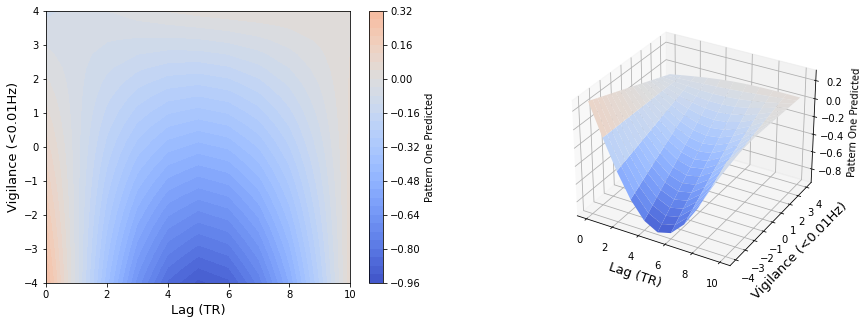

In [36]:
vigilance_eval = np.linspace(-4,4,20)
var_eval = 1 # 1 std above mean
rv_grid = []
rv_grid_conf = []
for v in vigilance_eval:
    pred_list = [var_eval * lag_spline.iloc[:, l].values for l in range(lag_spline.shape[1])]
    pred_mat = np.vstack(pred_list).T
    pred_mat_i = np.vstack([pred_mat[:,i]*v for i in range(full_pred.shape[1])]).T

    pred_mat_full = np.hstack([pred_mat, pred_mat_i, np.repeat(v,11)[:, np.newaxis]])

    # Get predictions from model
    pred_lags = sm_fit_i.predict(pred_mat_full)
    pred_obj = sm_fit_i.get_prediction(pred_mat_full)
    rv_grid.append(pred_lags)
    rv_grid_conf.append(pred_obj.summary_frame(alpha=0.05))

rv_grid = np.array(rv_grid)

fig = plt.figure(figsize=(15,5))
lags = np.arange(11)
x_mesh = np.meshgrid(lags, vigilance_eval)
# First subplot
ax = fig.add_subplot(1, 2, 1)
im = ax.contourf(x_mesh[0], x_mesh[1], rv_grid, 30, cmap='coolwarm', vmin=-1, vmax=1)
ax.set_xlabel('Lag (TR)', fontsize=13)
ax.set_ylabel('Vigilance (<0.01Hz)', fontsize=13)
plt.colorbar(im, label='Pattern One Predicted')

# Second subplot
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_surface(x_mesh[0], x_mesh[1], rv_grid, cmap='coolwarm', vmin=-1, vmax=1)
ax.set_xlabel('Lag (TR)', fontsize=13)
ax.set_ylabel('Vigilance (<0.01Hz)', fontsize=13)
ax.set_zlabel('Pattern One Predicted')
plt.show()

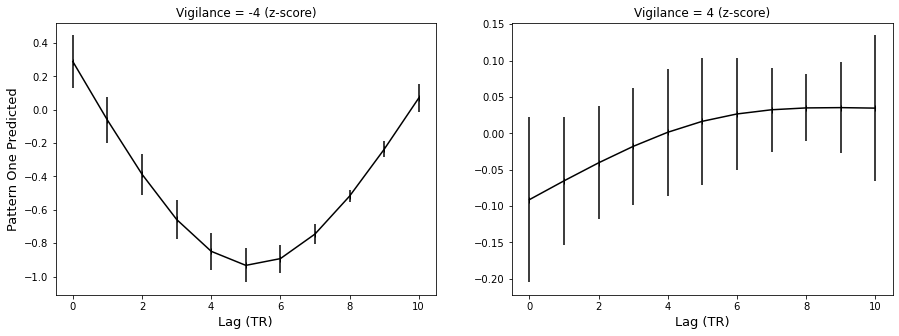

In [37]:
fig = plt.figure(figsize=(15,5))
lags = np.arange(11)
# First subplot
ax = fig.add_subplot(1, 2, 1)
ax.plot(lags, rv_grid_conf[0]['mean'], color='black')
ax.errorbar(lags, rv_grid_conf[0]['mean'], yerr=rv_grid_conf[0]['mean_se'], fmt='|', color='black')
ax.set_xlabel('Lag (TR)', fontsize=13)
ax.set_ylabel('Pattern One Predicted', fontsize=13)
ax.set_title('Vigilance = -4 (z-score)')


# Second subplot
ax = fig.add_subplot(1, 2, 2)
ax.plot(lags, rv_grid_conf[-1]['mean'], color='black')
ax.errorbar(lags, rv_grid_conf[-1]['mean'], yerr=rv_grid_conf[-1]['mean_se'], fmt='|', color='black')
ax.set_xlabel('Lag (TR)', fontsize=13)
ax.set_title('Vigilance = 4 (z-score)')
plt.show()

### 7.1.5 Fit RV and Vigilance Model - PPG LOW

#### 7.1.5.1 Fit Model

In [78]:
full_pred = df_model_group[['RV_Knot_0', 'RV_Knot_1', 'RV_Knot_2']]
test = [full_pred.iloc[:,i].values*df_model_group['vigilance_at'].values for i in range(full_pred.shape[1])]
test_df = pd.DataFrame(test, index=[f'{col}_i' for col in full_pred.columns]).T

full_pred_i = pd.concat([full_pred, test_df], axis=1)
full_pred_i['vigilance'] = df_model_group['vigilance_at'].values

pc_norm = zscore(df_model_group['PPG'])

va = sm.cov_struct.Autoregressive()
sm_fit_i = sm.GEE(pc_norm, full_pred_i, groups=df_model_group.subj, cov_struct=va).fit()
sm_fit_i.summary()

/Users/taylorbolt/opt/miniconda3/lib/python3.8/site-packages/statsmodels/genmod/cov_struct.py:796: FutureWarning: grid=True will become default in a future version
  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                         PPG   No. Observations:                10245
Model:                                 GEE   No. clusters:                       11
Method:                        Generalized   Min. cluster size:                 683
                      Estimating Equations   Max. cluster size:                1366
Family:                           Gaussian   Mean cluster size:               931.4
Dependence structure:       Autoregressive   Num. iterations:                    21
Date:                     Thu, 12 May 2022   Scale:                           0.897
Covariance type:                    robust   Time:                         17:20:39
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
RV_Knot_0      -0.3105      0.055     -5.646      0.000      -0.418      -0.203
RV_Knot_1       0.1643      0.050      3.273      0.001       0.066       0.263
RV_Knot_2      -0.0097      0.040     -0.240      0.810      -0.089       0.069
RV_Knot_0_i     0.0627      0.025      2.552      0.011       0.015       0.111
RV_Knot_1_i    -0.0318      0.019     -1.641      0.101      -0.070       0.006
RV_Knot_2_i     0.0305      0.020      1.500      0.134      -0.009       0.070
vigilance      -0.0021      0.001     -2.307      0.021      -0.004      -0.000
==============================================================================
Skew:                         -0.2205   Kurtosis:                       0.7200
Centered skew:                -0.2204   Centered kurtosis:              0.7206
==============================================================================
"""

#### 7.1.5.2 Plot Interaction

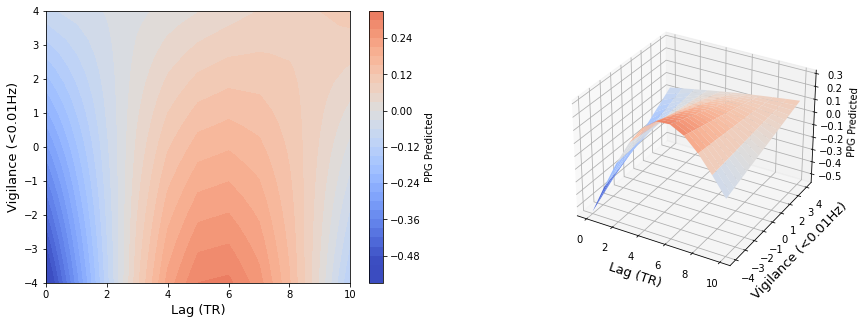

In [85]:
vigilance_eval = np.linspace(-4,4,20)
var_eval = 1 # 1 std above mean
rv_grid = []
rv_grid_conf = []
for v in vigilance_eval:
    pred_list = [var_eval * lag_spline.iloc[:, l].values for l in range(lag_spline.shape[1])]
    pred_mat = np.vstack(pred_list).T
    pred_mat_i = np.vstack([pred_mat[:,i]*v for i in range(full_pred.shape[1])]).T

    pred_mat_full = np.hstack([pred_mat, pred_mat_i, np.repeat(v,11)[:, np.newaxis]])

    # Get predictions from model
    pred_lags = sm_fit_i.predict(pred_mat_full)
    pred_obj = sm_fit_i.get_prediction(pred_mat_full)
    rv_grid.append(pred_lags)
    rv_grid_conf.append(pred_obj.summary_frame(alpha=0.05))

rv_grid = np.array(rv_grid)

fig = plt.figure(figsize=(15,5))
lags = np.arange(11)
x_mesh = np.meshgrid(lags, vigilance_eval)
# First subplot
ax = fig.add_subplot(1, 2, 1)
im = ax.contourf(x_mesh[0], x_mesh[1], rv_grid, 30, cmap='coolwarm', vmin=-0.5, vmax=0.5)
ax.set_xlabel('Lag (TR)', fontsize=13)
ax.set_ylabel('Vigilance (<0.01Hz)', fontsize=13)
plt.colorbar(im, label='PPG Predicted')

# Second subplot
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_surface(x_mesh[0], x_mesh[1], rv_grid, cmap='coolwarm', vmin=-0.5, vmax=0.5)
ax.set_xlabel('Lag (TR)', fontsize=13)
ax.set_ylabel('Vigilance (<0.01Hz)', fontsize=13)
ax.set_zlabel('PPG Predicted')
plt.show()

### 7.1.5 Fit Broadband EEG Amplitude GAM Model

In [178]:
a = np.linspace(-4,4,50)
b = np.linspace(-4,4,50)
t = np.linspace(-4,4,50)

X_mesh = np.meshgrid(a,b,t)
pred_grid_flat = np.vstack([X_mesh[0].flatten(), X_mesh[1].flatten(), X_mesh[2].flatten()])
pred_grid_flat_df = pd.DataFrame(pred_grid_flat.T, columns = ['alpha_hrf','delta_hrf','theta_hrf'])

gamma_hrf = get_hrf(30, 2.1, 'canonical')
max_tuple_all = []
max_tuple_val_all = []
for i in range(subject_list_chang.shape[0]):
    # Load Subject
    subj, scan = subject_list_chang.iloc[i, 0], subject_list_chang.iloc[i, 1]
    sleep = subject_list_chang.iloc[i, 2]
    df = load_subj_chang(subj, scan, pc_subj_chang[f'{subj}_{scan}'], 
                     pc_v_subj_chang[f'{subj}_{scan}'], pc_p_subj_chang[f'{subj}_{scan}'],
                     clus_subj_precuneus_chang[f'{subj}_{scan}'], clus_subj_superior_parietal_chang[f'{subj}_{scan}'], 
                     fs_chang)
    df['alpha_hrf'] = convolve_hrf(gamma_hrf, df['Alpha'])
    df['delta_hrf'] = convolve_hrf(gamma_hrf, df['Delta'])
    df['theta_hrf'] = convolve_hrf(gamma_hrf, df['Theta'])
    lin_gam = LinearGAM(te(s(0, n_splines=4), s(1, n_splines=4), s(2, n_splines=4)))
    lin_gam.fit(df[['delta_hrf', 'theta_hrf', 'alpha_hrf']], df['pc1'])
    pred_val = lin_gam.predict(pred_grid_flat_df)
    max_pred = np.argmax(pred_val)
    max_tuple_all.append(pred_grid_flat_df.iloc[max_pred, :])
    max_tuple_val_all.append(pred_val[max_pred])


## 7.2 HCP Dataset

### 7.2.1 Load Data for Regression Analysis

In [170]:
df_model_group = []
for i in range(subject_list_hcp.shape[0]):
    # Load Subject
    subj = subject_list_hcp.iloc[i, 0]
    df = load_subj_hcp(subj, pc_subj_hcp[f'{subj}'], pc_v_subj_hcp[f'{subj}'], pc_p_subj_hcp[f'{subj}'],
               clus_subj_precuneus_hcp[f'{subj}'], clus_subj_superior_parietal_hcp[f'{subj}'], 
               fs_hcp, norm=True)
    
    # Create a separate dataframe for modeling w/ lag splines
    lag_vec = np.arange(31)
    nknots=3
    rv_basis, lag_spline = lag_basis(df['RESP_AMP_HILBERT'], lag_vec, nknots)
    ppg_basis, lag_spline = lag_basis(df['PPG_LOW_NK'], lag_vec, nknots)
    pc_basis, lag_spline = lag_basis(df['pc1'], lag_vec, nknots)

    # Trim NaNs introduced from lag splines and label columns
    na_indx = ~(np.isnan(rv_basis).any(axis=1))
    df_model_rv = pd.DataFrame(zscore(rv_basis[na_indx, :]), 
                               columns = [f'RV_Knot_{i}' for i in range(nknots)])
    df_model_rv['RV'] = df['RESP_AMP_HILBERT'].loc[na_indx].values
    df_model_ppg = pd.DataFrame(zscore(ppg_basis[na_indx, :]), 
                               columns = [f'PPG_Knot_{i}' for i in range(nknots)])
    df_model_ppg['PPG'] = df['PPG_LOW_NK'].loc[na_indx].values
    df_model_pc1 = pd.DataFrame(zscore(pc_basis[na_indx, :]), 
                               columns = [f'PC_Knot_{i}' for i in range(nknots)])
    
    # Concatenate into one dataframe
    df_model = pd.concat([df_model_rv, df_model_ppg, df_model_pc1], axis=1)
    # supply meta-information
    df_model['subj'] = subj
    df_model['pc1'] = df['pc1'].loc[na_indx].values
    df_model['pc2'] = df['pc2'].loc[na_indx].values
    df_model['pc1_p'] = df['pc1_p'].loc[na_indx].values
    df_model['pc2_p'] = df['pc2_p'].loc[na_indx].values
    df_model['pc3_p'] = df['pc3_p'].loc[na_indx].values
    df_model_group.append(df_model)

df_model_group = pd.concat(df_model_group, axis=0, ignore_index=True)

### 7.2.2 Fit Group Regression Model

#### 7.2.2.1 Fit Model

In [106]:
pred_list = [
    df_model_group[['RV_Knot_0', 'RV_Knot_1', 'RV_Knot_2']],
    df_model_group[['PPG_Knot_0', 'PPG_Knot_1', 'PPG_Knot_2']]
]
    
pred_label = ['RV', 'PPG']
pc_norm = zscore(df_model_group['pc1'])

full_pred = pd.concat(pred_list, axis=1)

va = sm.cov_struct.Autoregressive()
sm_fit_full = sm.GEE(pc_norm, full_pred, groups=df_model_group.subj, cov_struct=va).fit()
sm_fit_full.summary()

/Users/taylorbolt/opt/miniconda3/lib/python3.8/site-packages/statsmodels/genmod/cov_struct.py:796: FutureWarning: grid=True will become default in a future version
  warnings.warn(
/Users/taylorbolt/opt/miniconda3/lib/python3.8/site-packages/statsmodels/genmod/generalized_estimating_equations.py:1293: IterationLimitWarning: Iteration limit reached prior to convergence
  warnings.warn("Iteration limit reached prior to convergence",


<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                         pc1   No. Observations:                17550
Model:                                 GEE   No. clusters:                       15
Method:                        Generalized   Min. cluster size:                1170
                      Estimating Equations   Max. cluster size:                1170
Family:                           Gaussian   Mean cluster size:              1170.0
Dependence structure:       Autoregressive   Num. iterations:                    60
Date:                     Tue, 19 Apr 2022   Scale:                           0.680
Covariance type:                    robust   Time:                         16:44:31
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
RV_Knot_0      0.1186      0.041      2.927      0.003       0.039       0.198
RV_Knot_1     -0.3676      0.048     -7.694      0.000      -0.461      -0.274
RV_Knot_2     -0.0287      0.030     -0.970      0.332      -0.087       0.029
PPG_Knot_0     0.3916      0.048      8.188      0.000       0.298       0.485
PPG_Knot_1    -0.1709      0.051     -3.361      0.001      -0.270      -0.071
PPG_Knot_2     0.1317      0.031      4.259      0.000       0.071       0.192
==============================================================================
Skew:                          0.0505   Kurtosis:                       0.9405
Centered skew:                 0.0459   Centered kurtosis:              0.9453
==============================================================================
"""

#### 7.2.2.2 Plot Model Parameters

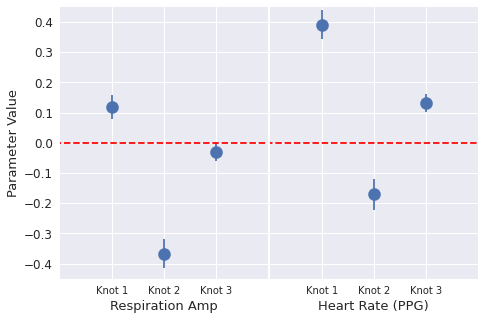

In [109]:
param_labels = [
    ['RV_Knot_0', 'RV_Knot_1', 'RV_Knot_2'],
    ['PPG_Knot_0', 'PPG_Knot_1', 'PPG_Knot_2'],
]
label_group = ['Respiration Amp', 'Heart Rate (PPG)']
param_dict = sm_fit_full.params.to_dict()
se_dict = {l: se for l, se in zip(sm_fit_full.params.index, sm_fit_full.standard_errors())}
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(15,5), constrained_layout=False)
    gspec = fig.add_gridspec(1,4, wspace=0.01)
    for i, (labels, g_label) in enumerate(zip(param_labels, label_group)):
        ax = fig.add_subplot(gspec[i])
        param_vec = [param_dict[l] for l in labels]
        se_vec = [se_dict[l] for l in labels]
        scatter = ax.scatter(np.arange(3), param_vec, s=150)
        ax.errorbar(np.arange(3), param_vec, yerr=se_vec, fmt='|')
        ax.set_xlabel(g_label, fontsize=13)
        ax.set_ylim([-0.45,0.45])
        ax.set_xlim([-1,3])
        ax.axhline(0,-1,4, linestyle='--', c='r',)
        ax.xaxis.set_major_locator(MaxNLocator(nbins=4, prune='both'))
        ax.xaxis.set_ticks([0,1,2])
        ax.set_xticklabels(['Knot 1' , 'Knot 2', 'Knot 3'])
        if i == 0:
            ax.tick_params(axis='y', labelsize=12)
            ax.set_ylabel('Parameter Value', fontsize=13)
        else:
            ax.yaxis.set_ticklabels([])
        ax.grid(True)

### 7.2.2 Perform Commonality Analysis

In [173]:
pred_list = [
    df_model_group[['RV_Knot_0', 'RV_Knot_1', 'RV_Knot_2']],
    df_model_group[['PPG_Knot_0', 'PPG_Knot_1', 'PPG_Knot_2']],
]
    
pred_label = ['RV', 'PPG']
pc_norm = zscore(df_model_group['pc3_p'])

full_pred = pd.concat(pred_list, axis=1)
sm_fit = sm.OLS(pc_norm, full_pred, hasconst=False).fit()
full_r2 = sm_fit.rsquared
common_r2 = full_r2.copy()
unique_r2 = {}
for i, label in enumerate(pred_label):
    partial_pred = pd.concat([pred for n, pred in enumerate(pred_list) if n != i], axis=1)
    sm_fit_partial = sm.OLS(pc_norm, partial_pred, hasconst=False).fit()
    unique_r2[label] = full_r2 - sm_fit_partial.rsquared
    common_r2 -= unique_r2[label]

print(f'Full R2: {full_r2}')
print(f'Unique R2: {unique_r2}')
print(f'Common R2: {common_r2}')

Full R2: 0.2819637145556626
Unique R2: {'RV': 0.21643773673797062, 'PPG': 0.016085010560668356}
Common R2: 0.04944096725702363


# 8. NKI Breathhold Task

## 8.1 Subject Highlights

Text(0, 0.5, 'signal (z-score)')

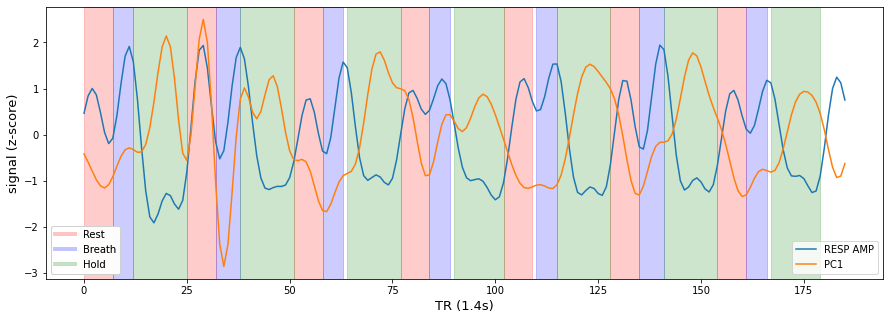

In [14]:
# Subject: A00057406
subj = subject_list_nki.iloc[0, 0]
df = load_subj_nki(subj, pc_subj_nki[f'{subj}'], pc_v_subj_nki[f'{subj}'], pc_p_subj_nki[f'{subj}'], 
                   fs_nki, norm=True)

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df['RESP_AMP_HILBERT'], label='resp')
# ax.plot(df['PPG_HR_NK'], label='hr')
ax.plot(df['pc1'], label='PC1')
lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in range(2)], ['RESP AMP', 'PC1'], loc=4)

trial_labels = ['trial_R', 'trial_B', 'trial_H']
trial_colors = ['red', 'blue', 'green']
for i, trial_l in enumerate(trial_labels):
    blocks = np.array(df[df[trial_l] == 1].index.tolist())
    for b in np.split(blocks, np.where(np.diff(blocks) != 1)[0]+1): 
        ax.axvspan(min(b), max(b), alpha=0.2, color=trial_colors[i])

trial_leg_labels = [Line2D([0], [0], color='red', lw=4, alpha=0.2),
                    Line2D([0], [0], color='blue', lw=4, alpha=0.2),
                    Line2D([0], [0], color='green', lw=4, alpha=0.2)]

legend2 = plt.legend(trial_leg_labels, ['Rest', 'Breath', 'Hold'], loc=3)
ax.add_artist(legend1)
ax.add_artist(legend2)
ax.set_xlabel('TR (1.4s)', fontsize=13)
ax.set_ylabel('signal (z-score)', fontsize=13)


Text(0, 0.5, 'signal (z-score)')

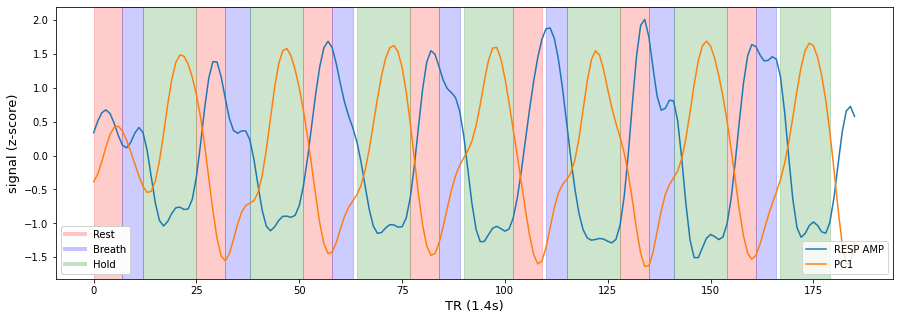

In [15]:
# Subject: A00060302
subj = subject_list_nki.iloc[10, 0]
df = load_subj_nki(subj, pc_subj_nki[f'{subj}'], pc_v_subj_nki[f'{subj}'], pc_p_subj_nki[f'{subj}'], 
                   fs_nki, norm=True)

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df['RESP_AMP_HILBERT'], label='resp')
# ax.plot(df['PPG_HR_NK'], label='hr')
ax.plot(df['pc1'], label='PC1')
lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in range(2)], ['RESP AMP', 'PC1'], loc=4)

trial_labels = ['trial_R', 'trial_B', 'trial_H']
trial_colors = ['red', 'blue', 'green']
for i, trial_l in enumerate(trial_labels):
    blocks = np.array(df[df[trial_l] == 1].index.tolist())
    for b in np.split(blocks, np.where(np.diff(blocks) != 1)[0]+1): 
        ax.axvspan(min(b), max(b), alpha=0.2, color=trial_colors[i])

trial_leg_labels = [Line2D([0], [0], color='red', lw=4, alpha=0.2),
                    Line2D([0], [0], color='blue', lw=4, alpha=0.2),
                    Line2D([0], [0], color='green', lw=4, alpha=0.2)]

legend2 = plt.legend(trial_leg_labels, ['Rest', 'Breath', 'Hold'], loc=3)
ax.add_artist(legend1)
ax.add_artist(legend2)
ax.set_xlabel('TR (1.4s)', fontsize=13)
ax.set_ylabel('signal (z-score)', fontsize=13)


Text(0, 0.5, 'signal (z-score)')

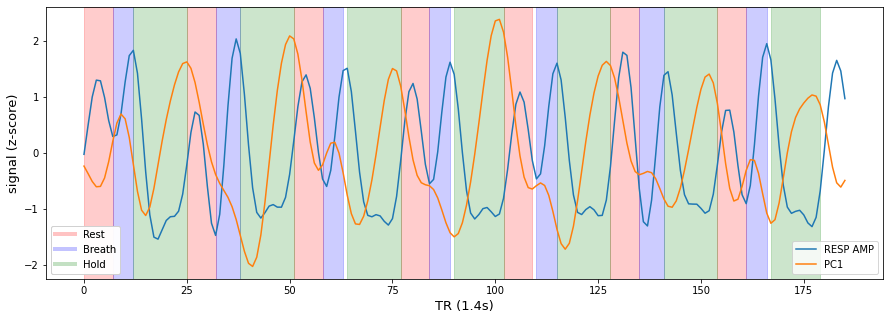

In [16]:
# Subject: A00060302
subj = subject_list_nki.iloc[35, 0]
df = load_subj_nki(subj, pc_subj_nki[f'{subj}'], pc_v_subj_nki[f'{subj}'], pc_p_subj_nki[f'{subj}'], 
                   fs_nki, norm=True)

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df['RESP_AMP_HILBERT'], label='resp')
# ax.plot(df['PPG_HR_NK'], label='hr')
ax.plot(df['pc1'], label='PC1')
lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in range(2)], ['RESP AMP', 'PC1'], loc=4)

trial_labels = ['trial_R', 'trial_B', 'trial_H']
trial_colors = ['red', 'blue', 'green']
for i, trial_l in enumerate(trial_labels):
    blocks = np.array(df[df[trial_l] == 1].index.tolist())
    for b in np.split(blocks, np.where(np.diff(blocks) != 1)[0]+1): 
        ax.axvspan(min(b), max(b), alpha=0.2, color=trial_colors[i])

trial_leg_labels = [Line2D([0], [0], color='red', lw=4, alpha=0.2),
                    Line2D([0], [0], color='blue', lw=4, alpha=0.2),
                    Line2D([0], [0], color='green', lw=4, alpha=0.2)]

legend2 = plt.legend(trial_leg_labels, ['Rest', 'Breath', 'Hold'], loc=3)
ax.add_artist(legend1)
ax.add_artist(legend2)
ax.set_xlabel('TR (1.4s)', fontsize=13)
ax.set_ylabel('signal (z-score)', fontsize=13)


## 8.2 Average Time Course - Pattern One

Text(0, 0.5, 'signal (z-score)')

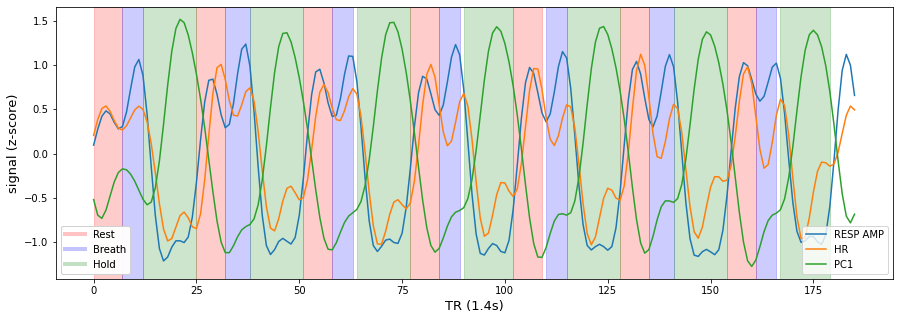

In [17]:
resp_avg = []
ppg_avg = []
pc_avg = []
for i in range(subject_list_nki.shape[0]):
    # Load Subject
    subj = subject_list_nki.iloc[i, 0]
    df = load_subj_nki(subj, pc_subj_nki[f'{subj}'], pc_v_subj_nki[f'{subj}'], pc_p_subj_nki[f'{subj}'],
                       fs_nki, norm=True)
    resp_avg.append(df['RESP_AMP_HILBERT'].values)
    ppg_avg.append(df['PPG_HR_NK'].values)
    pc_avg.append(df['pc1'].values)
    
resp_avg = np.array(resp_avg).mean(axis=0)
ppg_avg = np.array(ppg_avg).mean(axis=0)
pc_avg = np.array(pc_avg).mean(axis=0)


fig, ax = plt.subplots(figsize=(15,5))
ax.plot(resp_avg, label='resp')
ax.plot(ppg_avg, label='hr')
ax.plot(pc_avg, label='PC1')

lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in range(3)], ['RESP AMP', 'HR', 'PC1'], loc=4)

trial_labels = ['trial_R', 'trial_B', 'trial_H']
trial_colors = ['red', 'blue', 'green']
for i, trial_l in enumerate(trial_labels):
    blocks = np.array(df[df[trial_l] == 1].index.tolist())
    for b in np.split(blocks, np.where(np.diff(blocks) != 1)[0]+1): 
        ax.axvspan(min(b), max(b), alpha=0.2, color=trial_colors[i])

trial_leg_labels = [Line2D([0], [0], color='red', lw=4, alpha=0.2),
                    Line2D([0], [0], color='blue', lw=4, alpha=0.2),
                    Line2D([0], [0], color='green', lw=4, alpha=0.2)]

legend2 = plt.legend(trial_leg_labels, ['Rest', 'Breath', 'Hold'], loc=3)
ax.add_artist(legend1)
ax.add_artist(legend2)
ax.set_xlabel('TR (1.4s)', fontsize=13)
ax.set_ylabel('signal (z-score)', fontsize=13)

## 8.3 Average Time Course - Promax Components

In [19]:
%matplotlib qt
pc_p1_avg = []
pc_p6_avg = []
pc_p9_avg = []

for i in range(subject_list_nki.shape[0]):
    # Load Subject
    subj = subject_list_nki.iloc[i, 0]
    df = load_subj_nki(subj, pc_subj_nki[f'{subj}'], pc_v_subj_nki[f'{subj}'], pc_p_subj_nki[f'{subj}'],
                       fs_nki, norm=True)
    pc_p1_avg.append(df['pc1_p'].values)
    pc_p6_avg.append(df['pc6_p'].values)
    pc_p9_avg.append(df['pc9_p'].values)
    
pc_p1_avg = np.array(pc_p1_avg).mean(axis=0)
pc_p6_avg = np.array(pc_p6_avg).mean(axis=0)
pc_p9_avg = np.array(pc_p9_avg).mean(axis=0)


fig, ax = plt.subplots(figsize=(15,5))
ax.plot(pc_p1_avg, label='PC1')
ax.plot(pc_p6_avg, label='PC6')
ax.plot(pc_p9_avg, label='PC9')

lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in range(3)], ['PC1', 'PC6', 'PC9'], loc=4)

trial_labels = ['trial_R', 'trial_B', 'trial_H']
trial_colors = ['red', 'blue', 'green']
for i, trial_l in enumerate(trial_labels):
    blocks = np.array(df[df[trial_l] == 1].index.tolist())
    for b in np.split(blocks, np.where(np.diff(blocks) != 1)[0]+1): 
        ax.axvspan(min(b), max(b), alpha=0.2, color=trial_colors[i])

trial_leg_labels = [Line2D([0], [0], color='red', lw=4, alpha=0.2),
                    Line2D([0], [0], color='blue', lw=4, alpha=0.2),
                    Line2D([0], [0], color='green', lw=4, alpha=0.2)]

legend2 = plt.legend(trial_leg_labels, ['Rest', 'Breath', 'Hold'], loc=3)
ax.add_artist(legend1)
ax.add_artist(legend2)
ax.set_xlabel('TR (1.4s)', fontsize=13)
ax.set_ylabel('signal (z-score)', fontsize=13)

Text(0, 0.5, 'signal (z-score)')

## 8.4 Average Time Course - PPG Low Frequency

Text(0, 0.5, 'signal (z-score)')

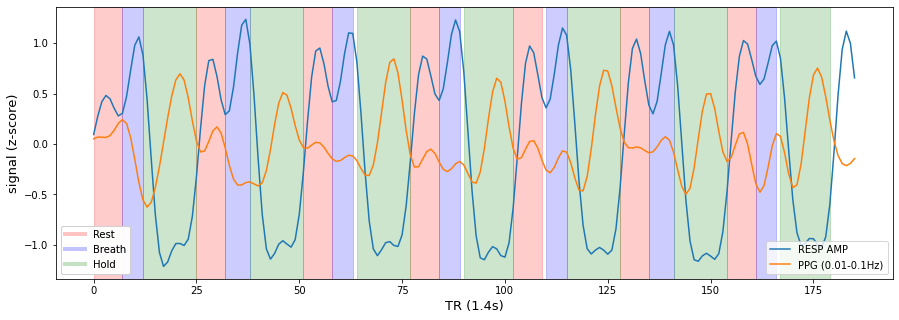

In [189]:
resp_avg = []
ppg_avg = []
pc_avg = []

df_group = []
for i in range(subject_list_nki.shape[0]):
    # Load Subject
    subj = subject_list_nki.iloc[i, 0]
    df = load_subj_nki(subj, pc_subj_nki[f'{subj}'], pc_v_subj_nki[f'{subj}'], pc_p_subj_nki[f'{subj}'],
                       fs_nki, norm=True)
    resp_avg.append(df['RESP_AMP_HILBERT'].values)
    ppg_avg.append(df['PPG_LOW_NK'].values)
    df_group.append(df)
    
df_group = pd.concat(df_group, axis=0)
    
resp_avg = np.array(resp_avg).mean(axis=0)
ppg_avg = np.array(ppg_avg).mean(axis=0)


fig, ax = plt.subplots(figsize=(15,5))
ax.plot(resp_avg, label='resp')
ax.plot(ppg_avg, label='hr')

lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in range(2)], ['RESP AMP', 'PPG (0.01-0.1Hz)'], loc=4)

trial_labels = ['trial_R', 'trial_B', 'trial_H']
trial_colors = ['red', 'blue', 'green']
for i, trial_l in enumerate(trial_labels):
    blocks = np.array(df[df[trial_l] == 1].index.tolist())
    for b in np.split(blocks, np.where(np.diff(blocks) != 1)[0]+1): 
        ax.axvspan(min(b), max(b), alpha=0.2, color=trial_colors[i])

trial_leg_labels = [Line2D([0], [0], color='red', lw=4, alpha=0.2),
                    Line2D([0], [0], color='blue', lw=4, alpha=0.2),
                    Line2D([0], [0], color='green', lw=4, alpha=0.2)]

legend2 = plt.legend(trial_leg_labels, ['Rest', 'Breath', 'Hold'], loc=3)
ax.add_artist(legend1)
ax.add_artist(legend2)
ax.set_xlabel('TR (1.4s)', fontsize=13)
ax.set_ylabel('signal (z-score)', fontsize=13)

Text(0, 0.5, 'Correlation')

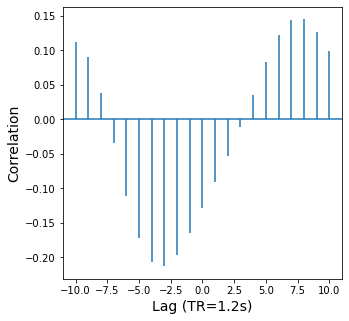

In [238]:
fig, ax = plt.subplots(figsize=(5,5))
ax.xcorr(df_group['RESP_AMP_HILBERT'], df_group['PPG_LOW_NK'])
ax.set_xlabel('Lag (TR=1.2s)', fontsize=14)
ax.set_ylabel('Correlation', fontsize=14)

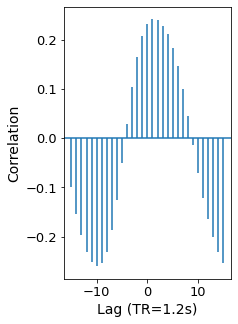

In [250]:
fig, ax = plt.subplots(figsize=(3,5))
ax.xcorr(df_group['RESP_AMP_HILBERT'], df_group['pc1'])
ax.set_xlabel('Lag (TR=1.2s)', fontsize=14)
ax.set_ylabel('Correlation', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=13)

## 8.3 Regression Analysis

In [225]:
nknots=3
lag_vec = np.arange(16)

pred_basis_group = []
pc_group = []
subj_group = []
for i in range(subject_list_nki.shape[0]):
    # Load Subject
    subj = subject_list_nki.iloc[i, 0]
    df = load_subj_nki(subj, pc_subj_nki[f'{subj}'], pc_v_subj_nki[f'{subj}'], pc_p_subj_nki[f'{subj}'],
                       fs_nki, norm=True)
    rv_basis, lag_spline = lag_basis(df['RESP_AMP_HILBERT'], lag_vec, nknots)
    ppg_basis, lag_spline = lag_basis(df['PPG_HR_NK'], lag_vec, nknots)
    # Trim NaNs introduced from lag splines and label columns
    na_indx = ~(np.isnan(rv_basis).any(axis=1))
    df_model_rv = pd.DataFrame(zscore(rv_basis[na_indx, :]), 
                               columns = [f'RV_Knot_{i}' for i in range(nknots)])
    df_model_ppg = pd.DataFrame(zscore(ppg_basis[na_indx, :]), 
                               columns = [f'PPG_Knot_{i}' for i in range(nknots)])
    pred_basis_group.append(pd.concat([df_model_rv, df_model_ppg], axis=1))
    # Concatenate time splines and their interaction with Resp basis
    pc_group.append(zscore(df['pc9_p'].loc[na_indx].values))
    subj_group.append(np.repeat(subj, na_indx.sum()))
    
pred_basis_group = pd.concat(pred_basis_group, axis=0)
pc_group = np.hstack(pc_group)
subj_group = np.hstack(subj_group)

va = sm.cov_struct.Autoregressive()
sm_fit_full = sm.GEE(pc_group, pred_basis_group, groups=subj_group, cov_struct=va).fit()
sm_fit_full.summary()

/Users/taylorbolt/opt/miniconda3/lib/python3.8/site-packages/statsmodels/genmod/cov_struct.py:796: FutureWarning: grid=True will become default in a future version
  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                           y   No. Observations:                 8550
Model:                                 GEE   No. clusters:                       50
Method:                        Generalized   Min. cluster size:                 171
                      Estimating Equations   Max. cluster size:                 171
Family:                           Gaussian   Mean cluster size:               171.0
Dependence structure:       Autoregressive   Num. iterations:                    17
Date:                     Thu, 19 May 2022   Scale:                           0.826
Covariance type:                    robust   Time:                         09:12:53
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
RV_Knot_0      0.0469      0.039      1.202      0.229      -0.030       0.123
RV_Knot_1      0.0229      0.048      0.478      0.633      -0.071       0.117
RV_Knot_2     -0.2975      0.039     -7.717      0.000      -0.373      -0.222
PPG_Knot_0     0.1714      0.033      5.178      0.000       0.107       0.236
PPG_Knot_1    -0.0204      0.041     -0.498      0.618      -0.100       0.060
PPG_Knot_2     0.0550      0.030      1.839      0.066      -0.004       0.114
==============================================================================
Skew:                         -0.0933   Kurtosis:                       0.1903
Centered skew:                -0.0933   Centered kurtosis:              0.1903
==============================================================================
"""

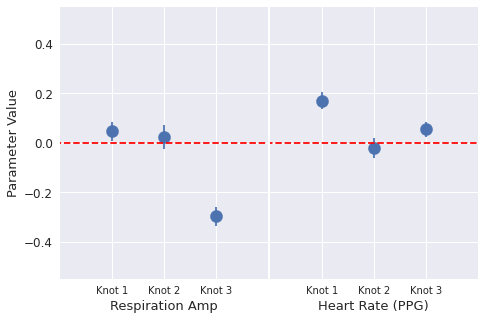

In [226]:
param_labels = [
    ['RV_Knot_0', 'RV_Knot_1', 'RV_Knot_2'],
    ['PPG_Knot_0', 'PPG_Knot_1', 'PPG_Knot_2'],
]
label_group = ['Respiration Amp', 'Heart Rate (PPG)']
param_dict = sm_fit_full.params.to_dict()
se_dict = {l: se for l, se in zip(sm_fit_full.params.index, sm_fit_full.standard_errors())}
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(15,5), constrained_layout=False)
    gspec = fig.add_gridspec(1,4, wspace=0.01)
    for i, (labels, g_label) in enumerate(zip(param_labels, label_group)):
        ax = fig.add_subplot(gspec[i])
        param_vec = [param_dict[l] for l in labels]
        se_vec = [se_dict[l] for l in labels]
        scatter = ax.scatter(np.arange(3), param_vec, s=150)
        ax.errorbar(np.arange(3), param_vec, yerr=se_vec, fmt='|')
        ax.set_xlabel(g_label, fontsize=13)
        ax.set_ylim([-0.55,0.55])
        ax.set_xlim([-1,3])
        ax.axhline(0,-1,4, linestyle='--', c='r',)
        ax.xaxis.set_major_locator(MaxNLocator(nbins=4, prune='both'))
        ax.xaxis.set_ticks([0,1,2])
        ax.set_xticklabels(['Knot 1' , 'Knot 2', 'Knot 3'])
        if i == 0:
            ax.tick_params(axis='y', labelsize=12)
            ax.set_ylabel('Parameter Value', fontsize=13)
        else:
            ax.yaxis.set_ticklabels([])
        ax.grid(True)

## 8.4 Time-Varying Regression

In [139]:
nknots=3
lag_vec = np.arange(16)
tv_basis_group = []
pc_group = []
subj_group = []
for i in range(subject_list_nki.shape[0]):
    # Load Subject
    subj = subject_list_nki.iloc[i, 0]
    df = load_subj_nki(subj, pc_subj_nki[f'{subj}'], pc_v_subj_nki[f'{subj}'], pc_p_subj_nki[f'{subj}'],
                       fs_nki, norm=True)
    rv_basis, lag_spline = lag_basis(df['RESP_AMP_HILBERT'], lag_vec, nknots)
    # Trim NaNs introduced from lag splines and label columns
    na_indx = ~(np.isnan(rv_basis).any(axis=1))
    rv_basis_norm = zscore(rv_basis[na_indx, :])
    time_vec = np.arange(rv_basis_norm.shape[0])
    tv_basis, time_splines = time_varying_splines(rv_basis_norm, time_vec, 4)
    # Concatenate time splines and their interaction with Resp basis
    full_pred = np.hstack([time_splines.values, tv_basis])
    tv_basis_group.append(full_pred)
    pc_group.append(zscore(df['pc1'].loc[na_indx].values))
    subj_group.append(np.repeat(subj, rv_basis_norm.shape[0]))
    
tv_basis_group = np.vstack(tv_basis_group)
pc_group = np.hstack(pc_group)
subj_group = np.hstack(subj_group)

va = sm.cov_struct.Autoregressive()
sm_fit_full = sm.GEE(pc_group, tv_basis_group, groups=subj_group, cov_struct=va).fit()

/Users/taylorbolt/opt/miniconda3/lib/python3.8/site-packages/statsmodels/genmod/cov_struct.py:796: FutureWarning: grid=True will become default in a future version
  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                           y   No. Observations:                 8550
Model:                                 GEE   No. clusters:                       50
Method:                        Generalized   Min. cluster size:                 171
                      Estimating Equations   Max. cluster size:                 171
Family:                           Gaussian   Mean cluster size:               171.0
Dependence structure:       Autoregressive   Num. iterations:                    11
Date:                     Tue, 26 Apr 2022   Scale:                           0.746
Covariance type:                    robust   Time:                         21:08:00
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1973      0.085     -2.329      0.020      -0.363      -0.031
x2            -0.0095      0.026     -0.365      0.715      -0.061       0.042
x3            -0.0153      0.019     -0.813      0.416      -0.052       0.022
x4             0.0476      0.012      3.941      0.000       0.024       0.071
x5            -0.0537      0.070     -0.771      0.441      -0.190       0.083
x6            -0.1472      0.182     -0.809      0.419      -0.504       0.210
x7             0.6151      0.080      7.682      0.000       0.458       0.772
x8             0.2217      0.079      2.823      0.005       0.068       0.376
x9            -0.0397      0.116     -0.343      0.732      -0.267       0.187
x10            0.5590      0.058      9.569      0.000       0.445       0.674
x11            0.0374      0.058      0.643      0.520      -0.077       0.151
x12           -0.1424      0.058     -2.439      0.015      -0.257      -0.028
x13            0.1561      0.058      2.706      0.007       0.043       0.269
x14           -0.4312      0.065     -6.584      0.000      -0.560      -0.303
x15           -0.2276      0.040     -5.691      0.000      -0.306      -0.149
x16           -0.1202      0.067     -1.798      0.072      -0.251       0.011
x17           -0.3297      0.053     -6.217      0.000      -0.434      -0.226
x18           -0.0697      0.048     -1.444      0.149      -0.164       0.025
x19            0.1067      0.057      1.863      0.062      -0.006       0.219
x20           -0.0270      0.069     -0.393      0.695      -0.162       0.108
x21            0.0575      0.064      0.903      0.366      -0.067       0.182
x22            0.1344      0.072      1.870      0.062      -0.006       0.275
x23            0.0120      0.110      0.110      0.913      -0.203       0.227
x24           -0.1055      0.079     -1.332      0.183      -0.261       0.050
==============================================================================
Skew:                         -0.1394   Kurtosis:                      -0.2250
Centered skew:                -0.1357   Centered kurtosis:             -0.2232
==============================================================================
"""

In [140]:
pred_lag_vec = np.linspace(0, 16, 40)
var_eval = 1
basis_lag_pred = dmatrix(lag_spline.design_info, {'x': pred_lag_vec}, return_type='dataframe')
 # Intialize basis matrix
pred_list = [var_eval * basis_lag_pred.iloc[:, l].values for l in range(basis_lag_pred.shape[1])]
pred_mat = np.vstack(pred_list).T

lag_pred = []
for t in time_vec:
    t_pred = np.repeat(t, 40)
    t_spline = dmatrix(time_splines.design_info, {'x': t_pred}, return_type='dataframe')
    tv_basis = np.zeros((pred_mat.shape[0], t_spline.shape[1]*pred_mat.shape[1]))
    indx = 0
    for t in np.arange(t_spline.shape[1]):
        for b in np.arange(pred_mat.shape[1]):
            tv_basis[:,indx]= t_spline.iloc[:,t] * pred_mat[:,b]
            indx += 1
    full_pred = np.hstack([t_spline, tv_basis])
    lag_pred.append(sm_fit_full.predict(full_pred))

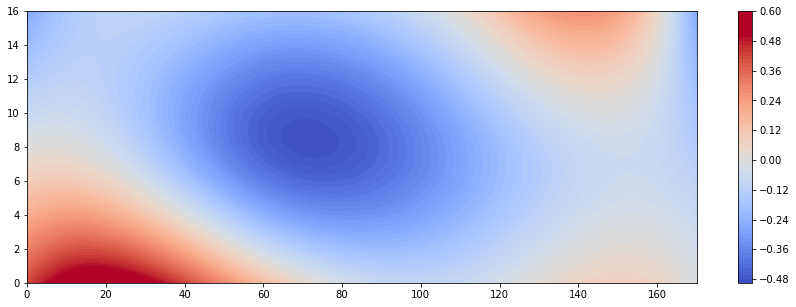

In [141]:
fig, ax = plt.subplots(figsize=(15,5))
X,Y = np.meshgrid(time_vec, pred_lag_vec)
im = ax.contourf(X,Y, np.array(lag_pred).T, 100, cmap='coolwarm', vmin=-.5,vmax=.5)
plt.colorbar(im)

# 9. Relationship b/w Patterns 

## 9.1 Promax Pattern Correlations

### 9.1.1 Chang Dataset

#### 9.1.1.1 Zero-lag Correlations

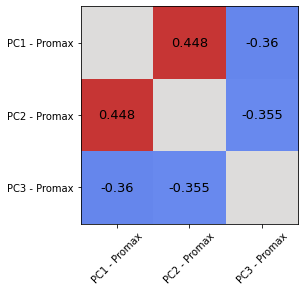

In [36]:
pca_p = pickle.load(open('results/pca/chang_pca_group_promax_results.pkl', 'rb'))
pca = pickle.load(open('results/pca/chang_pca_group_results.pkl', 'rb'))

corr_mat = np.corrcoef(pca_p['pc_scores'].T)
np.fill_diagonal(corr_mat, 0)

fig, ax = plt.subplots()
ax.imshow(corr_mat, vmin=-0.5, vmax=0.5, cmap='coolwarm')
ax.set_xticks(np.arange(3))
ax.set_yticks(np.arange(3))
ax.set_xticklabels(['PC1 - Promax', 'PC2 - Promax', 'PC3 - Promax'], rotation=45)
ax.set_yticklabels(['PC1 - Promax', 'PC2 - Promax', 'PC3 - Promax'])

for (j,i),label in np.ndenumerate(corr_mat):
    if i != j:
        ax.text(i,j,round(label,3),ha='center',va='center', fontsize=13)

#### 9.1.1.2 Cross-Correlations

Text(0.5, 1.0, 'PC2 Promax - PC3 Promax \nCross-Corr')

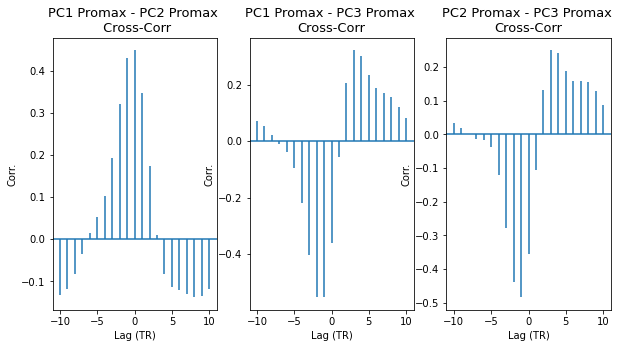

In [19]:
fig, axs = plt.subplots(1,3, figsize=(10,5))
axs[0].xcorr(pca_p['pc_scores'][:,0], pca_p['pc_scores'][:,1], maxlags=10)
axs[0].set_xlabel('Lag (TR)')
axs[0].set_ylabel('Corr.')
axs[0].set_title('PC1 Promax - PC2 Promax \n Cross-Corr', fontsize=13)

axs[1].xcorr(pca_p['pc_scores'][:,0], pca_p['pc_scores'][:,2], maxlags=10)
axs[1].set_xlabel('Lag (TR)')
axs[1].set_ylabel('Corr.')
axs[1].set_title('PC1 Promax - PC3 Promax \nCross-Corr', fontsize=13)

axs[2].xcorr(pca_p['pc_scores'][:,1], pca_p['pc_scores'][:,2], maxlags=10)
axs[2].set_xlabel('Lag (TR)')
axs[2].set_ylabel('Corr.')
axs[2].set_title('PC2 Promax - PC3 Promax \nCross-Corr', fontsize=13)

#### 9.1.1.3 Time Course Correlations with Pattern One

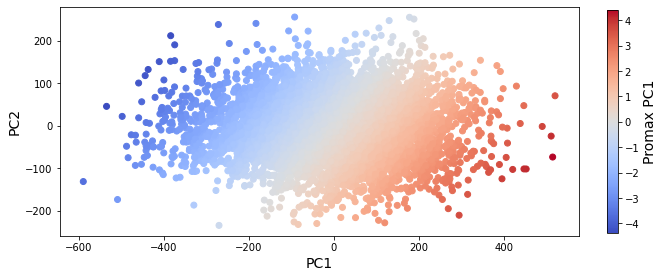

In [236]:
fig, ax = plt.subplots(figsize=(10,10))
p = ax.scatter(pca['pc_scores'][:,0], pca['pc_scores'][:,1], c=pca_p['pc_scores'][:,0], cmap='coolwarm')
ax.axis('scaled')
ax.set_xlabel('PC1', fontsize=14)
ax.set_ylabel('PC2', fontsize=14)
cbar = plt.colorbar(p, ax=ax, fraction=0.02)
cbar.set_label('Promax PC1', fontsize=14)

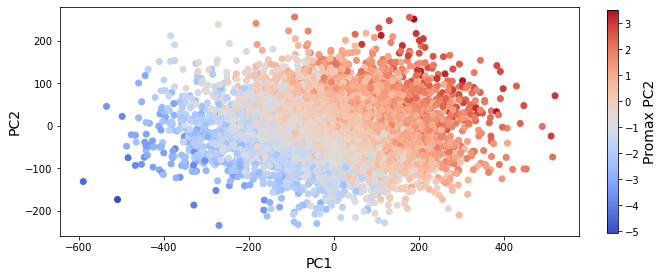

In [237]:
fig, ax = plt.subplots(figsize=(10,10))
p = ax.scatter(pca['pc_scores'][:,0], pca['pc_scores'][:,1], c=pca_p['pc_scores'][:,1], cmap='coolwarm')
ax.axis('scaled')
ax.set_xlabel('PC1', fontsize=14)
ax.set_ylabel('PC2', fontsize=14)
cbar = plt.colorbar(p, ax=ax, fraction=0.02)
cbar.set_label('Promax PC2', fontsize=14)

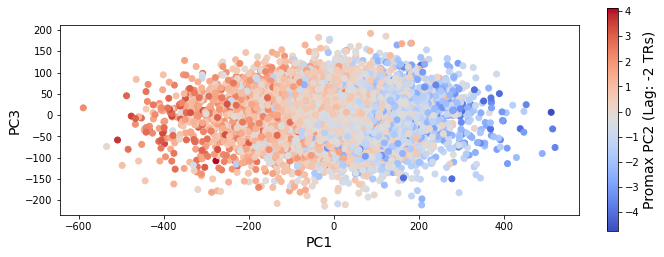

In [238]:
fig, ax = plt.subplots(figsize=(10,10))
p = ax.scatter(pca['pc_scores'][:,0], pca['pc_scores'][:,2], c=np.roll(pca_p['pc_scores'][:,2], -2), cmap='coolwarm')
ax.axis('scaled')
ax.set_xlabel('PC1', fontsize=14)
ax.set_ylabel('PC3', fontsize=14)
cbar = plt.colorbar(p, ax=ax, fraction=0.02)
cbar.set_label('Promax PC2 (Lag: -2 TRs)', fontsize=14)

In [239]:
df = pd.DataFrame(np.hstack([pca['pc_scores'][:,0][:,np.newaxis], pca_p['pc_scores']]), 
                  columns=['PC1', 'PC1_P','PC2_P', 'PC3_P'])
df['PC3_P_Shift'] = df['PC3_P'].shift(-1)
df[['PC1', 'PC1_P','PC2_P', 'PC3_P_Shift']].corr()

PC1     PC1_P     PC2_P  PC3_P_Shift
PC1          1.000000  0.913638  0.722953    -0.721784
PC1_P        0.913638  1.000000  0.447855    -0.552763
PC2_P        0.722953  0.447855  1.000000    -0.484165
PC3_P_Shift -0.721784 -0.552763 -0.484165     1.000000

#### 9.1.1.3 Spatial Loadings Promax

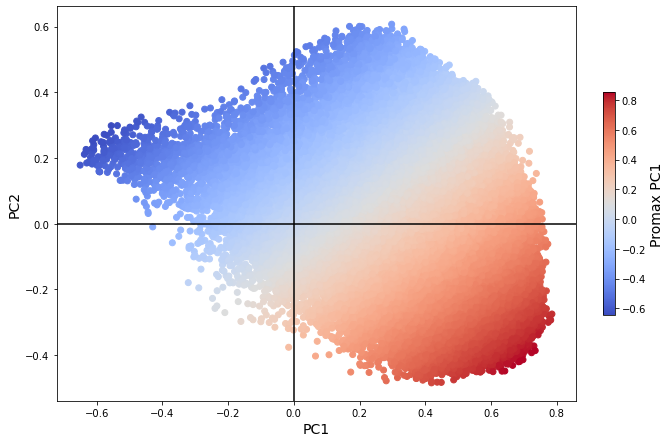

In [37]:
fig, ax = plt.subplots(figsize=(10,10))
p = ax.scatter(pca['loadings'][0,:], pca['loadings'][1,:], c=pca_p['loadings'][0,:], cmap='coolwarm')
ax.axis('scaled')
ax.set_xlabel('PC1', fontsize=14)
ax.set_ylabel('PC2', fontsize=14)
ax.vlines(0,-1,1, color='black')
ax.hlines(0,-1,1, color='black')
cbar = plt.colorbar(p, ax=ax, fraction=0.02)
cbar.set_label('Promax PC1', fontsize=14)

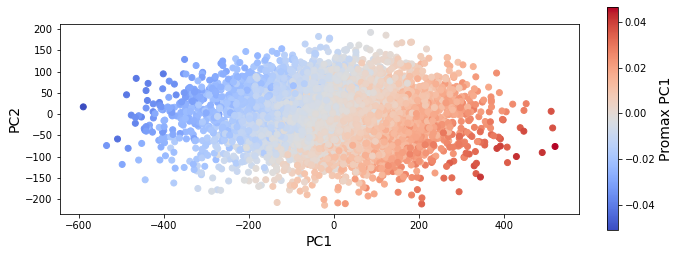

In [58]:
t_ica = pickle.load(open('results/ica/chang_ica_temporal_group_results.pkl', 'rb'))
fig, ax = plt.subplots(figsize=(10,10))
p = ax.scatter(pca['pc_scores'][:,0], pca['pc_scores'][:,2], c=t_ica[1][:,0], cmap='coolwarm')
ax.axis('scaled')
ax.set_xlabel('PC1', fontsize=14)
ax.set_ylabel('PC2', fontsize=14)
cbar = plt.colorbar(p, ax=ax, fraction=0.02)
cbar.set_label('Promax PC1', fontsize=14)

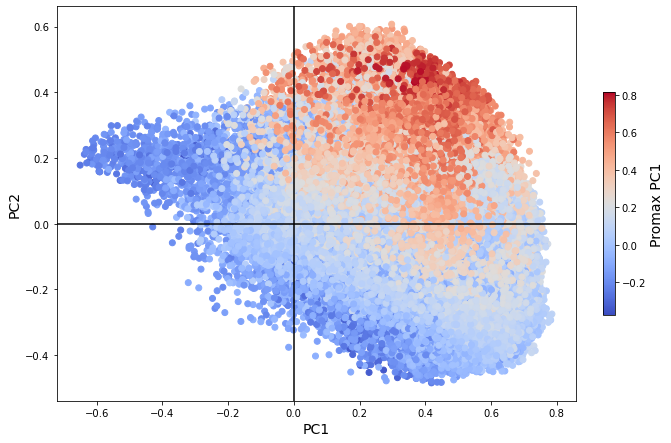

In [38]:
fig, ax = plt.subplots(figsize=(10,10))
p = ax.scatter(pca['loadings'][0,:], pca['loadings'][1,:], c=pca_p['loadings'][1,:], cmap='coolwarm')
ax.axis('scaled')
ax.set_xlabel('PC1', fontsize=14)
ax.set_ylabel('PC2', fontsize=14)
ax.vlines(0,-1,1, color='black')
ax.hlines(0,-1,1, color='black')
cbar = plt.colorbar(p, ax=ax, fraction=0.02)
cbar.set_label('Promax PC1', fontsize=14)

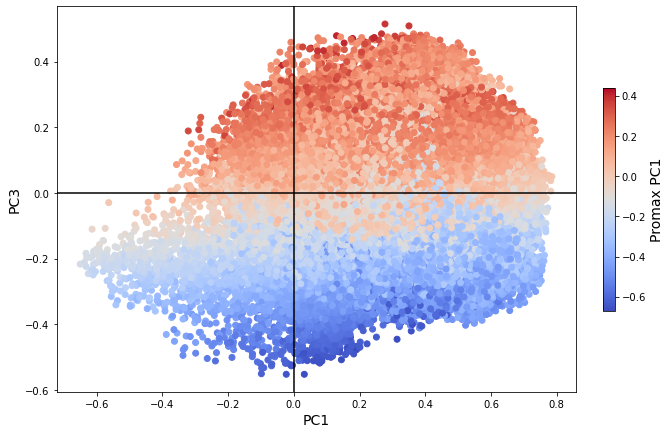

In [40]:
fig, ax = plt.subplots(figsize=(10,10))
p = ax.scatter(pca['loadings'][0,:], pca['loadings'][2,:], c=pca_p['loadings'][2,:], cmap='coolwarm')
ax.axis('scaled')
ax.set_xlabel('PC1', fontsize=14)
ax.set_ylabel('PC3', fontsize=14)
ax.vlines(0,-1,1, color='black')
ax.hlines(0,-1,1, color='black')
cbar = plt.colorbar(p, ax=ax, fraction=0.02)
cbar.set_label('Promax PC1', fontsize=14)

### 9.1.2 HCP Dataset

#### 9.1.2.1 Zero-lag Correlations

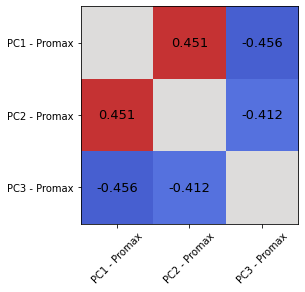

In [292]:
pca_p = pickle.load(open('results/pca/hcp_pca_group_promax_results.pkl', 'rb'))
pca = pickle.load(open('results/pca/hcp_pca_group_results.pkl', 'rb'))

pca['pc_scores'][:,0] = pca['pc_scores'][:,0]*-1 # Make consisent with Chang PC1
pca_p['pc_scores'][:,0] = pca_p['pc_scores'][:,0]*-1 # Make consisent with Chang PC1
pca_p['pc_scores'][:,2] = pca_p['pc_scores'][:,2]*-1 # Make consisent with Chang PC1

corr_mat = np.corrcoef(pca_p['pc_scores'].T)
np.fill_diagonal(corr_mat, 0)

fig, ax = plt.subplots()
ax.imshow(corr_mat, vmin=-0.5, vmax=0.5, cmap='coolwarm')
ax.set_xticks(np.arange(3))
ax.set_yticks(np.arange(3))
ax.set_xticklabels(['PC1 - Promax', 'PC2 - Promax', 'PC3 - Promax'], rotation=45)
ax.set_yticklabels(['PC1 - Promax', 'PC2 - Promax', 'PC3 - Promax'])

for (j,i),label in np.ndenumerate(corr_mat):
    if i != j:
        ax.text(i,j,round(label,3),ha='center',va='center', fontsize=13)

#### 9.1.1.2 Cross-Correlations

Text(0.5, 1.0, 'PC2 Promax - PC3 Promax \nCross-Corr')

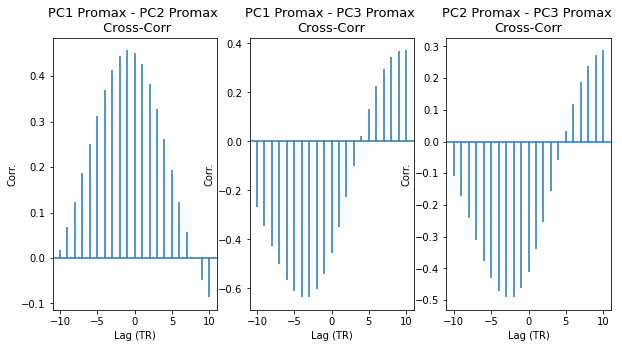

In [177]:
fig, axs = plt.subplots(1,3, figsize=(10,5))
axs[0].xcorr(pca_p['pc_scores'][:,0], pca_p['pc_scores'][:,1], maxlags=10)
axs[0].set_xlabel('Lag (TR)')
axs[0].set_ylabel('Corr.')
axs[0].set_title('PC1 Promax - PC2 Promax \n Cross-Corr', fontsize=13)

axs[1].xcorr(pca_p['pc_scores'][:,0], pca_p['pc_scores'][:,2], maxlags=10)
axs[1].set_xlabel('Lag (TR)')
axs[1].set_ylabel('Corr.')
axs[1].set_title('PC1 Promax - PC3 Promax \nCross-Corr', fontsize=13)

axs[2].xcorr(pca_p['pc_scores'][:,1], pca_p['pc_scores'][:,2], maxlags=10)
axs[2].set_xlabel('Lag (TR)')
axs[2].set_ylabel('Corr.')
axs[2].set_title('PC2 Promax - PC3 Promax \nCross-Corr', fontsize=13)

#### 9.1.1.3 Correlations with Pattern One

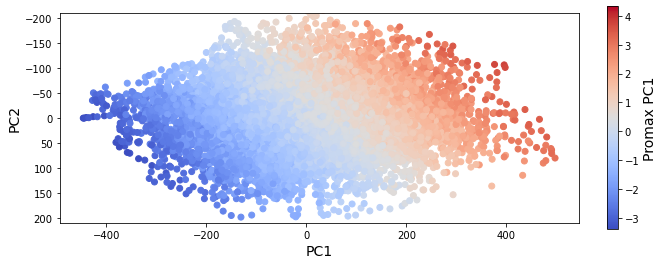

In [199]:
fig, ax = plt.subplots(figsize=(10,10))
p = ax.scatter(pca['pc_scores'][:,0], pca['pc_scores'][:,1], c=pca_p['pc_scores'][:,0], cmap='coolwarm')
ax.axis('scaled')
ax.set_xlabel('PC1', fontsize=14)
ax.set_ylabel('PC2', fontsize=14)
ax.set_ylim(210, -210)
cbar = plt.colorbar(p, ax=ax, fraction=0.02)
cbar.set_label('Promax PC1', fontsize=14)

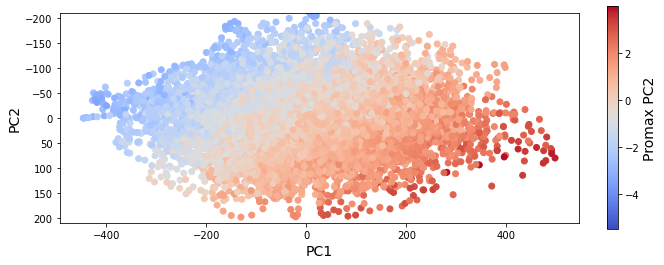

In [201]:
fig, ax = plt.subplots(figsize=(10,10))
p = ax.scatter(pca['pc_scores'][:,0], pca['pc_scores'][:,1], c=pca_p['pc_scores'][:,1], cmap='coolwarm')
ax.axis('scaled')
ax.set_xlabel('PC1', fontsize=14)
ax.set_ylabel('PC2', fontsize=14)
ax.set_ylim(210, -210)
cbar = plt.colorbar(p, ax=ax, fraction=0.02)
cbar.set_label('Promax PC2', fontsize=14)

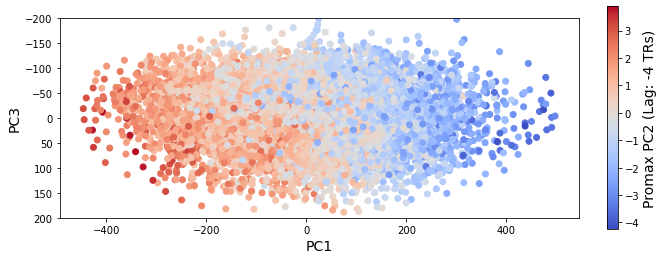

In [202]:
fig, ax = plt.subplots(figsize=(10,10))
p = ax.scatter(pca['pc_scores'][:,0], pca['pc_scores'][:,2], c=np.roll(pca_p['pc_scores'][:,2], -4), cmap='coolwarm')
ax.axis('scaled')
ax.set_xlabel('PC1', fontsize=14)
ax.set_ylabel('PC3', fontsize=14)
ax.set_ylim(200, -200)
cbar = plt.colorbar(p, ax=ax, fraction=0.02)
cbar.set_label('Promax PC2 (Lag: -4 TRs)', fontsize=14)

In [203]:
df = pd.DataFrame(np.hstack([pca['pc_scores'][:,0][:,np.newaxis], pca_p['pc_scores']]), 
                  columns=['PC1', 'PC1_P','PC2_P', 'PC3_P'])
df['PC3_P_Shift'] = df['PC3_P'].shift(-4)
df[['PC1', 'PC1_P','PC2_P', 'PC3_P_Shift']].corr()

PC1     PC1_P     PC2_P  PC3_P_Shift
PC1          1.000000  0.895785  0.709275    -0.748299
PC1_P        0.895785  1.000000  0.450732    -0.636730
PC2_P        0.709275  0.450732  1.000000    -0.472004
PC3_P_Shift -0.748299 -0.636730 -0.472004     1.000000

## 9.2 Principal Component Plots

### 9.2.1 Chang Dataset

In [5]:
pca = pickle.load(open('results/pca/chang_pca_group_results.pkl', 'rb'))
pca_p = pickle.load(open('results/pca/chang_pca_group_promax_results.pkl', 'rb'))

#### 9.2.1.1 Temporal Visualization

Text(0, 0.5, 'PC3')

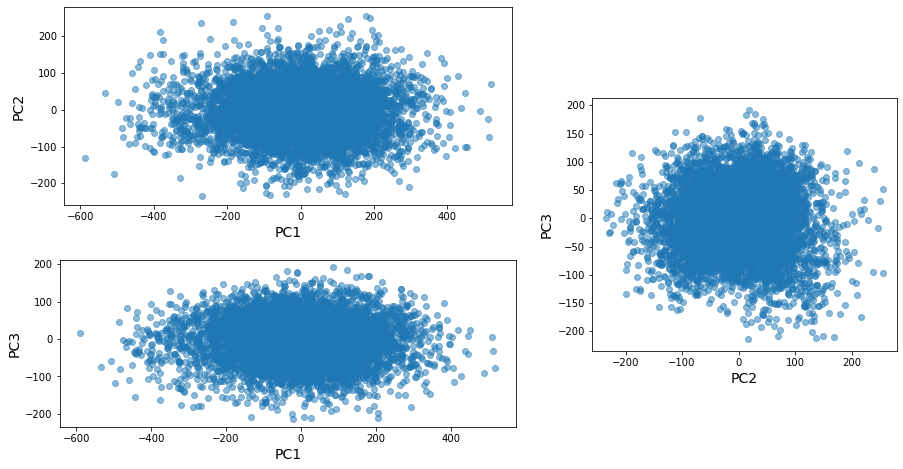

In [13]:
fig = plt.figure(figsize=(15,8), constrained_layout=False)
gspec = fig.add_gridspec(1,2, width_ratios=[0.6,0.4])
g_sub1 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gspec[0])
ax = fig.add_subplot(g_sub1[0])
p = ax.scatter(pca['pc_scores'][:,0], pca['pc_scores'][:,1], alpha=0.5)
ax.axis('scaled')
ax.set_xlabel('PC1', fontsize=14)
ax.set_ylabel('PC2', fontsize=14)

ax = fig.add_subplot(g_sub1[1])
p = ax.scatter(pca['pc_scores'][:,0], pca['pc_scores'][:,2], alpha=0.5)
ax.axis('scaled')
ax.set_xlabel('PC1', fontsize=14)
ax.set_ylabel('PC3', fontsize=14)

ax = fig.add_subplot(gspec[1])
p = ax.scatter(pca['pc_scores'][:,1], pca['pc_scores'][:,2], alpha=0.5)
ax.axis('scaled')
ax.set_xlabel('PC2', fontsize=14)
ax.set_ylabel('PC3', fontsize=14)

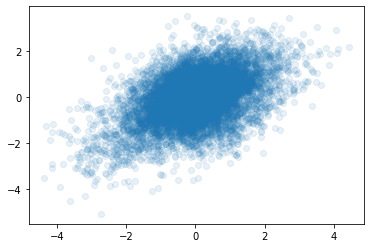

In [8]:
fig, ax = plt.subplots()
p = ax.scatter(pca_p['pc_scores'][:,0], pca_p['pc_scores'][:,1], alpha=0.1)

#### 9.2.1.2 Spatial Visualization

Text(0, 0.5, 'PC3')

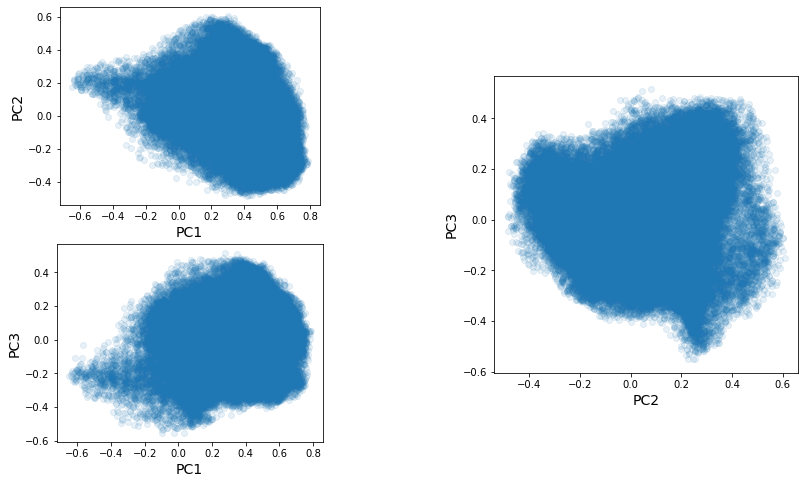

In [16]:
fig = plt.figure(figsize=(15,8), constrained_layout=False)
gspec = fig.add_gridspec(1,2, width_ratios=[0.6,0.4])
g_sub1 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gspec[0])
ax = fig.add_subplot(g_sub1[0])
p = ax.scatter(pca['loadings'][0,:], pca['loadings'][1,:], alpha=0.1)
ax.axis('scaled')
ax.set_xlabel('PC1', fontsize=14)
ax.set_ylabel('PC2', fontsize=14)

ax = fig.add_subplot(g_sub1[1])
p = ax.scatter(pca['loadings'][0,:], pca['loadings'][2,:], alpha=0.1)
ax.axis('scaled')
ax.set_xlabel('PC1', fontsize=14)
ax.set_ylabel('PC3', fontsize=14)

ax = fig.add_subplot(gspec[1])
p = ax.scatter(pca['loadings'][1,:], pca['loadings'][2,:], alpha=0.1)
ax.axis('scaled')
ax.set_xlabel('PC2', fontsize=14)
ax.set_ylabel('PC3', fontsize=14)

# 10. Misc

In [134]:
from utils.load_write import convert_2d
recon_promax = []
for i in range(2):
    nifti = nb.load(f'results/cpca/hcp_cpca_recon_n{i}_promax.nii', keep_file_open = True)
    mask = nb.load('masks/MNI152_T1_3mm_brain_mask_dilated.nii.gz').get_fdata()
    nifti_data = nifti.get_fdata()
    nifti.uncache()
    nifti_data = convert_2d(mask, nifti_data)
    if i == 0:
        nifti_data*=-1
    recon_promax.append(nifti_data)
recon_promax = np.stack(recon_promax, axis=2)

In [135]:
weight_vec = [0.6,0.4]
for i in range(2):
    if i == 1:
        recon_promax[:,:,i] = np.roll(recon_promax[:,:,i], 6, 0)
    recon_promax[:,:,i] *= weight_vec[i]
recon_sum = recon_promax.sum(axis=2)

In [136]:
mask = nb.load('masks/MNI152_T1_3mm_brain_mask_dilated.nii.gz')
mask_bin = mask.get_fdata() > 0
nifti_4d = np.zeros(mask.shape + (recon_sum.shape[0],), dtype=recon_sum.dtype)
nifti_4d[mask_bin, :] = recon_sum.T
nifti_out = nb.Nifti2Image(nifti_4d, mask.affine)
nb.save(nifti_out, 'recon_sum.nii')

In [137]:
cpca_ts = pickle.load(open('results/cpca/chang_pca_group_c_results.pkl', 'rb'))['pc_scores']
cpca_promax_ts = pickle.load(open('results/cpca/chang_pca_group_promax_c_results.pkl', 'rb'))['pc_scores']

In [138]:
cpca_ts_real = np.real(cpca_ts)
cpca_promax_ts_real = np.real(cpca_promax_ts)
cpca_promax_ts_real[:,0] *= -1

In [5]:
from run_taskbh_chang_analysis import construct_deep_breath_blocks, load_chang_bh_event_file

bh_events = load_chang_bh_event_file()
bh_event_blocks = construct_deep_breath_blocks(bh_events, 2.1)
bh_event_blocks = [tuple(b) for b in bh_event_blocks]

In [6]:
subject_list_chang_bh = pd.read_csv('data/dataset_chang_bh/subject_list_chang_bh.csv')

In [66]:
pca_output = pickle.load(open(f'results/pca/chang_bh_pca_group_results.pkl', 'rb'))
pca_output_p = pickle.load(open(f'results/pca/chang_bh_pca_group_promax_results.pkl', 'rb'))

pc_ts = pca_output['pc_scores']
pc_ts_p = pca_output_p['pc_scores']

n_t = 0
pc_subj_chang = {}
pc_p_subj_chang = {}
for i, (subj, scan, n_shift) in enumerate(
    zip(subject_list_chang_bh.subject, subject_list_chang_bh.scan, subject_list_chang_bh.nframes)
):
    # Extract subject PC time series
    pc_subj_chang[f'{subj}_{scan}'] = pc_ts[n_t:(n_t+n_shift),:]
    # Extract subject PC-Promax time series
    pc_p_subj_chang[f'{subj}_{scan}'] = pc_ts_p[n_t:(n_t+n_shift),:]
    n_t += n_shift
    

In [72]:
def load_subj_chang_bh(subj, scan, pc_ts, pc_ts_p, fs, norm=True, bp_filter=True):
    if scan < 10:
        scan_str = f'000{scan}'
    else:
        scan_str = f'00{scan}'
        
    p_str = f'data/dataset_chang_bh/physio/proc1_physio/sub_00{subj}_mr_{scan_str}_physio.csv'
    physio_df = pd.read_csv(p_str)
    e_str = f'data/dataset_chang_bh/eeg/proc1_fbands/sub_00{subj}_mr_{scan_str}_fbands.csv'
    eeg_bands = pd.read_csv(e_str)
    csf = np.loadtxt(f'data/dataset_chang_bh/physio/proc1_physio/sub_00{subj}_mr_{scan_str}_csf.txt')
    gs = np.loadtxt((f'data/dataset_chang_bh/physio/proc1_physio/sub_00{subj}_mr_{scan_str}_global_sig.txt'))
    df = pd.concat([physio_df, eeg_bands], axis=1)
    df['csf'] = csf
    df['gs'] = gs
    infraslow = df.pop('Infraslow')
    vigilance_ad = df.pop('vigilance_ad')
    vigilance_at = df.pop('vigilance_at')
    if bp_filter:
        df = df.apply(lambda x: butterworth_filter(x, 0.01, 0.1, fs=fs, filter_type='bandpass'), axis=0)
    df['Infraslow'] = infraslow
    df['pc1'] = pc_ts[:,0]
    df['pc2'] = pc_ts[:,1]
    df['pc3'] = pc_ts[:,2]
    df['pc1_p'] = pc_ts_p[:,0]
    df['pc2_p'] = pc_ts_p[:,1]
    df['pc3_p'] = pc_ts_p[:,2]
    df['vigilance_ad'] = vigilance_ad
    df['vigilance_at'] = vigilance_at
    df['vigilance_ad_low'] =  butterworth_filter(vigilance_ad, None, 0.01, fs=fs, filter_type='lowpass')
    df['vigilance_at_low'] = butterworth_filter(vigilance_at, None, 0.01, fs=fs, filter_type='lowpass')
    if norm:
        df = df.apply(zscore, axis=0)
    df.reset_index(inplace=True)
    df = df.rename(columns = {'index':'time'})
    return df

In [7]:
breath_onsets = np.loadtxt(f'data/dataset_chang_bh/adb_onsets.txt')
# remove first 14.7s to account for first 7 volumes removed
breath_onsets_tr = (breath_onsets - 14.7)/2.1
breath_onsets_tr = np.round(breath_onsets_tr).astype(int)

In [109]:
subj = 20
scan=12
df_subj = load_subj_chang_bh(subj, scan, pc_subj_chang[f'{subj}_{scan}'], pc_p_subj_chang[f'{subj}_{scan}'], fs_chang)
breath_onset_vec = np.zeros((df_subj.shape[0], 1))
breath_onset_vec[breath_onsets_tr] = 1
df_subj['breath_onset'] = breath_onset_vec

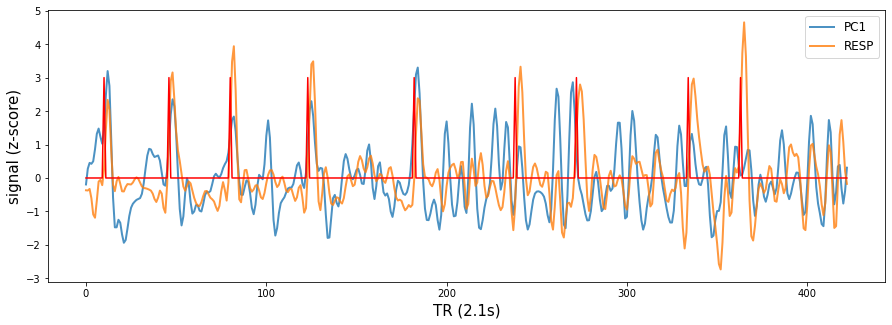

In [110]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df_subj['pc1'], label='PC1', linewidth=2, alpha=0.8)
ax.plot(df_subj['RESP_AMP_HILBERT'] ,label='RESP', linewidth=2, alpha=0.8)
ax.plot(df_subj['breath_onset']*3, color='r')
ax.set_xlabel('TR (2.1s)', fontsize=15)
ax.set_ylabel('signal (z-score)', fontsize=15)
ax.legend(fontsize=12)

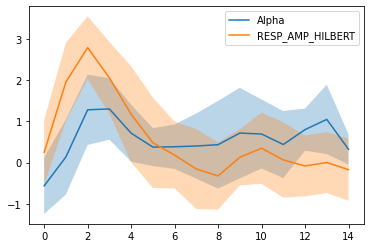

In [18]:
fig, ax = plt.subplots()
signals_avg = ['Alpha', 'RESP_AMP_HILBERT']
subj_scan_dict = {
    15: [9, 15],
    17: [6, 15],
    19: [16, 22],
    20: [12],
    21: [9],
    25: [12]
}

subj = 20
for signal in signals_avg:
    subj_blocks = []
    for scan in subj_scan_dict[subj]: 
        if scan < 10:
            scan_str = f'000{scan}'
        else:
            scan_str = f'00{scan}'
        # df_subj = load_subj_chang_bh(subj, scan, pc_subj_chang[f'{subj}_{scan}'], pc_p_subj_chang[f'{subj}_{scan}'], fs_chang)
        p_str = f'data/dataset_chang_bh/physio/proc1_physio/sub_00{subj}_mr_{scan_str}_physio.csv'
        physio_df = pd.read_csv(p_str)
        e_str = f'data/dataset_chang_bh/eeg/proc1_fbands/sub_00{subj}_mr_{scan_str}_fbands.csv'
        eeg_bands = pd.read_csv(e_str)
        df_subj = pd.concat([physio_df, eeg_bands], axis=1)
        df_subj = df_subj.apply(zscore, axis=0)
        signal_ts = df_subj[signal].values[np.newaxis, :]
        subj_blocks.append(np.squeeze(signal_ts[:,bh_event_blocks]))
    subj_blocks = np.vstack(subj_blocks)
    subj_std = subj_blocks.std(axis=0)
    subj_mean = subj_blocks.mean(axis=0)
    ax.plot(np.arange(15), subj_mean, label=signal)
    ax.fill_between(np.arange(15), subj_mean-subj_std, subj_mean+subj_std, alpha=0.3)
ax.legend()

In [290]:
breath_onsets_vec = np.zeros((df_subj.shape[0], 1))
breath_onsets_vec[breath_onsets_tr] = 1

def shifted_onsets(breath_onsets_vec):
    rand_shift = np.random.randint(0, len(breath_onsets_vec))
    breath_onsets_vec_rand = np.roll(breath_onsets_vec, rand_shift)
    breath_onsets_rand_tr = np.where(breath_onsets_vec_rand==1)[0]
    return breath_onsets_rand_tr

signal_ts = df_subj['Alpha'].values[np.newaxis, :]
signal_blocks = np.squeeze(signal_ts[:,bh_event_blocks])
signal_mean = signal_blocks.mean(axis=0)

perm_avg = []
for i in range(500):
    rand_onsets = shifted_onsets(breath_onset_vec)
    bh_event_blocks_rand = construct_deep_breath_blocks(rand_onsets, 2.1)
    bh_event_blocks_rand = [tuple(b) for b in bh_event_blocks_rand]
    signal_blocks_rand = np.squeeze(signal_ts[:,bh_event_blocks_rand])
    signal_mean_rand = signal_blocks_rand.mean(axis=0)
    perm_avg.append(np.abs(signal_mean_rand))
    

In [291]:
perm_95 = np.percentile(perm_avg, 95, axis=0)
np.abs(signal_mean) > perm_95

array([False,  True,  True,  True, False, False,  True,  True, False,
       False, False, False, False, False, False])

In [35]:
from utils.load_write import load_data, write_nifti, convert_2d
mask_full = nb.load('masks/MNI152_T1_3mm_brain_mask_dilated.nii.gz')
mask = mask_full.get_fdata() > 0

# nifti = nb.load('results/physio_glm/chang_physio_reg_group_rv.nii', keep_file_open = True)
nifti = nb.load('hcp_fix_physio_reg_group_test_6.nii', keep_file_open = True)
nifti_data = nifti.get_fdata()
nifti.uncache()
nifti_data = convert_2d(mask, nifti_data)
# nan_mask = ~(np.isnan(nifti_data).any(axis=0))

In [36]:
from sklearn.cluster import MiniBatchKMeans

In [37]:
kmeans = MiniBatchKMeans(n_clusters=3)
kmeans.fit(nifti_data.T)

MiniBatchKMeans(n_clusters=3)

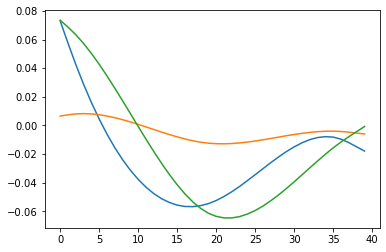

In [38]:
plt.plot(kmeans.cluster_centers_.T)

In [39]:
data_write = kmeans.labels_[np.newaxis, :]+1
nifti_4d = np.zeros(mask.shape + (data_write.shape[0],), 
                    dtype=data_write.dtype)
nifti_4d[mask, :] = data_write.T
nifti_out = nb.Nifti2Image(nifti_4d, mask_full.affine)
nb.save(nifti_out, 'hcp_fix_test3.nii')